In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, math
import time
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops

from ops import *
from utils import *

In [15]:
print(tf.__version__)

1.4.0


In [5]:
model_name = "CGAN-QDraw"     # name for checkpoint

In [17]:
def plot_image(image_array):
    print(image_array.shape)
    if image_array.shape != (28,28):
        image_array = image_array.reshape((28, 28))
    plt.imshow(image_array, cmap='gray')
    plt.show()
    
def get_images_mean(images_array):
        if images_array.shape != (None,28,28,1):
            image_stack = np.concatenate([im[..., None] for im in images_array], axis=1)
        #else:
        median_image = np.median(image_stack, axis=1)
        pixels = np.array(median_image, dtype='uint8')
        return pixels
    

## Params 

In [6]:
checkpoint_dir = './checkpoints/' # checkpoint_dir
result_dir = './results/' #result_dir
log_dir = './logs/' #log_dir

In [7]:
epoch = 10 #epoch
batch_size = 32# batch_size

# parameters
input_height = 28
input_width = 28
output_height = 28
output_width = 28

z_dim = 100       # dimension of noise-vector
y_dim = 5         # dimension of condition-vector (label)
c_dim = 1

# train
learning_rate = 0.0002
beta1 = 0.5

# test
sample_num = 64  # number of generated images to be saved

## Load Data

In [8]:
def make_labels(amount, category):
    a = np.empty(amount)
    a.fill(category)
    a = a.astype(int)
    return a

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [9]:
num_examples = 40000

In [20]:
# load and make image arrays
bicycles = np.load("../../data/bicycle.npy")[:num_examples]
bicycles = bicycles.reshape(num_examples,28,28,1)
print(bicycles.shape)
print(bicycles[0].shape)

angels = np.load("../../data/angel.npy")[:num_examples]
angels = angels.reshape(num_examples,28,28,1)
print(angels.shape)
print(angels[0].shape)

bananas = np.load("../../data/banana.npy")[:num_examples]
bananas = bananas.reshape(num_examples,28,28,1)
print(bananas.shape)
print(bananas[0].shape)

brains = np.load("../../data/brain.npy")[:num_examples]
brains = brains.reshape(num_examples,28,28,1)
print(brains.shape)
print(brains[0].shape)

bees = np.load("../../data/bee.npy")[:num_examples]
bees = bees.reshape(num_examples,28,28,1)
print(bees.shape)
print(bees[0].shape)
data_X = np.concatenate((bicycles, angels,bananas,brains,bees), axis=0)
print(data_X.shape)

(40000, 28, 28, 1)
(28, 28, 1)
(40000, 28, 28, 1)
(28, 28, 1)
(40000, 28, 28, 1)
(28, 28, 1)
(40000, 28, 28, 1)
(28, 28, 1)
(40000, 28, 28, 1)
(28, 28, 1)
(200000, 28, 28, 1)


In [21]:
# Make make labels
nb_classes = 5
bicycles_labels = make_labels(num_examples,0)
bicycles_labels = np.eye(nb_classes)[bicycles_labels]
angels_labels = make_labels(num_examples,1)
angels_labels = np.eye(nb_classes)[angels_labels]
bananas_labels = make_labels(num_examples,2)
bananas_labels = np.eye(nb_classes)[bananas_labels]
brains_labels = make_labels(num_examples,3)
brains_labels = np.eye(nb_classes)[brains_labels]
bees_labels = make_labels(num_examples,4)
bees_labels = np.eye(nb_classes)[bees_labels]

data_y = np.concatenate((bicycles_labels, angels_labels,bananas_labels,brains_labels,bees_labels), axis=0)
print(bicycles_labels.shape)
print(angels_labels.shape)
print(bananas_labels.shape)
print(brains_labels.shape)
print(bees_labels.shape)
print(data_y.shape)

data_y[0]

(40000, 5)
(40000, 5)
(40000, 5)
(40000, 5)
(40000, 5)
(200000, 5)


array([ 1.,  0.,  0.,  0.,  0.])

In [22]:
data_X, data_y = unison_shuffled_copies(data_X,data_y)

(28, 28, 1)


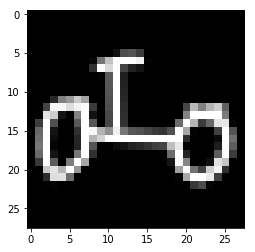

[ 1.  0.  0.  0.  0.]


In [23]:
plot_image(data_X[5])
print(data_y[5])

In [24]:
data_X = data_X/255.

In [25]:
# number of batches for a single epoch
num_batches = len(data_X) // batch_size

dataset_name = 'quickdraw-multi'

model_dir = "{}_{}_{}_{}".format(
            model_name, dataset_name,
            batch_size, z_dim)

In [26]:
def discriminator(x, y, is_training=True, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):

        # merge image and label
        y = tf.reshape(y, [batch_size, 1, 1, y_dim])
        x = conv_cond_concat(x, y)

        net = lrelu(conv2d(x, 64, 4, 4, 2, 2, name='d_conv1'))
        net = lrelu(bn(conv2d(net, 128, 4, 4, 2, 2, name='d_conv2'), is_training=is_training, scope='d_bn2'))
        net = tf.reshape(net, [batch_size, -1])
        net = lrelu(bn(linear(net, 1024, scope='d_fc3'), is_training=is_training, scope='d_bn3'))
        out_logit = linear(net, 1, scope='d_fc4')
        out = tf.nn.sigmoid(out_logit)

        return out, out_logit, net

In [27]:
def generator(z, y, is_training=True, reuse=False):
    with tf.variable_scope("generator", reuse=reuse):

        # merge noise and label
        z = concat([z, y], 1)

        net = tf.nn.relu(bn(linear(z, 1024, scope='g_fc1'), is_training=is_training, scope='g_bn1'))
        net = tf.nn.relu(bn(linear(net, 128 * 7 * 7, scope='g_fc2'), is_training=is_training, scope='g_bn2'))
        net = tf.reshape(net, [batch_size, 7, 7, 128])
        net = tf.nn.relu(
            bn(deconv2d(net, [batch_size, 14, 14, 64], 4, 4, 2, 2, name='g_dc3'), is_training=is_training,
               scope='g_bn3'))

        out = tf.nn.sigmoid(deconv2d(net, [batch_size, 28, 28, 1], 4, 4, 2, 2, name='g_dc4'))

        return out

## Build the model

In [28]:
# some parameters
image_dims = [input_height, input_width, c_dim]
bs = batch_size

# images
inputs = tf.placeholder(tf.float32, [bs] + image_dims, name='real_images')

# labels
y = tf.placeholder(tf.float32, [bs, y_dim], name='y')

# noises
z = tf.placeholder(tf.float32, [bs, z_dim], name='z')

### Loss Function

In [29]:
# output of D for real images
D_real, D_real_logits, _ = discriminator(inputs, y, is_training=True, reuse=False)

# output of D for fake images
G = generator(z, y, is_training=True, reuse=False)
D_fake, D_fake_logits, _ = discriminator(G, y, is_training=True, reuse=True)

# get loss for discriminator
d_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real)))
d_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros_like(D_fake)))

d_loss = d_loss_real + d_loss_fake

# get loss for generator
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones_like(D_fake)))

In [30]:
""" Trainable params """
# divide trainable variables into a group for D and a group for G
t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if 'd_' in var.name]
g_vars = [var for var in t_vars if 'g_' in var.name]

In [31]:
# optimizers
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    d_optim = tf.train.AdamOptimizer(learning_rate, beta1=beta1) \
              .minimize(d_loss, var_list=d_vars)
    g_optim = tf.train.AdamOptimizer(learning_rate*5, beta1=beta1) \
              .minimize(g_loss, var_list=g_vars)

In [32]:
"""" Testing """
# for test
fake_images = generator(z, y, is_training=False, reuse=True)

""" Summary for TensorBoard"""
d_loss_real_sum = tf.summary.scalar("d_loss_real", d_loss_real)
d_loss_fake_sum = tf.summary.scalar("d_loss_fake", d_loss_fake)
d_loss_sum = tf.summary.scalar("d_loss", d_loss)
g_loss_sum = tf.summary.scalar("g_loss", g_loss)

# final summary operations
g_sum = tf.summary.merge([d_loss_fake_sum, g_loss_sum])
d_sum = tf.summary.merge([d_loss_real_sum, d_loss_sum])

In [33]:
def visualize_results( epoch):
    tot_num_samples = min(sample_num, batch_size)
    image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))

    """ random condition, random noise """

    z_sample = np.random.uniform(-1, 1, size=(batch_size, z_dim))

    samples = sess.run(fake_images, feed_dict={z: z_sample})

    save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                check_folder(result_dir + '/' + model_dir) + '/' + model_name + '_epoch%03d' % epoch + '_test_all_classes.png')

In [34]:
def visualize_results(epoch):
    tot_num_samples = min(sample_num, batch_size)
    image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))

    """ random condition, random noise """
    y = np.random.choice(y_dim, batch_size)
    y_one_hot = np.zeros((batch_size, y_dim))
    y_one_hot[np.arange(batch_size), y] = 1

    z_sample = np.random.uniform(-1, 1, size=(batch_size, z_dim))

    samples = sess.run(fake_images, feed_dict={z: z_sample, y: y_one_hot})

    save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                check_folder(result_dir + '/' + model_dir) + '/' + model_name + '_epoch%03d' % epoch + '_test_all_classes.png')

    """ specified condition, random noise """
    n_styles = 10  # must be less than or equal to batch_size

    np.random.seed()
    si = np.random.choice(batch_size, n_styles)

    for l in range(y_dim):
        y = np.zeros(batch_size, dtype=np.int64) + l
        y_one_hot = np.zeros((batch_size, y_dim))
        y_one_hot[np.arange(batch_size), y] = 1

        samples = sess.run(fake_images, feed_dict={z: z_sample, y: y_one_hot})
        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                    check_folder(result_dir + '/' + model_dir) + '/' + model_name + '_epoch%03d' % epoch + '_test_class_%d.png' % l)

        samples = samples[si, :, :, :]

        if l == 0:
            all_samples = samples
        else:
            all_samples = np.concatenate((all_samples, samples), axis=0)

    """ save merged images to check style-consistency """
    canvas = np.zeros_like(all_samples)
    for s in range(n_styles):
        for c in range(y_dim):
            canvas[s * y_dim + c, :, :, :] = all_samples[c * n_styles + s, :, :, :]

    save_images(canvas, [n_styles, y_dim],
                check_folder(result_dir + '/' + model_dir) + '/' + model_name + '_epoch%03d' % epoch + '_test_all_classes_style_by_style.png')

In [35]:
def load( checkpoint_dir):
    import re
    print(" [*] Reading checkpoints...")
    checkpoint_dir = os.path.join(checkpoint_dir, model_dir, model_name)

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
        saver.restore(sess, os.path.join(checkpoint_dir, ckpt_name))
        counter = int(next(re.finditer("(\d+)(?!.*\d)",ckpt_name)).group(0))
        print(" [*] Successfully read {}".format(ckpt_name))
        return True, counter
    else:
        print(" [*] Failed to find a checkpoint")
        return False, 0

In [36]:
def save(checkpoint_dir, step):
    checkpoint_dir = os.path.join(checkpoint_dir, model_dir, model_name)

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    saver.save(sess,os.path.join(checkpoint_dir, model_name+'.model'), global_step=step)

In [38]:

#with sess.as_default():
with tf.Session(config=tf.ConfigProto(allow_soft_placement=False)) as sess:
    # initialize all variables
    tf.global_variables_initializer().run()

    # graph inputs for visualize training results
    sample_z = np.random.uniform(-1, 1, size=(batch_size , z_dim))
    test_labels = data_y[0:batch_size]

    # saver to save model
    saver = tf.train.Saver()

    # summary writer
    writer = tf.summary.FileWriter(log_dir + '/' + model_name, sess.graph)

    # restore check-point if it exits
    could_load, checkpoint_counter = load(checkpoint_dir)
    if could_load:
        start_epoch = (int)(checkpoint_counter / num_batches)
        start_batch_id = checkpoint_counter - start_epoch * num_batches
        counter = checkpoint_counter
        print(" [*] Load SUCCESS")
    else:
        start_epoch = 0
        start_batch_id = 0
        counter = 1
        print(" [!] Load failed...")

    # loop for epoch
    start_time = time.time()
    print(start_time)
    for temp_epoch in range(start_epoch, epoch):

        # get batch data
        for idx in range(start_batch_id, num_batches):
            batch_images = data_X[idx*batch_size:(idx+1)*batch_size]
            batch_labels = data_y[idx * batch_size:(idx + 1) * batch_size]
            batch_z = np.random.uniform(-1, 1, [batch_size, z_dim]).astype(np.float32)
            
            # update D network
            _, summary_str, dd_loss = sess.run([d_optim, d_sum, d_loss], feed_dict={inputs: batch_images, y: batch_labels, z: batch_z})
            writer.add_summary(summary_str, counter)

            # update G network
            _, summary_str, gg_loss = sess.run([g_optim, g_sum, g_loss], feed_dict={y: batch_labels, z: batch_z})
            writer.add_summary(summary_str, counter)

            # display training status
            counter += 1
            print("Epoch: [%2d] [%4d/%4d] time: %4.4f, d_loss: %.8f, g_loss: %.8f" \
                  % (temp_epoch, idx, num_batches, time.time() - start_time, dd_loss, gg_loss))

            # save training results for every 300 steps
            if np.mod(counter, 300) == 0:
                samples = sess.run(fake_images, feed_dict={z: sample_z, y: test_labels})
                tot_num_samples = min(sample_num, batch_size)
                manifold_h = int(np.floor(np.sqrt(tot_num_samples)))
                manifold_w = int(np.floor(np.sqrt(tot_num_samples)))
                save_images(samples[:manifold_h * manifold_w, :, :, :], [manifold_h, manifold_w],
                            './' + check_folder(result_dir + '/' + model_dir) + '/' + model_name + '_train_{:02d}_{:04d}.png'.format(
                                temp_epoch, idx))

        # After an epoch, start_batch_id is set to zero
        # non-zero value is only for the first epoch after loading pre-trained model
        start_batch_id = 0

        # save model
        save(checkpoint_dir, counter)

        # show temporal results
        #visualize_results(temp_epoch)

    # save model for final step
    save(checkpoint_dir, counter)

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ./checkpoints/CGAN-QDraw_quickdraw-multi_32_100/CGAN-QDraw/CGAN-QDraw.model-6251
 [*] Successfully read CGAN-QDraw.model-6251
 [*] Load SUCCESS
1510547388.7187006
Epoch: [ 1] [   1/6250] time: 0.2829, d_loss: 0.98784089, g_loss: 1.56319070
Epoch: [ 1] [   2/6250] time: 0.4592, d_loss: 0.66298532, g_loss: 1.80479002
Epoch: [ 1] [   3/6250] time: 0.6583, d_loss: 1.10493016, g_loss: 1.18763661
Epoch: [ 1] [   4/6250] time: 0.8473, d_loss: 0.86779892, g_loss: 2.20008421
Epoch: [ 1] [   5/6250] time: 1.0391, d_loss: 0.77235079, g_loss: 1.29234171
Epoch: [ 1] [   6/6250] time: 1.2283, d_loss: 0.56116652, g_loss: 1.83174992
Epoch: [ 1] [   7/6250] time: 1.4206, d_loss: 1.25000954, g_loss: 1.23710072
Epoch: [ 1] [   8/6250] time: 1.6068, d_loss: 0.73716462, g_loss: 1.93410861
Epoch: [ 1] [   9/6250] time: 1.7956, d_loss: 0.53494281, g_loss: 2.26674080
Epoch: [ 1] [  10/6250] time: 1.9702, d_loss: 0.57023191, g_loss: 1.792635

Epoch: [ 1] [ 104/6250] time: 19.2190, d_loss: 0.88109171, g_loss: 1.21834993
Epoch: [ 1] [ 105/6250] time: 19.3903, d_loss: 0.82685345, g_loss: 2.14757657
Epoch: [ 1] [ 106/6250] time: 19.5630, d_loss: 0.66949028, g_loss: 1.83844018
Epoch: [ 1] [ 107/6250] time: 19.7437, d_loss: 0.69922781, g_loss: 1.00440347
Epoch: [ 1] [ 108/6250] time: 19.9207, d_loss: 1.04884911, g_loss: 1.69306159
Epoch: [ 1] [ 109/6250] time: 20.0926, d_loss: 0.83593059, g_loss: 1.56024146
Epoch: [ 1] [ 110/6250] time: 20.2698, d_loss: 0.71342921, g_loss: 1.62153161
Epoch: [ 1] [ 111/6250] time: 20.4443, d_loss: 0.82682264, g_loss: 1.34777665
Epoch: [ 1] [ 112/6250] time: 20.6202, d_loss: 0.62604839, g_loss: 1.59346533
Epoch: [ 1] [ 113/6250] time: 20.8079, d_loss: 0.69913900, g_loss: 1.74481153
Epoch: [ 1] [ 114/6250] time: 20.9978, d_loss: 0.66778386, g_loss: 1.76207829
Epoch: [ 1] [ 115/6250] time: 21.1940, d_loss: 0.67874694, g_loss: 1.23177838
Epoch: [ 1] [ 116/6250] time: 21.3911, d_loss: 0.75364292, g_los

Epoch: [ 1] [ 210/6250] time: 38.6650, d_loss: 0.76066053, g_loss: 1.93372619
Epoch: [ 1] [ 211/6250] time: 38.8529, d_loss: 1.02577841, g_loss: 0.97222137
Epoch: [ 1] [ 212/6250] time: 39.0288, d_loss: 0.58837306, g_loss: 1.70957720
Epoch: [ 1] [ 213/6250] time: 39.2020, d_loss: 0.72929543, g_loss: 1.99714041
Epoch: [ 1] [ 214/6250] time: 39.3782, d_loss: 0.99586546, g_loss: 1.55104828
Epoch: [ 1] [ 215/6250] time: 39.5580, d_loss: 0.99464148, g_loss: 1.22871244
Epoch: [ 1] [ 216/6250] time: 39.7380, d_loss: 0.65196943, g_loss: 1.32783401
Epoch: [ 1] [ 217/6250] time: 39.9101, d_loss: 0.55169070, g_loss: 1.65189195
Epoch: [ 1] [ 218/6250] time: 40.0825, d_loss: 0.81755203, g_loss: 2.05824852
Epoch: [ 1] [ 219/6250] time: 40.2535, d_loss: 1.01496267, g_loss: 1.58830857
Epoch: [ 1] [ 220/6250] time: 40.4318, d_loss: 1.24266577, g_loss: 1.70584571
Epoch: [ 1] [ 221/6250] time: 40.6025, d_loss: 0.95679337, g_loss: 1.52963006
Epoch: [ 1] [ 222/6250] time: 40.7900, d_loss: 1.11297286, g_los

Epoch: [ 1] [ 316/6250] time: 58.0486, d_loss: 0.54835856, g_loss: 1.87256992
Epoch: [ 1] [ 317/6250] time: 58.2337, d_loss: 0.63829279, g_loss: 1.84382558
Epoch: [ 1] [ 318/6250] time: 58.4244, d_loss: 0.91251868, g_loss: 1.34487247
Epoch: [ 1] [ 319/6250] time: 58.6088, d_loss: 0.77942312, g_loss: 1.89415169
Epoch: [ 1] [ 320/6250] time: 58.8054, d_loss: 0.95556056, g_loss: 1.46999466
Epoch: [ 1] [ 321/6250] time: 58.9917, d_loss: 0.83597696, g_loss: 1.62620616
Epoch: [ 1] [ 322/6250] time: 59.1842, d_loss: 1.13014102, g_loss: 1.31717229
Epoch: [ 1] [ 323/6250] time: 59.3725, d_loss: 0.91479540, g_loss: 1.81684279
Epoch: [ 1] [ 324/6250] time: 59.5469, d_loss: 0.68034101, g_loss: 1.89245415
Epoch: [ 1] [ 325/6250] time: 59.7205, d_loss: 0.91244739, g_loss: 1.30947781
Epoch: [ 1] [ 326/6250] time: 59.8981, d_loss: 0.76356244, g_loss: 1.67688048
Epoch: [ 1] [ 327/6250] time: 60.0700, d_loss: 0.65357423, g_loss: 1.60342300
Epoch: [ 1] [ 328/6250] time: 60.2430, d_loss: 0.65009457, g_los

Epoch: [ 1] [ 422/6250] time: 77.4616, d_loss: 0.85690880, g_loss: 1.79869366
Epoch: [ 1] [ 423/6250] time: 77.6478, d_loss: 0.59842998, g_loss: 2.17563725
Epoch: [ 1] [ 424/6250] time: 77.8403, d_loss: 0.96227211, g_loss: 2.01673985
Epoch: [ 1] [ 425/6250] time: 78.0339, d_loss: 0.86057526, g_loss: 1.51915383
Epoch: [ 1] [ 426/6250] time: 78.2194, d_loss: 0.74635738, g_loss: 1.16938019
Epoch: [ 1] [ 427/6250] time: 78.4073, d_loss: 0.84380519, g_loss: 1.48438609
Epoch: [ 1] [ 428/6250] time: 78.5993, d_loss: 0.74928892, g_loss: 2.22496891
Epoch: [ 1] [ 429/6250] time: 78.7732, d_loss: 0.82826298, g_loss: 1.63199174
Epoch: [ 1] [ 430/6250] time: 78.9475, d_loss: 0.87679255, g_loss: 1.71159005
Epoch: [ 1] [ 431/6250] time: 79.1183, d_loss: 0.86605430, g_loss: 1.09523535
Epoch: [ 1] [ 432/6250] time: 79.3017, d_loss: 0.60474741, g_loss: 1.75464475
Epoch: [ 1] [ 433/6250] time: 79.4734, d_loss: 0.86277711, g_loss: 1.83161187
Epoch: [ 1] [ 434/6250] time: 79.6571, d_loss: 1.17131472, g_los

Epoch: [ 1] [ 528/6250] time: 96.8610, d_loss: 0.98530912, g_loss: 1.60463285
Epoch: [ 1] [ 529/6250] time: 97.0349, d_loss: 0.54930651, g_loss: 1.70315349
Epoch: [ 1] [ 530/6250] time: 97.2071, d_loss: 1.16184032, g_loss: 1.96572304
Epoch: [ 1] [ 531/6250] time: 97.3783, d_loss: 1.17161989, g_loss: 1.81626511
Epoch: [ 1] [ 532/6250] time: 97.5542, d_loss: 0.78549832, g_loss: 1.47983861
Epoch: [ 1] [ 533/6250] time: 97.7270, d_loss: 0.76529163, g_loss: 1.87587619
Epoch: [ 1] [ 534/6250] time: 97.9113, d_loss: 0.73141932, g_loss: 1.83007371
Epoch: [ 1] [ 535/6250] time: 98.1050, d_loss: 0.75654817, g_loss: 1.84263301
Epoch: [ 1] [ 536/6250] time: 98.2957, d_loss: 0.49175560, g_loss: 1.94098938
Epoch: [ 1] [ 537/6250] time: 98.4825, d_loss: 0.65907794, g_loss: 1.46711934
Epoch: [ 1] [ 538/6250] time: 98.6734, d_loss: 0.73897910, g_loss: 2.35109830
Epoch: [ 1] [ 539/6250] time: 98.8652, d_loss: 0.79103082, g_loss: 1.59389806
Epoch: [ 1] [ 540/6250] time: 99.0553, d_loss: 0.70421267, g_los

Epoch: [ 1] [ 633/6250] time: 115.9084, d_loss: 0.53725815, g_loss: 1.81217420
Epoch: [ 1] [ 634/6250] time: 116.0985, d_loss: 0.78047776, g_loss: 1.34940648
Epoch: [ 1] [ 635/6250] time: 116.2896, d_loss: 0.51504368, g_loss: 2.26798058
Epoch: [ 1] [ 636/6250] time: 116.4689, d_loss: 0.73092961, g_loss: 1.62142706
Epoch: [ 1] [ 637/6250] time: 116.6463, d_loss: 0.58052033, g_loss: 1.64300632
Epoch: [ 1] [ 638/6250] time: 116.8231, d_loss: 0.79939616, g_loss: 2.22252226
Epoch: [ 1] [ 639/6250] time: 117.0023, d_loss: 0.88609242, g_loss: 1.02221227
Epoch: [ 1] [ 640/6250] time: 117.1752, d_loss: 0.66394269, g_loss: 1.22887194
Epoch: [ 1] [ 641/6250] time: 117.3645, d_loss: 0.58472639, g_loss: 2.07925653
Epoch: [ 1] [ 642/6250] time: 117.5368, d_loss: 0.71608949, g_loss: 1.90497708
Epoch: [ 1] [ 643/6250] time: 117.7141, d_loss: 1.12569332, g_loss: 0.89450222
Epoch: [ 1] [ 644/6250] time: 117.8876, d_loss: 0.80777746, g_loss: 1.59825003
Epoch: [ 1] [ 645/6250] time: 118.0635, d_loss: 0.74

Epoch: [ 1] [ 737/6250] time: 134.8754, d_loss: 0.53779852, g_loss: 2.25955963
Epoch: [ 1] [ 738/6250] time: 135.0489, d_loss: 0.71411127, g_loss: 1.43728948
Epoch: [ 1] [ 739/6250] time: 135.2247, d_loss: 0.94432342, g_loss: 1.91578484
Epoch: [ 1] [ 740/6250] time: 135.4000, d_loss: 0.49630949, g_loss: 2.14634037
Epoch: [ 1] [ 741/6250] time: 135.5748, d_loss: 1.08461690, g_loss: 1.10754240
Epoch: [ 1] [ 742/6250] time: 135.7509, d_loss: 0.79404002, g_loss: 1.87765622
Epoch: [ 1] [ 743/6250] time: 135.9267, d_loss: 0.65728021, g_loss: 1.89302671
Epoch: [ 1] [ 744/6250] time: 136.0983, d_loss: 0.93937141, g_loss: 1.48851717
Epoch: [ 1] [ 745/6250] time: 136.2681, d_loss: 0.61395788, g_loss: 1.88940287
Epoch: [ 1] [ 746/6250] time: 136.4383, d_loss: 0.77181369, g_loss: 2.01759577
Epoch: [ 1] [ 747/6250] time: 136.6223, d_loss: 0.75361061, g_loss: 1.72658134
Epoch: [ 1] [ 748/6250] time: 136.8131, d_loss: 0.57423687, g_loss: 1.54252982
Epoch: [ 1] [ 749/6250] time: 137.0044, d_loss: 0.71

Epoch: [ 1] [ 842/6250] time: 154.1197, d_loss: 0.60164297, g_loss: 1.62090993
Epoch: [ 1] [ 843/6250] time: 154.3072, d_loss: 0.53278381, g_loss: 2.28292632
Epoch: [ 1] [ 844/6250] time: 154.4916, d_loss: 0.76246917, g_loss: 1.92975974
Epoch: [ 1] [ 845/6250] time: 154.6645, d_loss: 1.03918600, g_loss: 1.07161808
Epoch: [ 1] [ 846/6250] time: 154.8434, d_loss: 0.99094325, g_loss: 2.03939247
Epoch: [ 1] [ 847/6250] time: 155.0164, d_loss: 0.86019373, g_loss: 2.02354670
Epoch: [ 1] [ 848/6250] time: 155.1901, d_loss: 0.62461865, g_loss: 1.60357833
Epoch: [ 1] [ 849/6250] time: 155.3640, d_loss: 0.58860278, g_loss: 1.57097459
Epoch: [ 1] [ 850/6250] time: 155.5544, d_loss: 0.60108274, g_loss: 1.79222381
Epoch: [ 1] [ 851/6250] time: 155.7551, d_loss: 0.61149424, g_loss: 2.21520662
Epoch: [ 1] [ 852/6250] time: 155.9473, d_loss: 0.58154774, g_loss: 2.02142239
Epoch: [ 1] [ 853/6250] time: 156.1390, d_loss: 0.60792649, g_loss: 1.60528374
Epoch: [ 1] [ 854/6250] time: 156.3312, d_loss: 0.33

Epoch: [ 1] [ 947/6250] time: 173.3031, d_loss: 0.68929905, g_loss: 1.77800620
Epoch: [ 1] [ 948/6250] time: 173.4878, d_loss: 0.53937495, g_loss: 1.80908573
Epoch: [ 1] [ 949/6250] time: 173.6793, d_loss: 0.56354022, g_loss: 1.80317187
Epoch: [ 1] [ 950/6250] time: 173.9083, d_loss: 0.58873749, g_loss: 1.77169061
Epoch: [ 1] [ 951/6250] time: 174.0918, d_loss: 0.66041136, g_loss: 1.39739156
Epoch: [ 1] [ 952/6250] time: 174.2683, d_loss: 1.09417701, g_loss: 2.28313780
Epoch: [ 1] [ 953/6250] time: 174.4425, d_loss: 0.77461022, g_loss: 1.62750900
Epoch: [ 1] [ 954/6250] time: 174.6328, d_loss: 0.55571032, g_loss: 1.77260876
Epoch: [ 1] [ 955/6250] time: 174.8083, d_loss: 0.69894028, g_loss: 1.97463965
Epoch: [ 1] [ 956/6250] time: 174.9819, d_loss: 0.66099948, g_loss: 1.52196121
Epoch: [ 1] [ 957/6250] time: 175.1528, d_loss: 0.83131945, g_loss: 1.41913462
Epoch: [ 1] [ 958/6250] time: 175.3293, d_loss: 0.66578710, g_loss: 2.03834343
Epoch: [ 1] [ 959/6250] time: 175.4987, d_loss: 0.65

Epoch: [ 1] [1052/6250] time: 192.3978, d_loss: 0.77614677, g_loss: 1.64531684
Epoch: [ 1] [1053/6250] time: 192.5697, d_loss: 0.79528457, g_loss: 1.56419981
Epoch: [ 1] [1054/6250] time: 192.7474, d_loss: 0.69357103, g_loss: 1.28219736
Epoch: [ 1] [1055/6250] time: 192.9194, d_loss: 0.65401387, g_loss: 1.93223214
Epoch: [ 1] [1056/6250] time: 193.0923, d_loss: 0.69154817, g_loss: 1.42363119
Epoch: [ 1] [1057/6250] time: 193.2641, d_loss: 0.89244425, g_loss: 2.28985715
Epoch: [ 1] [1058/6250] time: 193.4398, d_loss: 1.03644323, g_loss: 1.59009528
Epoch: [ 1] [1059/6250] time: 193.6121, d_loss: 0.74228597, g_loss: 1.13245940
Epoch: [ 1] [1060/6250] time: 193.7901, d_loss: 0.73090142, g_loss: 1.92760539
Epoch: [ 1] [1061/6250] time: 193.9634, d_loss: 0.56633878, g_loss: 1.91411138
Epoch: [ 1] [1062/6250] time: 194.1493, d_loss: 0.90936351, g_loss: 1.21933734
Epoch: [ 1] [1063/6250] time: 194.3236, d_loss: 0.82348663, g_loss: 2.11079049
Epoch: [ 1] [1064/6250] time: 194.5001, d_loss: 0.87

Epoch: [ 1] [1156/6250] time: 211.1656, d_loss: 1.00996351, g_loss: 1.24128115
Epoch: [ 1] [1157/6250] time: 211.3545, d_loss: 1.02273858, g_loss: 1.27564645
Epoch: [ 1] [1158/6250] time: 211.5461, d_loss: 0.89175320, g_loss: 1.29719520
Epoch: [ 1] [1159/6250] time: 211.7329, d_loss: 1.20102429, g_loss: 1.11544740
Epoch: [ 1] [1160/6250] time: 211.9361, d_loss: 0.86434579, g_loss: 1.52903652
Epoch: [ 1] [1161/6250] time: 212.1219, d_loss: 0.84707946, g_loss: 1.31803298
Epoch: [ 1] [1162/6250] time: 212.3133, d_loss: 0.83642685, g_loss: 1.38422823
Epoch: [ 1] [1163/6250] time: 212.5016, d_loss: 0.91581500, g_loss: 1.28390133
Epoch: [ 1] [1164/6250] time: 212.6939, d_loss: 0.84680200, g_loss: 1.55917525
Epoch: [ 1] [1165/6250] time: 212.8864, d_loss: 0.68273377, g_loss: 1.68613303
Epoch: [ 1] [1166/6250] time: 213.0797, d_loss: 0.98764402, g_loss: 1.28463435
Epoch: [ 1] [1167/6250] time: 213.2665, d_loss: 0.78956747, g_loss: 1.57291985
Epoch: [ 1] [1168/6250] time: 213.4513, d_loss: 0.73

Epoch: [ 1] [1260/6250] time: 230.2496, d_loss: 0.85290736, g_loss: 1.68065929
Epoch: [ 1] [1261/6250] time: 230.4271, d_loss: 1.02382445, g_loss: 1.66451335
Epoch: [ 1] [1262/6250] time: 230.5995, d_loss: 1.05118012, g_loss: 1.32306051
Epoch: [ 1] [1263/6250] time: 230.7764, d_loss: 0.64257562, g_loss: 1.85455608
Epoch: [ 1] [1264/6250] time: 230.9602, d_loss: 0.93459684, g_loss: 1.53208220
Epoch: [ 1] [1265/6250] time: 231.1320, d_loss: 0.57141888, g_loss: 2.07180738
Epoch: [ 1] [1266/6250] time: 231.3099, d_loss: 0.36484715, g_loss: 1.89964151
Epoch: [ 1] [1267/6250] time: 231.4826, d_loss: 0.54020190, g_loss: 1.91538644
Epoch: [ 1] [1268/6250] time: 231.6642, d_loss: 0.59812647, g_loss: 1.87856781
Epoch: [ 1] [1269/6250] time: 231.8422, d_loss: 0.80537778, g_loss: 1.59169555
Epoch: [ 1] [1270/6250] time: 232.0153, d_loss: 0.67760825, g_loss: 1.23231959
Epoch: [ 1] [1271/6250] time: 232.1888, d_loss: 0.89717209, g_loss: 2.43827629
Epoch: [ 1] [1272/6250] time: 232.3659, d_loss: 0.54

Epoch: [ 1] [1364/6250] time: 249.2432, d_loss: 0.51071614, g_loss: 2.28375673
Epoch: [ 1] [1365/6250] time: 249.4459, d_loss: 0.86312997, g_loss: 1.18777871
Epoch: [ 1] [1366/6250] time: 249.6271, d_loss: 0.55796444, g_loss: 1.84537673
Epoch: [ 1] [1367/6250] time: 249.8097, d_loss: 0.70544302, g_loss: 1.86654162
Epoch: [ 1] [1368/6250] time: 249.9784, d_loss: 0.91760349, g_loss: 1.33018601
Epoch: [ 1] [1369/6250] time: 250.1529, d_loss: 0.66783750, g_loss: 1.61451483
Epoch: [ 1] [1370/6250] time: 250.3245, d_loss: 0.68511188, g_loss: 2.44894099
Epoch: [ 1] [1371/6250] time: 250.4975, d_loss: 0.88997376, g_loss: 1.58641887
Epoch: [ 1] [1372/6250] time: 250.6716, d_loss: 0.47454658, g_loss: 1.72312331
Epoch: [ 1] [1373/6250] time: 250.8562, d_loss: 1.42696786, g_loss: 2.49554968
Epoch: [ 1] [1374/6250] time: 251.0305, d_loss: 0.84634960, g_loss: 1.49351048
Epoch: [ 1] [1375/6250] time: 251.2054, d_loss: 0.79544270, g_loss: 1.30857658
Epoch: [ 1] [1376/6250] time: 251.3810, d_loss: 0.58

Epoch: [ 1] [1468/6250] time: 268.1085, d_loss: 0.66600049, g_loss: 1.64841068
Epoch: [ 1] [1469/6250] time: 268.2790, d_loss: 0.94983888, g_loss: 1.24896717
Epoch: [ 1] [1470/6250] time: 268.4537, d_loss: 0.98626179, g_loss: 1.86758327
Epoch: [ 1] [1471/6250] time: 268.6377, d_loss: 0.44744673, g_loss: 2.40438223
Epoch: [ 1] [1472/6250] time: 268.8447, d_loss: 0.70026511, g_loss: 1.39849710
Epoch: [ 1] [1473/6250] time: 269.0303, d_loss: 0.84385878, g_loss: 2.04654336
Epoch: [ 1] [1474/6250] time: 269.2187, d_loss: 0.90914774, g_loss: 1.51576912
Epoch: [ 1] [1475/6250] time: 269.4106, d_loss: 0.68053037, g_loss: 1.54767716
Epoch: [ 1] [1476/6250] time: 269.6000, d_loss: 0.69162321, g_loss: 1.77886236
Epoch: [ 1] [1477/6250] time: 269.7899, d_loss: 0.80636108, g_loss: 1.65999198
Epoch: [ 1] [1478/6250] time: 269.9928, d_loss: 0.70600152, g_loss: 1.54936874
Epoch: [ 1] [1479/6250] time: 270.1714, d_loss: 0.59716892, g_loss: 1.49681425
Epoch: [ 1] [1480/6250] time: 270.3462, d_loss: 0.77

Epoch: [ 1] [1572/6250] time: 287.2173, d_loss: 0.81858635, g_loss: 1.67686284
Epoch: [ 1] [1573/6250] time: 287.3918, d_loss: 0.61748111, g_loss: 2.00935316
Epoch: [ 1] [1574/6250] time: 287.5736, d_loss: 0.68610132, g_loss: 1.57374787
Epoch: [ 1] [1575/6250] time: 287.7468, d_loss: 0.71237171, g_loss: 1.63755846
Epoch: [ 1] [1576/6250] time: 287.9353, d_loss: 0.47381523, g_loss: 1.91613853
Epoch: [ 1] [1577/6250] time: 288.1236, d_loss: 0.56854057, g_loss: 2.23439980
Epoch: [ 1] [1578/6250] time: 288.3167, d_loss: 0.46868485, g_loss: 2.11622190
Epoch: [ 1] [1579/6250] time: 288.5021, d_loss: 0.74734181, g_loss: 1.48698461
Epoch: [ 1] [1580/6250] time: 288.6935, d_loss: 0.77677745, g_loss: 1.81077480
Epoch: [ 1] [1581/6250] time: 288.8826, d_loss: 0.70631236, g_loss: 1.72591543
Epoch: [ 1] [1582/6250] time: 289.0683, d_loss: 0.36750972, g_loss: 2.04781604
Epoch: [ 1] [1583/6250] time: 289.2382, d_loss: 0.55824518, g_loss: 1.57000232
Epoch: [ 1] [1584/6250] time: 289.4104, d_loss: 0.71

Epoch: [ 1] [1676/6250] time: 306.0720, d_loss: 0.89231181, g_loss: 1.64619970
Epoch: [ 1] [1677/6250] time: 306.2504, d_loss: 0.68637443, g_loss: 1.85386395
Epoch: [ 1] [1678/6250] time: 306.4292, d_loss: 0.70489287, g_loss: 1.79975545
Epoch: [ 1] [1679/6250] time: 306.6132, d_loss: 0.60023248, g_loss: 1.80848396
Epoch: [ 1] [1680/6250] time: 306.7975, d_loss: 0.58906823, g_loss: 2.01761198
Epoch: [ 1] [1681/6250] time: 306.9856, d_loss: 0.64829403, g_loss: 2.33049750
Epoch: [ 1] [1682/6250] time: 307.1625, d_loss: 0.93449730, g_loss: 1.07904840
Epoch: [ 1] [1683/6250] time: 307.3430, d_loss: 0.97165263, g_loss: 2.26104450
Epoch: [ 1] [1684/6250] time: 307.5217, d_loss: 0.61214262, g_loss: 2.09293985
Epoch: [ 1] [1685/6250] time: 307.7079, d_loss: 0.45941064, g_loss: 2.19181824
Epoch: [ 1] [1686/6250] time: 307.9080, d_loss: 0.92535877, g_loss: 1.13335633
Epoch: [ 1] [1687/6250] time: 308.1045, d_loss: 0.50185418, g_loss: 2.00099277
Epoch: [ 1] [1688/6250] time: 308.3063, d_loss: 0.64

Epoch: [ 1] [1780/6250] time: 325.3606, d_loss: 0.73050857, g_loss: 2.15149999
Epoch: [ 1] [1781/6250] time: 325.5478, d_loss: 0.56123418, g_loss: 1.84319305
Epoch: [ 1] [1782/6250] time: 325.7414, d_loss: 0.53523898, g_loss: 1.92856872
Epoch: [ 1] [1783/6250] time: 325.9362, d_loss: 0.52701980, g_loss: 1.76972020
Epoch: [ 1] [1784/6250] time: 326.1293, d_loss: 0.81809872, g_loss: 1.23973608
Epoch: [ 1] [1785/6250] time: 326.3201, d_loss: 0.61122793, g_loss: 1.73392844
Epoch: [ 1] [1786/6250] time: 326.5142, d_loss: 0.51593995, g_loss: 2.20069933
Epoch: [ 1] [1787/6250] time: 326.7011, d_loss: 0.36764836, g_loss: 2.32613134
Epoch: [ 1] [1788/6250] time: 326.9077, d_loss: 0.53733391, g_loss: 1.44598639
Epoch: [ 1] [1789/6250] time: 327.0941, d_loss: 0.59986335, g_loss: 1.69374740
Epoch: [ 1] [1790/6250] time: 327.2900, d_loss: 0.72625875, g_loss: 1.73812175
Epoch: [ 1] [1791/6250] time: 327.4792, d_loss: 0.45646200, g_loss: 2.40088916
Epoch: [ 1] [1792/6250] time: 327.6705, d_loss: 0.73

Epoch: [ 1] [1885/6250] time: 344.5345, d_loss: 0.30216837, g_loss: 2.44379926
Epoch: [ 1] [1886/6250] time: 344.7171, d_loss: 0.63585496, g_loss: 1.89229250
Epoch: [ 1] [1887/6250] time: 344.9147, d_loss: 0.33684498, g_loss: 2.46414924
Epoch: [ 1] [1888/6250] time: 345.1018, d_loss: 0.48920465, g_loss: 2.12901354
Epoch: [ 1] [1889/6250] time: 345.2920, d_loss: 0.59862971, g_loss: 2.17211127
Epoch: [ 1] [1890/6250] time: 345.4829, d_loss: 0.30377302, g_loss: 2.75006580
Epoch: [ 1] [1891/6250] time: 345.6733, d_loss: 0.42703292, g_loss: 2.54370880
Epoch: [ 1] [1892/6250] time: 345.8634, d_loss: 0.68267596, g_loss: 1.34238219
Epoch: [ 1] [1893/6250] time: 346.0433, d_loss: 0.86303717, g_loss: 2.68830204
Epoch: [ 1] [1894/6250] time: 346.2152, d_loss: 0.69544476, g_loss: 2.11708021
Epoch: [ 1] [1895/6250] time: 346.3915, d_loss: 0.52616286, g_loss: 1.70014775
Epoch: [ 1] [1896/6250] time: 346.5626, d_loss: 0.47745985, g_loss: 1.98565447
Epoch: [ 1] [1897/6250] time: 346.7384, d_loss: 0.93

Epoch: [ 1] [1989/6250] time: 363.5296, d_loss: 0.66814142, g_loss: 2.47658682
Epoch: [ 1] [1990/6250] time: 363.7194, d_loss: 0.64638770, g_loss: 1.93849170
Epoch: [ 1] [1991/6250] time: 363.8942, d_loss: 0.54654765, g_loss: 1.72144914
Epoch: [ 1] [1992/6250] time: 364.0658, d_loss: 0.76402593, g_loss: 1.24191713
Epoch: [ 1] [1993/6250] time: 364.2407, d_loss: 0.91505337, g_loss: 2.99499512
Epoch: [ 1] [1994/6250] time: 364.4181, d_loss: 0.52903169, g_loss: 2.33101988
Epoch: [ 1] [1995/6250] time: 364.5954, d_loss: 0.98267591, g_loss: 0.68374658
Epoch: [ 1] [1996/6250] time: 364.7702, d_loss: 0.76055235, g_loss: 2.14283180
Epoch: [ 1] [1997/6250] time: 364.9448, d_loss: 0.78167731, g_loss: 2.32911777
Epoch: [ 1] [1998/6250] time: 365.1164, d_loss: 0.57923639, g_loss: 2.89854479
Epoch: [ 1] [1999/6250] time: 365.2946, d_loss: 1.11757469, g_loss: 1.17500067
Epoch: [ 1] [2000/6250] time: 365.4830, d_loss: 0.53002071, g_loss: 1.48172760
Epoch: [ 1] [2001/6250] time: 365.6789, d_loss: 0.51

Epoch: [ 1] [2093/6250] time: 382.4900, d_loss: 0.93302685, g_loss: 2.51359463
Epoch: [ 1] [2094/6250] time: 382.6616, d_loss: 0.93841189, g_loss: 1.69619489
Epoch: [ 1] [2095/6250] time: 382.8413, d_loss: 0.41269541, g_loss: 1.56818557
Epoch: [ 1] [2096/6250] time: 383.0301, d_loss: 0.73593986, g_loss: 1.92354083
Epoch: [ 1] [2097/6250] time: 383.2233, d_loss: 0.41405404, g_loss: 2.24979019
Epoch: [ 1] [2098/6250] time: 383.4101, d_loss: 0.70019299, g_loss: 1.54012012
Epoch: [ 1] [2099/6250] time: 383.6001, d_loss: 0.65787154, g_loss: 2.52618551
Epoch: [ 1] [2100/6250] time: 383.8043, d_loss: 0.71598399, g_loss: 1.94608366
Epoch: [ 1] [2101/6250] time: 383.9915, d_loss: 0.54122061, g_loss: 2.15407753
Epoch: [ 1] [2102/6250] time: 384.1819, d_loss: 0.54602945, g_loss: 1.71841300
Epoch: [ 1] [2103/6250] time: 384.3565, d_loss: 0.58099854, g_loss: 1.81323755
Epoch: [ 1] [2104/6250] time: 384.5327, d_loss: 0.36811000, g_loss: 2.30583096
Epoch: [ 1] [2105/6250] time: 384.7079, d_loss: 0.47

Epoch: [ 1] [2198/6250] time: 401.8856, d_loss: 0.48284853, g_loss: 2.08915019
Epoch: [ 1] [2199/6250] time: 402.0575, d_loss: 0.48892653, g_loss: 2.25948524
Epoch: [ 1] [2200/6250] time: 402.2327, d_loss: 0.63658941, g_loss: 1.58079910
Epoch: [ 1] [2201/6250] time: 402.4080, d_loss: 0.62194943, g_loss: 2.10478067
Epoch: [ 1] [2202/6250] time: 402.5828, d_loss: 0.41950005, g_loss: 2.48942423
Epoch: [ 1] [2203/6250] time: 402.7580, d_loss: 0.39925677, g_loss: 2.27223253
Epoch: [ 1] [2204/6250] time: 402.9321, d_loss: 0.39416826, g_loss: 2.03240967
Epoch: [ 1] [2205/6250] time: 403.1042, d_loss: 0.45881507, g_loss: 1.84736657
Epoch: [ 1] [2206/6250] time: 403.2987, d_loss: 0.41119397, g_loss: 2.09643936
Epoch: [ 1] [2207/6250] time: 403.4713, d_loss: 0.48591253, g_loss: 2.87811756
Epoch: [ 1] [2208/6250] time: 403.6438, d_loss: 1.05195284, g_loss: 2.40578938
Epoch: [ 1] [2209/6250] time: 403.8193, d_loss: 0.85368603, g_loss: 1.45937240
Epoch: [ 1] [2210/6250] time: 403.9944, d_loss: 0.65

Epoch: [ 1] [2302/6250] time: 420.7807, d_loss: 0.88591081, g_loss: 2.15039754
Epoch: [ 1] [2303/6250] time: 420.9572, d_loss: 1.07055831, g_loss: 1.82929289
Epoch: [ 1] [2304/6250] time: 421.1299, d_loss: 0.79845798, g_loss: 1.55200267
Epoch: [ 1] [2305/6250] time: 421.3021, d_loss: 0.64716828, g_loss: 1.86159039
Epoch: [ 1] [2306/6250] time: 421.4769, d_loss: 0.50668800, g_loss: 2.24094558
Epoch: [ 1] [2307/6250] time: 421.6531, d_loss: 0.68114692, g_loss: 2.26763248
Epoch: [ 1] [2308/6250] time: 421.8515, d_loss: 1.12021542, g_loss: 1.08346701
Epoch: [ 1] [2309/6250] time: 422.0359, d_loss: 0.53096586, g_loss: 1.45151377
Epoch: [ 1] [2310/6250] time: 422.2281, d_loss: 0.97243309, g_loss: 2.43525839
Epoch: [ 1] [2311/6250] time: 422.4162, d_loss: 0.74940568, g_loss: 1.81592762
Epoch: [ 1] [2312/6250] time: 422.6059, d_loss: 0.59529918, g_loss: 1.35618448
Epoch: [ 1] [2313/6250] time: 422.8011, d_loss: 1.16102612, g_loss: 2.63371801
Epoch: [ 1] [2314/6250] time: 422.9783, d_loss: 0.52

Epoch: [ 1] [2406/6250] time: 439.5976, d_loss: 0.58423424, g_loss: 2.27883196
Epoch: [ 1] [2407/6250] time: 439.7700, d_loss: 0.77406359, g_loss: 2.54409766
Epoch: [ 1] [2408/6250] time: 439.9475, d_loss: 0.86286408, g_loss: 1.56039071
Epoch: [ 1] [2409/6250] time: 440.1345, d_loss: 0.53749275, g_loss: 1.57254004
Epoch: [ 1] [2410/6250] time: 440.3155, d_loss: 0.55555063, g_loss: 2.35192299
Epoch: [ 1] [2411/6250] time: 440.4868, d_loss: 0.38893050, g_loss: 2.37093306
Epoch: [ 1] [2412/6250] time: 440.6623, d_loss: 0.43234995, g_loss: 1.73109376
Epoch: [ 1] [2413/6250] time: 440.8383, d_loss: 0.47782999, g_loss: 2.24872780
Epoch: [ 1] [2414/6250] time: 441.0239, d_loss: 0.43468025, g_loss: 2.13164520
Epoch: [ 1] [2415/6250] time: 441.2133, d_loss: 0.66710651, g_loss: 1.97551155
Epoch: [ 1] [2416/6250] time: 441.4068, d_loss: 0.30357507, g_loss: 2.26155376
Epoch: [ 1] [2417/6250] time: 441.5964, d_loss: 0.41830069, g_loss: 1.93796015
Epoch: [ 1] [2418/6250] time: 441.8053, d_loss: 0.46

Epoch: [ 1] [2510/6250] time: 458.7574, d_loss: 0.86598980, g_loss: 1.65144300
Epoch: [ 1] [2511/6250] time: 458.9519, d_loss: 0.85769695, g_loss: 2.28500366
Epoch: [ 1] [2512/6250] time: 459.1296, d_loss: 0.91781271, g_loss: 1.94385815
Epoch: [ 1] [2513/6250] time: 459.3086, d_loss: 0.71039939, g_loss: 1.56759357
Epoch: [ 1] [2514/6250] time: 459.4858, d_loss: 0.61690307, g_loss: 2.10908842
Epoch: [ 1] [2515/6250] time: 459.6586, d_loss: 0.50226796, g_loss: 2.27434921
Epoch: [ 1] [2516/6250] time: 459.8562, d_loss: 0.44117504, g_loss: 2.14427042
Epoch: [ 1] [2517/6250] time: 460.0305, d_loss: 0.47842970, g_loss: 2.44127750
Epoch: [ 1] [2518/6250] time: 460.2032, d_loss: 0.58888525, g_loss: 1.64816284
Epoch: [ 1] [2519/6250] time: 460.3740, d_loss: 0.54076374, g_loss: 2.05885100
Epoch: [ 1] [2520/6250] time: 460.5509, d_loss: 0.82273513, g_loss: 2.30098224
Epoch: [ 1] [2521/6250] time: 460.7275, d_loss: 0.36643261, g_loss: 2.78394270
Epoch: [ 1] [2522/6250] time: 460.9007, d_loss: 0.68

Epoch: [ 1] [2615/6250] time: 477.8538, d_loss: 0.64979768, g_loss: 1.98520613
Epoch: [ 1] [2616/6250] time: 478.0252, d_loss: 0.57471752, g_loss: 1.87967038
Epoch: [ 1] [2617/6250] time: 478.1964, d_loss: 0.33978537, g_loss: 2.54800797
Epoch: [ 1] [2618/6250] time: 478.3676, d_loss: 0.66509670, g_loss: 2.19101477
Epoch: [ 1] [2619/6250] time: 478.5550, d_loss: 0.57946789, g_loss: 1.53223705
Epoch: [ 1] [2620/6250] time: 478.7296, d_loss: 0.65190816, g_loss: 2.58979940
Epoch: [ 1] [2621/6250] time: 478.9051, d_loss: 0.47024548, g_loss: 1.94273210
Epoch: [ 1] [2622/6250] time: 479.0761, d_loss: 0.35078064, g_loss: 2.05487680
Epoch: [ 1] [2623/6250] time: 479.2541, d_loss: 0.46356961, g_loss: 2.89632177
Epoch: [ 1] [2624/6250] time: 479.4282, d_loss: 0.49070311, g_loss: 2.29199505
Epoch: [ 1] [2625/6250] time: 479.6039, d_loss: 0.47720054, g_loss: 1.66677999
Epoch: [ 1] [2626/6250] time: 479.7825, d_loss: 0.41705847, g_loss: 2.45708227
Epoch: [ 1] [2627/6250] time: 479.9627, d_loss: 0.38

Epoch: [ 1] [2719/6250] time: 496.8632, d_loss: 0.73228657, g_loss: 1.24836791
Epoch: [ 1] [2720/6250] time: 497.0377, d_loss: 0.49507573, g_loss: 1.77216709
Epoch: [ 1] [2721/6250] time: 497.2121, d_loss: 0.69796777, g_loss: 1.80052972
Epoch: [ 1] [2722/6250] time: 497.3944, d_loss: 0.45875221, g_loss: 2.89795351
Epoch: [ 1] [2723/6250] time: 497.5890, d_loss: 0.55271655, g_loss: 2.25823355
Epoch: [ 1] [2724/6250] time: 497.7868, d_loss: 0.70854509, g_loss: 1.10181761
Epoch: [ 1] [2725/6250] time: 497.9748, d_loss: 0.60292345, g_loss: 3.08833981
Epoch: [ 1] [2726/6250] time: 498.1606, d_loss: 0.48019245, g_loss: 2.32054925
Epoch: [ 1] [2727/6250] time: 498.3543, d_loss: 0.51062101, g_loss: 2.01294589
Epoch: [ 1] [2728/6250] time: 498.5403, d_loss: 0.55576205, g_loss: 1.94604361
Epoch: [ 1] [2729/6250] time: 498.7167, d_loss: 0.59513253, g_loss: 1.61239028
Epoch: [ 1] [2730/6250] time: 498.8983, d_loss: 0.75435835, g_loss: 3.20537949
Epoch: [ 1] [2731/6250] time: 499.0713, d_loss: 0.77

Epoch: [ 1] [2823/6250] time: 515.9533, d_loss: 0.58176178, g_loss: 2.70049858
Epoch: [ 1] [2824/6250] time: 516.1482, d_loss: 0.90686679, g_loss: 1.67001534
Epoch: [ 1] [2825/6250] time: 516.3419, d_loss: 0.54650933, g_loss: 2.51160574
Epoch: [ 1] [2826/6250] time: 516.5166, d_loss: 0.93147016, g_loss: 2.41422319
Epoch: [ 1] [2827/6250] time: 516.6931, d_loss: 0.91593575, g_loss: 2.80961275
Epoch: [ 1] [2828/6250] time: 516.8777, d_loss: 0.45915595, g_loss: 1.90161514
Epoch: [ 1] [2829/6250] time: 517.0484, d_loss: 0.41412675, g_loss: 2.18982863
Epoch: [ 1] [2830/6250] time: 517.2331, d_loss: 0.80798233, g_loss: 2.53374648
Epoch: [ 1] [2831/6250] time: 517.4253, d_loss: 0.70942581, g_loss: 2.42207432
Epoch: [ 1] [2832/6250] time: 517.6113, d_loss: 0.68335938, g_loss: 1.97615802
Epoch: [ 1] [2833/6250] time: 517.8058, d_loss: 0.45498765, g_loss: 2.60924053
Epoch: [ 1] [2834/6250] time: 517.9953, d_loss: 0.52654719, g_loss: 1.47122943
Epoch: [ 1] [2835/6250] time: 518.1886, d_loss: 0.52

Epoch: [ 1] [2927/6250] time: 534.9579, d_loss: 0.39252514, g_loss: 2.60410070
Epoch: [ 1] [2928/6250] time: 535.1333, d_loss: 0.31177396, g_loss: 2.47134638
Epoch: [ 1] [2929/6250] time: 535.3082, d_loss: 0.37523904, g_loss: 2.48838830
Epoch: [ 1] [2930/6250] time: 535.4816, d_loss: 0.32491013, g_loss: 2.58913469
Epoch: [ 1] [2931/6250] time: 535.6510, d_loss: 0.46786025, g_loss: 2.03402662
Epoch: [ 1] [2932/6250] time: 535.8283, d_loss: 0.37021044, g_loss: 2.38244128
Epoch: [ 1] [2933/6250] time: 536.0076, d_loss: 0.67855740, g_loss: 1.92211354
Epoch: [ 1] [2934/6250] time: 536.1994, d_loss: 0.53846759, g_loss: 2.88898325
Epoch: [ 1] [2935/6250] time: 536.3971, d_loss: 0.65120226, g_loss: 1.80560708
Epoch: [ 1] [2936/6250] time: 536.5850, d_loss: 0.50612962, g_loss: 1.89584923
Epoch: [ 1] [2937/6250] time: 536.7831, d_loss: 0.24425012, g_loss: 3.07705617
Epoch: [ 1] [2938/6250] time: 536.9714, d_loss: 0.40090120, g_loss: 2.10962772
Epoch: [ 1] [2939/6250] time: 537.1636, d_loss: 0.72

Epoch: [ 1] [3031/6250] time: 553.8591, d_loss: 0.36929208, g_loss: 1.69840479
Epoch: [ 1] [3032/6250] time: 554.0270, d_loss: 0.45630687, g_loss: 2.45341206
Epoch: [ 1] [3033/6250] time: 554.2002, d_loss: 0.38907474, g_loss: 2.57613707
Epoch: [ 1] [3034/6250] time: 554.3749, d_loss: 0.93537021, g_loss: 1.72093654
Epoch: [ 1] [3035/6250] time: 554.5482, d_loss: 0.38998061, g_loss: 2.04084086
Epoch: [ 1] [3036/6250] time: 554.7220, d_loss: 0.68990225, g_loss: 2.11679268
Epoch: [ 1] [3037/6250] time: 554.9029, d_loss: 0.51294553, g_loss: 2.71233749
Epoch: [ 1] [3038/6250] time: 555.0756, d_loss: 0.47957450, g_loss: 2.11596346
Epoch: [ 1] [3039/6250] time: 555.2508, d_loss: 0.32268915, g_loss: 2.83247757
Epoch: [ 1] [3040/6250] time: 555.4249, d_loss: 0.55704182, g_loss: 2.62290645
Epoch: [ 1] [3041/6250] time: 555.6016, d_loss: 0.35563374, g_loss: 2.56833529
Epoch: [ 1] [3042/6250] time: 555.7903, d_loss: 0.45518816, g_loss: 2.29533339
Epoch: [ 1] [3043/6250] time: 555.9802, d_loss: 0.37

Epoch: [ 1] [3136/6250] time: 573.0685, d_loss: 0.86761022, g_loss: 2.68228078
Epoch: [ 1] [3137/6250] time: 573.2530, d_loss: 0.88583428, g_loss: 1.04502165
Epoch: [ 1] [3138/6250] time: 573.4455, d_loss: 0.78827792, g_loss: 3.28803158
Epoch: [ 1] [3139/6250] time: 573.6339, d_loss: 0.47278729, g_loss: 2.38750625
Epoch: [ 1] [3140/6250] time: 573.8178, d_loss: 0.34602562, g_loss: 1.83081174
Epoch: [ 1] [3141/6250] time: 573.9884, d_loss: 0.79913187, g_loss: 2.00648165
Epoch: [ 1] [3142/6250] time: 574.1608, d_loss: 0.42137378, g_loss: 3.19141531
Epoch: [ 1] [3143/6250] time: 574.3321, d_loss: 0.82461548, g_loss: 1.16854119
Epoch: [ 1] [3144/6250] time: 574.5053, d_loss: 0.65497267, g_loss: 2.52953577
Epoch: [ 1] [3145/6250] time: 574.6773, d_loss: 0.49221307, g_loss: 2.43914199
Epoch: [ 1] [3146/6250] time: 574.8672, d_loss: 0.42789537, g_loss: 2.46848226
Epoch: [ 1] [3147/6250] time: 575.0413, d_loss: 0.34474862, g_loss: 2.45265794
Epoch: [ 1] [3148/6250] time: 575.2316, d_loss: 0.52

Epoch: [ 1] [3240/6250] time: 591.9803, d_loss: 0.25936553, g_loss: 3.02480650
Epoch: [ 1] [3241/6250] time: 592.1516, d_loss: 0.46129370, g_loss: 2.09570694
Epoch: [ 1] [3242/6250] time: 592.3260, d_loss: 0.32936293, g_loss: 2.56474113
Epoch: [ 1] [3243/6250] time: 592.4983, d_loss: 0.42954472, g_loss: 1.57971144
Epoch: [ 1] [3244/6250] time: 592.6716, d_loss: 0.35495466, g_loss: 2.17972398
Epoch: [ 1] [3245/6250] time: 592.8539, d_loss: 0.53106493, g_loss: 2.98615003
Epoch: [ 1] [3246/6250] time: 593.0448, d_loss: 0.61937803, g_loss: 2.11580539
Epoch: [ 1] [3247/6250] time: 593.2337, d_loss: 0.59904885, g_loss: 1.88101089
Epoch: [ 1] [3248/6250] time: 593.4274, d_loss: 0.49146265, g_loss: 2.15532064
Epoch: [ 1] [3249/6250] time: 593.6134, d_loss: 0.48402819, g_loss: 2.36711454
Epoch: [ 1] [3250/6250] time: 593.8082, d_loss: 0.52088916, g_loss: 2.43896246
Epoch: [ 1] [3251/6250] time: 593.9934, d_loss: 0.44852054, g_loss: 2.08059359
Epoch: [ 1] [3252/6250] time: 594.1686, d_loss: 0.62

Epoch: [ 1] [3344/6250] time: 610.9368, d_loss: 0.28433791, g_loss: 2.82213020
Epoch: [ 1] [3345/6250] time: 611.1078, d_loss: 0.42574939, g_loss: 2.18557644
Epoch: [ 1] [3346/6250] time: 611.2852, d_loss: 0.48087817, g_loss: 2.55146909
Epoch: [ 1] [3347/6250] time: 611.4697, d_loss: 0.34431615, g_loss: 3.02976632
Epoch: [ 1] [3348/6250] time: 611.6720, d_loss: 0.51935583, g_loss: 1.80934310
Epoch: [ 1] [3349/6250] time: 611.8609, d_loss: 0.41350907, g_loss: 1.93322051
Epoch: [ 1] [3350/6250] time: 612.0822, d_loss: 0.32258934, g_loss: 2.50614357
Epoch: [ 1] [3351/6250] time: 612.2727, d_loss: 0.23367664, g_loss: 3.06682682
Epoch: [ 1] [3352/6250] time: 612.4624, d_loss: 0.24921829, g_loss: 2.83671522
Epoch: [ 1] [3353/6250] time: 612.6524, d_loss: 0.29251015, g_loss: 2.76628971
Epoch: [ 1] [3354/6250] time: 612.8374, d_loss: 0.18176624, g_loss: 2.99357748
Epoch: [ 1] [3355/6250] time: 613.0094, d_loss: 0.25479674, g_loss: 2.60510087
Epoch: [ 1] [3356/6250] time: 613.1834, d_loss: 0.45

Epoch: [ 1] [3448/6250] time: 629.9078, d_loss: 0.77296954, g_loss: 1.21604371
Epoch: [ 1] [3449/6250] time: 630.1075, d_loss: 0.56511027, g_loss: 2.39451218
Epoch: [ 1] [3450/6250] time: 630.2966, d_loss: 0.48612830, g_loss: 2.99599695
Epoch: [ 1] [3451/6250] time: 630.4857, d_loss: 0.55521214, g_loss: 2.82911992
Epoch: [ 1] [3452/6250] time: 630.6747, d_loss: 1.42127395, g_loss: 1.02858734
Epoch: [ 1] [3453/6250] time: 630.8575, d_loss: 0.75902879, g_loss: 2.31264687
Epoch: [ 1] [3454/6250] time: 631.0316, d_loss: 0.57243490, g_loss: 3.62984991
Epoch: [ 1] [3455/6250] time: 631.2029, d_loss: 0.87840837, g_loss: 2.10166669
Epoch: [ 1] [3456/6250] time: 631.3814, d_loss: 0.97175026, g_loss: 1.17679560
Epoch: [ 1] [3457/6250] time: 631.5561, d_loss: 0.90601087, g_loss: 2.56125450
Epoch: [ 1] [3458/6250] time: 631.7340, d_loss: 0.49051344, g_loss: 2.56787109
Epoch: [ 1] [3459/6250] time: 631.9056, d_loss: 0.66852975, g_loss: 1.67339730
Epoch: [ 1] [3460/6250] time: 632.0993, d_loss: 0.66

Epoch: [ 1] [3552/6250] time: 648.9312, d_loss: 0.74601388, g_loss: 2.46308613
Epoch: [ 1] [3553/6250] time: 649.1033, d_loss: 0.53353709, g_loss: 2.98186779
Epoch: [ 1] [3554/6250] time: 649.2765, d_loss: 0.50955236, g_loss: 2.64823842
Epoch: [ 1] [3555/6250] time: 649.4553, d_loss: 0.32474309, g_loss: 2.43422151
Epoch: [ 1] [3556/6250] time: 649.6285, d_loss: 0.34276325, g_loss: 2.22655320
Epoch: [ 1] [3557/6250] time: 649.8151, d_loss: 0.34996849, g_loss: 2.87627006
Epoch: [ 1] [3558/6250] time: 650.0092, d_loss: 0.46174139, g_loss: 1.94123089
Epoch: [ 1] [3559/6250] time: 650.1957, d_loss: 0.48375016, g_loss: 2.80436230
Epoch: [ 1] [3560/6250] time: 650.3920, d_loss: 0.56269687, g_loss: 1.87278461
Epoch: [ 1] [3561/6250] time: 650.5808, d_loss: 0.27973172, g_loss: 2.64450502
Epoch: [ 1] [3562/6250] time: 650.7718, d_loss: 0.71340990, g_loss: 2.99823952
Epoch: [ 1] [3563/6250] time: 650.9631, d_loss: 1.00041652, g_loss: 1.25380850
Epoch: [ 1] [3564/6250] time: 651.1392, d_loss: 0.58

Epoch: [ 1] [3656/6250] time: 667.8404, d_loss: 0.42902082, g_loss: 2.77236795
Epoch: [ 1] [3657/6250] time: 668.0115, d_loss: 0.60512543, g_loss: 2.00983238
Epoch: [ 1] [3658/6250] time: 668.1866, d_loss: 0.36499277, g_loss: 2.61545467
Epoch: [ 1] [3659/6250] time: 668.3620, d_loss: 0.38551325, g_loss: 2.34583044
Epoch: [ 1] [3660/6250] time: 668.5419, d_loss: 0.55181450, g_loss: 2.65499043
Epoch: [ 1] [3661/6250] time: 668.7252, d_loss: 0.39661735, g_loss: 2.40544510
Epoch: [ 1] [3662/6250] time: 668.9090, d_loss: 0.28587070, g_loss: 2.62527347
Epoch: [ 1] [3663/6250] time: 669.0873, d_loss: 0.34728342, g_loss: 3.02543020
Epoch: [ 1] [3664/6250] time: 669.2612, d_loss: 0.36991623, g_loss: 2.40130568
Epoch: [ 1] [3665/6250] time: 669.4342, d_loss: 0.70234525, g_loss: 1.27103496
Epoch: [ 1] [3666/6250] time: 669.6089, d_loss: 0.70703888, g_loss: 3.29651022
Epoch: [ 1] [3667/6250] time: 669.7992, d_loss: 0.23120640, g_loss: 3.37860107
Epoch: [ 1] [3668/6250] time: 669.9881, d_loss: 0.37

Epoch: [ 1] [3760/6250] time: 686.7398, d_loss: 0.43954933, g_loss: 2.69455695
Epoch: [ 1] [3761/6250] time: 686.9196, d_loss: 0.46103740, g_loss: 2.44829893
Epoch: [ 1] [3762/6250] time: 687.1040, d_loss: 0.57586873, g_loss: 1.84099615
Epoch: [ 1] [3763/6250] time: 687.2829, d_loss: 0.30360943, g_loss: 2.21111345
Epoch: [ 1] [3764/6250] time: 687.4662, d_loss: 0.59899235, g_loss: 2.82996893
Epoch: [ 1] [3765/6250] time: 687.6499, d_loss: 0.42056277, g_loss: 2.52637649
Epoch: [ 1] [3766/6250] time: 687.8423, d_loss: 0.78752697, g_loss: 0.95255733
Epoch: [ 1] [3767/6250] time: 688.0276, d_loss: 0.86283284, g_loss: 2.48596525
Epoch: [ 1] [3768/6250] time: 688.2152, d_loss: 0.74003828, g_loss: 2.31991148
Epoch: [ 1] [3769/6250] time: 688.4036, d_loss: 0.94708717, g_loss: 1.81969225
Epoch: [ 1] [3770/6250] time: 688.5795, d_loss: 0.35921159, g_loss: 2.20303273
Epoch: [ 1] [3771/6250] time: 688.7552, d_loss: 0.35857975, g_loss: 2.19550037
Epoch: [ 1] [3772/6250] time: 688.9334, d_loss: 0.55

Epoch: [ 1] [3865/6250] time: 705.8230, d_loss: 0.47013313, g_loss: 2.47593212
Epoch: [ 1] [3866/6250] time: 706.0075, d_loss: 0.30565384, g_loss: 3.10922432
Epoch: [ 1] [3867/6250] time: 706.1965, d_loss: 0.51034510, g_loss: 2.26813340
Epoch: [ 1] [3868/6250] time: 706.3745, d_loss: 0.62109607, g_loss: 1.96154702
Epoch: [ 1] [3869/6250] time: 706.5487, d_loss: 0.40790090, g_loss: 2.86016011
Epoch: [ 1] [3870/6250] time: 706.7217, d_loss: 0.37198603, g_loss: 2.45481348
Epoch: [ 1] [3871/6250] time: 706.9048, d_loss: 0.53312469, g_loss: 1.93686140
Epoch: [ 1] [3872/6250] time: 707.0876, d_loss: 0.51933390, g_loss: 2.51508236
Epoch: [ 1] [3873/6250] time: 707.2677, d_loss: 0.35377285, g_loss: 2.74377680
Epoch: [ 1] [3874/6250] time: 707.4449, d_loss: 0.72925556, g_loss: 2.31700921
Epoch: [ 1] [3875/6250] time: 707.6229, d_loss: 0.45604175, g_loss: 2.42017984
Epoch: [ 1] [3876/6250] time: 707.7985, d_loss: 0.49768516, g_loss: 1.76742053
Epoch: [ 1] [3877/6250] time: 707.9868, d_loss: 0.76

Epoch: [ 1] [3970/6250] time: 724.9530, d_loss: 0.68004537, g_loss: 1.55761719
Epoch: [ 1] [3971/6250] time: 725.1378, d_loss: 0.27791566, g_loss: 2.78919172
Epoch: [ 1] [3972/6250] time: 725.3170, d_loss: 0.45099521, g_loss: 1.97589958
Epoch: [ 1] [3973/6250] time: 725.4902, d_loss: 0.29534212, g_loss: 1.94582295
Epoch: [ 1] [3974/6250] time: 725.6659, d_loss: 0.51588577, g_loss: 3.56193686
Epoch: [ 1] [3975/6250] time: 725.8417, d_loss: 0.27430755, g_loss: 2.99914980
Epoch: [ 1] [3976/6250] time: 726.0258, d_loss: 0.29622325, g_loss: 2.11282825
Epoch: [ 1] [3977/6250] time: 726.2131, d_loss: 0.28925973, g_loss: 2.36877584
Epoch: [ 1] [3978/6250] time: 726.4080, d_loss: 0.25649959, g_loss: 2.64534831
Epoch: [ 1] [3979/6250] time: 726.5940, d_loss: 0.28881240, g_loss: 2.86986065
Epoch: [ 1] [3980/6250] time: 726.7900, d_loss: 0.30417913, g_loss: 2.70208645
Epoch: [ 1] [3981/6250] time: 726.9732, d_loss: 0.24515791, g_loss: 2.37709832
Epoch: [ 1] [3982/6250] time: 727.1634, d_loss: 0.35

Epoch: [ 1] [4074/6250] time: 744.0462, d_loss: 0.30698103, g_loss: 2.60605526
Epoch: [ 1] [4075/6250] time: 744.2398, d_loss: 0.31827295, g_loss: 2.26611996
Epoch: [ 1] [4076/6250] time: 744.4257, d_loss: 0.21511403, g_loss: 2.71642900
Epoch: [ 1] [4077/6250] time: 744.5976, d_loss: 0.25310016, g_loss: 3.11028194
Epoch: [ 1] [4078/6250] time: 744.7743, d_loss: 0.30275443, g_loss: 3.17116451
Epoch: [ 1] [4079/6250] time: 744.9474, d_loss: 0.30926192, g_loss: 2.81120396
Epoch: [ 1] [4080/6250] time: 745.1358, d_loss: 0.55971444, g_loss: 1.85543728
Epoch: [ 1] [4081/6250] time: 745.3090, d_loss: 0.57746154, g_loss: 2.36053061
Epoch: [ 1] [4082/6250] time: 745.4827, d_loss: 0.51415110, g_loss: 2.54201818
Epoch: [ 1] [4083/6250] time: 745.6529, d_loss: 0.33853841, g_loss: 2.44692516
Epoch: [ 1] [4084/6250] time: 745.8441, d_loss: 0.31866738, g_loss: 2.78717947
Epoch: [ 1] [4085/6250] time: 746.0183, d_loss: 0.24379662, g_loss: 2.91786647
Epoch: [ 1] [4086/6250] time: 746.1937, d_loss: 0.38

Epoch: [ 1] [4179/6250] time: 763.3779, d_loss: 0.49454248, g_loss: 2.59715176
Epoch: [ 1] [4180/6250] time: 763.5522, d_loss: 0.48565030, g_loss: 2.59680748
Epoch: [ 1] [4181/6250] time: 763.7295, d_loss: 0.32671946, g_loss: 2.78346825
Epoch: [ 1] [4182/6250] time: 763.9029, d_loss: 0.38940740, g_loss: 2.25104284
Epoch: [ 1] [4183/6250] time: 764.0801, d_loss: 0.42952543, g_loss: 2.13497019
Epoch: [ 1] [4184/6250] time: 764.2586, d_loss: 0.54120016, g_loss: 2.97342372
Epoch: [ 1] [4185/6250] time: 764.4348, d_loss: 0.21294340, g_loss: 3.67872000
Epoch: [ 1] [4186/6250] time: 764.6217, d_loss: 0.46970829, g_loss: 2.29973340
Epoch: [ 1] [4187/6250] time: 764.8038, d_loss: 0.29782245, g_loss: 2.53054523
Epoch: [ 1] [4188/6250] time: 764.9761, d_loss: 0.24817210, g_loss: 3.34797812
Epoch: [ 1] [4189/6250] time: 765.1522, d_loss: 0.24884814, g_loss: 2.86071849
Epoch: [ 1] [4190/6250] time: 765.3284, d_loss: 0.40641636, g_loss: 2.05418706
Epoch: [ 1] [4191/6250] time: 765.5024, d_loss: 0.15

Epoch: [ 1] [4284/6250] time: 782.5010, d_loss: 0.36823127, g_loss: 3.17492628
Epoch: [ 1] [4285/6250] time: 782.6892, d_loss: 0.38108015, g_loss: 3.01799822
Epoch: [ 1] [4286/6250] time: 782.8816, d_loss: 0.52236187, g_loss: 2.90480232
Epoch: [ 1] [4287/6250] time: 783.0694, d_loss: 0.20747140, g_loss: 2.50823402
Epoch: [ 1] [4288/6250] time: 783.2648, d_loss: 0.22924435, g_loss: 2.78146553
Epoch: [ 1] [4289/6250] time: 783.4542, d_loss: 0.22544675, g_loss: 2.67160010
Epoch: [ 1] [4290/6250] time: 783.6412, d_loss: 0.16458479, g_loss: 2.94905043
Epoch: [ 1] [4291/6250] time: 783.8335, d_loss: 0.37277687, g_loss: 2.68889260
Epoch: [ 1] [4292/6250] time: 784.0232, d_loss: 0.31823981, g_loss: 2.49450183
Epoch: [ 1] [4293/6250] time: 784.2072, d_loss: 0.23926616, g_loss: 2.53532672
Epoch: [ 1] [4294/6250] time: 784.3993, d_loss: 0.24205557, g_loss: 3.05819654
Epoch: [ 1] [4295/6250] time: 784.5833, d_loss: 0.43016076, g_loss: 2.61715794
Epoch: [ 1] [4296/6250] time: 784.7782, d_loss: 0.24

Epoch: [ 1] [4388/6250] time: 801.4640, d_loss: 0.26673707, g_loss: 2.82576084
Epoch: [ 1] [4389/6250] time: 801.6513, d_loss: 0.41608781, g_loss: 2.28608561
Epoch: [ 1] [4390/6250] time: 801.8480, d_loss: 0.37387398, g_loss: 2.09326744
Epoch: [ 1] [4391/6250] time: 802.0305, d_loss: 0.45905864, g_loss: 2.45081949
Epoch: [ 1] [4392/6250] time: 802.2064, d_loss: 0.37474042, g_loss: 4.08277702
Epoch: [ 1] [4393/6250] time: 802.3800, d_loss: 0.42705306, g_loss: 3.07269049
Epoch: [ 1] [4394/6250] time: 802.5494, d_loss: 0.49472272, g_loss: 1.93561709
Epoch: [ 1] [4395/6250] time: 802.7252, d_loss: 0.25459427, g_loss: 2.51346493
Epoch: [ 1] [4396/6250] time: 802.9107, d_loss: 0.53025824, g_loss: 1.93106973
Epoch: [ 1] [4397/6250] time: 803.0832, d_loss: 0.26597831, g_loss: 3.40560770
Epoch: [ 1] [4398/6250] time: 803.2816, d_loss: 0.42264453, g_loss: 2.36216497
Epoch: [ 1] [4399/6250] time: 803.4558, d_loss: 0.60424376, g_loss: 2.40238523
Epoch: [ 1] [4400/6250] time: 803.6324, d_loss: 0.72

Epoch: [ 1] [4492/6250] time: 820.4197, d_loss: 0.32340515, g_loss: 2.51908350
Epoch: [ 1] [4493/6250] time: 820.5918, d_loss: 0.16356102, g_loss: 2.79107738
Epoch: [ 1] [4494/6250] time: 820.7679, d_loss: 0.20475827, g_loss: 3.06828570
Epoch: [ 1] [4495/6250] time: 820.9406, d_loss: 0.27941620, g_loss: 3.11199045
Epoch: [ 1] [4496/6250] time: 821.1153, d_loss: 0.34940904, g_loss: 2.65368795
Epoch: [ 1] [4497/6250] time: 821.2905, d_loss: 0.49077195, g_loss: 1.97418940
Epoch: [ 1] [4498/6250] time: 821.4677, d_loss: 0.39703763, g_loss: 3.77203846
Epoch: [ 1] [4499/6250] time: 821.6465, d_loss: 0.26160234, g_loss: 3.45633960
Epoch: [ 1] [4500/6250] time: 821.8431, d_loss: 0.63135368, g_loss: 1.39149570
Epoch: [ 1] [4501/6250] time: 822.0290, d_loss: 0.56283230, g_loss: 3.80466032
Epoch: [ 1] [4502/6250] time: 822.2201, d_loss: 0.26282153, g_loss: 3.55655456
Epoch: [ 1] [4503/6250] time: 822.4123, d_loss: 0.54505706, g_loss: 1.20824242
Epoch: [ 1] [4504/6250] time: 822.6021, d_loss: 0.62

Epoch: [ 1] [4597/6250] time: 839.5511, d_loss: 1.14230323, g_loss: 2.31272626
Epoch: [ 1] [4598/6250] time: 839.7390, d_loss: 0.46190467, g_loss: 2.13421631
Epoch: [ 1] [4599/6250] time: 839.9269, d_loss: 0.80744708, g_loss: 2.77839947
Epoch: [ 1] [4600/6250] time: 840.1095, d_loss: 0.63232005, g_loss: 2.33176231
Epoch: [ 1] [4601/6250] time: 840.3042, d_loss: 0.78080833, g_loss: 3.05148268
Epoch: [ 1] [4602/6250] time: 840.4957, d_loss: 0.63503778, g_loss: 2.85764313
Epoch: [ 1] [4603/6250] time: 840.6847, d_loss: 0.41577968, g_loss: 2.26509070
Epoch: [ 1] [4604/6250] time: 840.8879, d_loss: 0.45469391, g_loss: 2.44086075
Epoch: [ 1] [4605/6250] time: 841.0765, d_loss: 0.36494905, g_loss: 2.57148075
Epoch: [ 1] [4606/6250] time: 841.2615, d_loss: 0.93920022, g_loss: 1.89680827
Epoch: [ 1] [4607/6250] time: 841.4466, d_loss: 0.63721448, g_loss: 3.04690385
Epoch: [ 1] [4608/6250] time: 841.6389, d_loss: 0.33844221, g_loss: 2.86403608
Epoch: [ 1] [4609/6250] time: 841.8308, d_loss: 0.33

Epoch: [ 1] [4702/6250] time: 858.7551, d_loss: 0.73888016, g_loss: 2.07949686
Epoch: [ 1] [4703/6250] time: 858.9329, d_loss: 0.47727516, g_loss: 2.96250296
Epoch: [ 1] [4704/6250] time: 859.1057, d_loss: 0.54520869, g_loss: 2.66121817
Epoch: [ 1] [4705/6250] time: 859.2780, d_loss: 0.75734764, g_loss: 3.41542220
Epoch: [ 1] [4706/6250] time: 859.4570, d_loss: 1.11240721, g_loss: 1.81640744
Epoch: [ 1] [4707/6250] time: 859.6405, d_loss: 0.65967149, g_loss: 2.48746181
Epoch: [ 1] [4708/6250] time: 859.8223, d_loss: 0.58525360, g_loss: 1.46066666
Epoch: [ 1] [4709/6250] time: 859.9975, d_loss: 0.85267973, g_loss: 2.35901523
Epoch: [ 1] [4710/6250] time: 860.1724, d_loss: 0.36775815, g_loss: 3.12424803
Epoch: [ 1] [4711/6250] time: 860.3488, d_loss: 0.40820962, g_loss: 2.26222372
Epoch: [ 1] [4712/6250] time: 860.5223, d_loss: 0.26836485, g_loss: 2.49867535
Epoch: [ 1] [4713/6250] time: 860.6989, d_loss: 0.29567105, g_loss: 2.43583775
Epoch: [ 1] [4714/6250] time: 860.9047, d_loss: 0.70

Epoch: [ 1] [4806/6250] time: 877.8116, d_loss: 0.21594489, g_loss: 3.61720514
Epoch: [ 1] [4807/6250] time: 877.9986, d_loss: 0.33707210, g_loss: 2.11330700
Epoch: [ 1] [4808/6250] time: 878.1881, d_loss: 0.62087691, g_loss: 3.34975624
Epoch: [ 1] [4809/6250] time: 878.3665, d_loss: 0.52111042, g_loss: 2.78037357
Epoch: [ 1] [4810/6250] time: 878.5411, d_loss: 0.47433478, g_loss: 2.00054884
Epoch: [ 1] [4811/6250] time: 878.7174, d_loss: 0.28782713, g_loss: 2.58763266
Epoch: [ 1] [4812/6250] time: 878.8922, d_loss: 0.24055469, g_loss: 3.36388731
Epoch: [ 1] [4813/6250] time: 879.0799, d_loss: 0.62473023, g_loss: 0.82327193
Epoch: [ 1] [4814/6250] time: 879.2548, d_loss: 0.37752402, g_loss: 2.51885653
Epoch: [ 1] [4815/6250] time: 879.4293, d_loss: 0.90973455, g_loss: 3.99031806
Epoch: [ 1] [4816/6250] time: 879.6055, d_loss: 0.64286536, g_loss: 2.20356846
Epoch: [ 1] [4817/6250] time: 879.7819, d_loss: 1.29936028, g_loss: 1.22367001
Epoch: [ 1] [4818/6250] time: 879.9547, d_loss: 0.75

Epoch: [ 1] [4910/6250] time: 896.7669, d_loss: 0.39608720, g_loss: 1.71402311
Epoch: [ 1] [4911/6250] time: 896.9573, d_loss: 0.42466420, g_loss: 2.69132257
Epoch: [ 1] [4912/6250] time: 897.1461, d_loss: 0.36056602, g_loss: 3.21407604
Epoch: [ 1] [4913/6250] time: 897.3454, d_loss: 0.33906356, g_loss: 3.07549429
Epoch: [ 1] [4914/6250] time: 897.5342, d_loss: 0.30787674, g_loss: 2.06843948
Epoch: [ 1] [4915/6250] time: 897.7254, d_loss: 0.24487835, g_loss: 2.98114991
Epoch: [ 1] [4916/6250] time: 897.9211, d_loss: 0.30734992, g_loss: 2.95485830
Epoch: [ 1] [4917/6250] time: 898.1064, d_loss: 0.34246224, g_loss: 2.56614804
Epoch: [ 1] [4918/6250] time: 898.2946, d_loss: 0.24921654, g_loss: 2.61342621
Epoch: [ 1] [4919/6250] time: 898.4798, d_loss: 0.20351863, g_loss: 3.04116845
Epoch: [ 1] [4920/6250] time: 898.6704, d_loss: 0.40590012, g_loss: 2.47904301
Epoch: [ 1] [4921/6250] time: 898.8618, d_loss: 0.36164188, g_loss: 2.69236946
Epoch: [ 1] [4922/6250] time: 899.0539, d_loss: 0.18

Epoch: [ 1] [5014/6250] time: 915.7233, d_loss: 0.13789804, g_loss: 3.23761511
Epoch: [ 1] [5015/6250] time: 915.9218, d_loss: 0.23063603, g_loss: 3.22441149
Epoch: [ 1] [5016/6250] time: 916.1100, d_loss: 0.15471411, g_loss: 3.23375511
Epoch: [ 1] [5017/6250] time: 916.2826, d_loss: 0.33732560, g_loss: 2.57340431
Epoch: [ 1] [5018/6250] time: 916.4550, d_loss: 0.18860714, g_loss: 3.51028633
Epoch: [ 1] [5019/6250] time: 916.6250, d_loss: 0.23656611, g_loss: 2.58908749
Epoch: [ 1] [5020/6250] time: 916.7998, d_loss: 0.28681040, g_loss: 2.28786492
Epoch: [ 1] [5021/6250] time: 916.9795, d_loss: 0.22155030, g_loss: 3.62805319
Epoch: [ 1] [5022/6250] time: 917.1542, d_loss: 0.27228934, g_loss: 3.40020275
Epoch: [ 1] [5023/6250] time: 917.3291, d_loss: 0.22724494, g_loss: 2.90737963
Epoch: [ 1] [5024/6250] time: 917.5081, d_loss: 0.43774346, g_loss: 3.18911886
Epoch: [ 1] [5025/6250] time: 917.6895, d_loss: 0.55418301, g_loss: 2.90192938
Epoch: [ 1] [5026/6250] time: 917.8707, d_loss: 0.38

Epoch: [ 1] [5119/6250] time: 934.8266, d_loss: 0.24458566, g_loss: 2.73130322
Epoch: [ 1] [5120/6250] time: 934.9990, d_loss: 0.30234009, g_loss: 2.61619139
Epoch: [ 1] [5121/6250] time: 935.1727, d_loss: 0.34741801, g_loss: 2.82500505
Epoch: [ 1] [5122/6250] time: 935.3616, d_loss: 0.13634300, g_loss: 3.56297326
Epoch: [ 1] [5123/6250] time: 935.5369, d_loss: 0.38048941, g_loss: 2.06092739
Epoch: [ 1] [5124/6250] time: 935.7117, d_loss: 0.44218704, g_loss: 2.96926761
Epoch: [ 1] [5125/6250] time: 935.8919, d_loss: 0.25369385, g_loss: 3.31778812
Epoch: [ 1] [5126/6250] time: 936.0648, d_loss: 0.37852731, g_loss: 2.86780834
Epoch: [ 1] [5127/6250] time: 936.2425, d_loss: 0.26307350, g_loss: 2.33650112
Epoch: [ 1] [5128/6250] time: 936.4186, d_loss: 0.34617403, g_loss: 2.79344893
Epoch: [ 1] [5129/6250] time: 936.5941, d_loss: 0.16480640, g_loss: 3.23676753
Epoch: [ 1] [5130/6250] time: 936.7686, d_loss: 0.28881270, g_loss: 3.19230771
Epoch: [ 1] [5131/6250] time: 936.9437, d_loss: 0.28

Epoch: [ 1] [5224/6250] time: 954.0191, d_loss: 0.47394258, g_loss: 2.02139688
Epoch: [ 1] [5225/6250] time: 954.1986, d_loss: 0.80764771, g_loss: 1.45837569
Epoch: [ 1] [5226/6250] time: 954.3734, d_loss: 0.56203854, g_loss: 1.95114398
Epoch: [ 1] [5227/6250] time: 954.5451, d_loss: 0.24847491, g_loss: 2.71025848
Epoch: [ 1] [5228/6250] time: 954.7226, d_loss: 0.43660575, g_loss: 3.46244121
Epoch: [ 1] [5229/6250] time: 954.8977, d_loss: 0.54504919, g_loss: 2.26535416
Epoch: [ 1] [5230/6250] time: 955.0726, d_loss: 0.37498862, g_loss: 2.12780333
Epoch: [ 1] [5231/6250] time: 955.2608, d_loss: 0.48436782, g_loss: 3.10165906
Epoch: [ 1] [5232/6250] time: 955.4572, d_loss: 0.43143189, g_loss: 3.42501783
Epoch: [ 1] [5233/6250] time: 955.6444, d_loss: 0.42554948, g_loss: 3.34583521
Epoch: [ 1] [5234/6250] time: 955.8513, d_loss: 0.19112602, g_loss: 2.32616377
Epoch: [ 1] [5235/6250] time: 956.0465, d_loss: 0.25079656, g_loss: 2.81202888
Epoch: [ 1] [5236/6250] time: 956.2365, d_loss: 0.34

Epoch: [ 1] [5329/6250] time: 973.1784, d_loss: 0.31897235, g_loss: 2.36522865
Epoch: [ 1] [5330/6250] time: 973.3513, d_loss: 0.33481532, g_loss: 3.19953418
Epoch: [ 1] [5331/6250] time: 973.5231, d_loss: 0.33665839, g_loss: 3.64565396
Epoch: [ 1] [5332/6250] time: 973.7122, d_loss: 0.45798102, g_loss: 3.04836440
Epoch: [ 1] [5333/6250] time: 973.9215, d_loss: 0.47825712, g_loss: 3.21305466
Epoch: [ 1] [5334/6250] time: 974.1134, d_loss: 0.46040159, g_loss: 2.21203518
Epoch: [ 1] [5335/6250] time: 974.3063, d_loss: 0.25323617, g_loss: 3.11228657
Epoch: [ 1] [5336/6250] time: 974.4907, d_loss: 0.30224007, g_loss: 2.70789528
Epoch: [ 1] [5337/6250] time: 974.6826, d_loss: 0.14084581, g_loss: 3.20243931
Epoch: [ 1] [5338/6250] time: 974.8674, d_loss: 0.23818256, g_loss: 2.91780686
Epoch: [ 1] [5339/6250] time: 975.0427, d_loss: 0.17665553, g_loss: 3.38774419
Epoch: [ 1] [5340/6250] time: 975.2157, d_loss: 0.13206485, g_loss: 3.58280325
Epoch: [ 1] [5341/6250] time: 975.3904, d_loss: 0.24

Epoch: [ 1] [5433/6250] time: 992.3142, d_loss: 0.39496458, g_loss: 3.55669165
Epoch: [ 1] [5434/6250] time: 992.5015, d_loss: 0.80733198, g_loss: 1.78891754
Epoch: [ 1] [5435/6250] time: 992.6798, d_loss: 0.49349639, g_loss: 3.40951538
Epoch: [ 1] [5436/6250] time: 992.8565, d_loss: 0.67886740, g_loss: 1.67816734
Epoch: [ 1] [5437/6250] time: 993.0291, d_loss: 0.68268245, g_loss: 2.79314017
Epoch: [ 1] [5438/6250] time: 993.2005, d_loss: 0.32005197, g_loss: 3.49808359
Epoch: [ 1] [5439/6250] time: 993.3787, d_loss: 1.42014229, g_loss: 1.78243589
Epoch: [ 1] [5440/6250] time: 993.5512, d_loss: 0.42340821, g_loss: 3.28118515
Epoch: [ 1] [5441/6250] time: 993.7371, d_loss: 0.66005278, g_loss: 2.78267026
Epoch: [ 1] [5442/6250] time: 993.9234, d_loss: 0.31420630, g_loss: 2.89073300
Epoch: [ 1] [5443/6250] time: 994.1123, d_loss: 0.49007401, g_loss: 2.18163347
Epoch: [ 1] [5444/6250] time: 994.2956, d_loss: 0.25309101, g_loss: 2.47258806
Epoch: [ 1] [5445/6250] time: 994.4808, d_loss: 0.45

Epoch: [ 1] [5536/6250] time: 1011.1426, d_loss: 0.35770935, g_loss: 2.72026682
Epoch: [ 1] [5537/6250] time: 1011.3165, d_loss: 0.26159173, g_loss: 2.91348743
Epoch: [ 1] [5538/6250] time: 1011.4920, d_loss: 0.17174485, g_loss: 3.31819153
Epoch: [ 1] [5539/6250] time: 1011.6662, d_loss: 0.31916094, g_loss: 3.07953024
Epoch: [ 1] [5540/6250] time: 1011.8471, d_loss: 0.20696807, g_loss: 3.28551245
Epoch: [ 1] [5541/6250] time: 1012.0179, d_loss: 0.13944268, g_loss: 3.19042420
Epoch: [ 1] [5542/6250] time: 1012.1938, d_loss: 0.22726023, g_loss: 3.17951131
Epoch: [ 1] [5543/6250] time: 1012.3665, d_loss: 0.16308314, g_loss: 3.16761947
Epoch: [ 1] [5544/6250] time: 1012.5367, d_loss: 0.36773175, g_loss: 2.46800375
Epoch: [ 1] [5545/6250] time: 1012.7185, d_loss: 0.32216242, g_loss: 2.92899275
Epoch: [ 1] [5546/6250] time: 1012.9118, d_loss: 0.88696092, g_loss: 1.89091122
Epoch: [ 1] [5547/6250] time: 1013.1000, d_loss: 0.30486077, g_loss: 3.03034472
Epoch: [ 1] [5548/6250] time: 1013.2878,

Epoch: [ 1] [5640/6250] time: 1030.1841, d_loss: 0.67478693, g_loss: 2.34964108
Epoch: [ 1] [5641/6250] time: 1030.3722, d_loss: 0.38304490, g_loss: 2.46642923
Epoch: [ 1] [5642/6250] time: 1030.5634, d_loss: 0.35271525, g_loss: 2.89608145
Epoch: [ 1] [5643/6250] time: 1030.7534, d_loss: 0.32480550, g_loss: 3.19919729
Epoch: [ 1] [5644/6250] time: 1030.9321, d_loss: 0.59118348, g_loss: 2.57275963
Epoch: [ 1] [5645/6250] time: 1031.1066, d_loss: 0.30311501, g_loss: 2.91879630
Epoch: [ 1] [5646/6250] time: 1031.2831, d_loss: 0.40032423, g_loss: 2.70165849
Epoch: [ 1] [5647/6250] time: 1031.4700, d_loss: 0.35904863, g_loss: 2.76968765
Epoch: [ 1] [5648/6250] time: 1031.6569, d_loss: 0.55255711, g_loss: 2.64536715
Epoch: [ 1] [5649/6250] time: 1031.8344, d_loss: 0.16948524, g_loss: 3.19942498
Epoch: [ 1] [5650/6250] time: 1032.0132, d_loss: 0.22795132, g_loss: 3.10060477
Epoch: [ 1] [5651/6250] time: 1032.1853, d_loss: 0.26724052, g_loss: 3.10298204
Epoch: [ 1] [5652/6250] time: 1032.3659,

Epoch: [ 1] [5743/6250] time: 1049.0314, d_loss: 0.18560889, g_loss: 2.93203783
Epoch: [ 1] [5744/6250] time: 1049.2025, d_loss: 0.38627273, g_loss: 3.70055723
Epoch: [ 1] [5745/6250] time: 1049.3813, d_loss: 0.19032288, g_loss: 3.51471710
Epoch: [ 1] [5746/6250] time: 1049.5562, d_loss: 0.24609718, g_loss: 3.01440382
Epoch: [ 1] [5747/6250] time: 1049.7336, d_loss: 0.20575681, g_loss: 2.93068147
Epoch: [ 1] [5748/6250] time: 1049.9158, d_loss: 0.26070309, g_loss: 3.40752554
Epoch: [ 1] [5749/6250] time: 1050.0954, d_loss: 0.23838000, g_loss: 2.99467421
Epoch: [ 1] [5750/6250] time: 1050.2968, d_loss: 0.18890844, g_loss: 3.21042681
Epoch: [ 1] [5751/6250] time: 1050.4723, d_loss: 0.13629213, g_loss: 3.10028076
Epoch: [ 1] [5752/6250] time: 1050.6478, d_loss: 0.18635349, g_loss: 3.26214576
Epoch: [ 1] [5753/6250] time: 1050.8233, d_loss: 0.19269849, g_loss: 3.15374088
Epoch: [ 1] [5754/6250] time: 1050.9988, d_loss: 0.15157199, g_loss: 3.65571523
Epoch: [ 1] [5755/6250] time: 1051.1687,

Epoch: [ 1] [5846/6250] time: 1067.8288, d_loss: 0.29981589, g_loss: 3.37239313
Epoch: [ 1] [5847/6250] time: 1068.0011, d_loss: 0.13976827, g_loss: 3.70643950
Epoch: [ 1] [5848/6250] time: 1068.1841, d_loss: 0.73892504, g_loss: 2.35373640
Epoch: [ 1] [5849/6250] time: 1068.3725, d_loss: 0.56378824, g_loss: 1.68433392
Epoch: [ 1] [5850/6250] time: 1068.5684, d_loss: 0.55146682, g_loss: 2.89938259
Epoch: [ 1] [5851/6250] time: 1068.7592, d_loss: 0.18586239, g_loss: 3.81325984
Epoch: [ 1] [5852/6250] time: 1068.9502, d_loss: 0.31537437, g_loss: 2.92728329
Epoch: [ 1] [5853/6250] time: 1069.1347, d_loss: 0.54669899, g_loss: 1.97732413
Epoch: [ 1] [5854/6250] time: 1069.3195, d_loss: 0.36461699, g_loss: 2.57411957
Epoch: [ 1] [5855/6250] time: 1069.4905, d_loss: 0.42483649, g_loss: 3.31703281
Epoch: [ 1] [5856/6250] time: 1069.6648, d_loss: 0.77417272, g_loss: 1.61372638
Epoch: [ 1] [5857/6250] time: 1069.8597, d_loss: 0.41947120, g_loss: 3.33777285
Epoch: [ 1] [5858/6250] time: 1070.0555,

Epoch: [ 1] [5950/6250] time: 1086.6595, d_loss: 0.96467203, g_loss: 2.36563540
Epoch: [ 1] [5951/6250] time: 1086.8466, d_loss: 0.57612407, g_loss: 1.80535531
Epoch: [ 1] [5952/6250] time: 1087.0387, d_loss: 1.05571485, g_loss: 3.66145730
Epoch: [ 1] [5953/6250] time: 1087.2223, d_loss: 1.24767828, g_loss: 2.89413238
Epoch: [ 1] [5954/6250] time: 1087.4108, d_loss: 0.70965886, g_loss: 2.87264252
Epoch: [ 1] [5955/6250] time: 1087.5939, d_loss: 0.49011791, g_loss: 2.02234101
Epoch: [ 1] [5956/6250] time: 1087.7801, d_loss: 0.62993294, g_loss: 2.71341324
Epoch: [ 1] [5957/6250] time: 1087.9536, d_loss: 0.40230775, g_loss: 2.72350216
Epoch: [ 1] [5958/6250] time: 1088.1381, d_loss: 0.60439420, g_loss: 2.25635171
Epoch: [ 1] [5959/6250] time: 1088.3128, d_loss: 0.85715038, g_loss: 2.50351071
Epoch: [ 1] [5960/6250] time: 1088.4882, d_loss: 0.49646133, g_loss: 2.90062070
Epoch: [ 1] [5961/6250] time: 1088.6756, d_loss: 0.43938956, g_loss: 3.22660160
Epoch: [ 1] [5962/6250] time: 1088.8591,

Epoch: [ 1] [6054/6250] time: 1105.6919, d_loss: 0.44461271, g_loss: 3.48540354
Epoch: [ 1] [6055/6250] time: 1105.8702, d_loss: 0.34119374, g_loss: 2.86741543
Epoch: [ 1] [6056/6250] time: 1106.0449, d_loss: 0.17940246, g_loss: 3.17682123
Epoch: [ 1] [6057/6250] time: 1106.2157, d_loss: 0.24164306, g_loss: 2.91858149
Epoch: [ 1] [6058/6250] time: 1106.4028, d_loss: 0.48521063, g_loss: 2.54816580
Epoch: [ 1] [6059/6250] time: 1106.5934, d_loss: 0.31021240, g_loss: 3.74228191
Epoch: [ 1] [6060/6250] time: 1106.7875, d_loss: 0.22533011, g_loss: 3.46252155
Epoch: [ 1] [6061/6250] time: 1106.9753, d_loss: 0.19971767, g_loss: 3.17410684
Epoch: [ 1] [6062/6250] time: 1107.1659, d_loss: 0.23733000, g_loss: 2.65000892
Epoch: [ 1] [6063/6250] time: 1107.3558, d_loss: 0.18474345, g_loss: 2.91771460
Epoch: [ 1] [6064/6250] time: 1107.5422, d_loss: 0.23969343, g_loss: 3.25716496
Epoch: [ 1] [6065/6250] time: 1107.7221, d_loss: 0.08507253, g_loss: 4.00731325
Epoch: [ 1] [6066/6250] time: 1107.8958,

Epoch: [ 1] [6157/6250] time: 1124.5648, d_loss: 0.22727209, g_loss: 3.02489519
Epoch: [ 1] [6158/6250] time: 1124.7547, d_loss: 0.21991497, g_loss: 2.76303864
Epoch: [ 1] [6159/6250] time: 1124.9307, d_loss: 0.13211229, g_loss: 2.93976021
Epoch: [ 1] [6160/6250] time: 1125.1028, d_loss: 0.13880733, g_loss: 3.37077832
Epoch: [ 1] [6161/6250] time: 1125.2793, d_loss: 0.54892731, g_loss: 2.04640675
Epoch: [ 1] [6162/6250] time: 1125.4541, d_loss: 0.31161648, g_loss: 3.83199501
Epoch: [ 1] [6163/6250] time: 1125.6313, d_loss: 0.42139471, g_loss: 2.15490031
Epoch: [ 1] [6164/6250] time: 1125.8116, d_loss: 0.16425176, g_loss: 3.13949060
Epoch: [ 1] [6165/6250] time: 1125.9935, d_loss: 0.42235211, g_loss: 1.92157471
Epoch: [ 1] [6166/6250] time: 1126.1824, d_loss: 0.32903445, g_loss: 3.65752029
Epoch: [ 1] [6167/6250] time: 1126.3720, d_loss: 0.34401947, g_loss: 3.72399354
Epoch: [ 1] [6168/6250] time: 1126.5572, d_loss: 0.48584366, g_loss: 1.83794236
Epoch: [ 1] [6169/6250] time: 1126.7489,

Epoch: [ 2] [  11/6250] time: 1144.1461, d_loss: 0.42707610, g_loss: 1.82770586
Epoch: [ 2] [  12/6250] time: 1144.3396, d_loss: 0.42315221, g_loss: 4.84336853
Epoch: [ 2] [  13/6250] time: 1144.5290, d_loss: 1.25151718, g_loss: 0.69411671
Epoch: [ 2] [  14/6250] time: 1144.7243, d_loss: 2.18689466, g_loss: 4.41921043
Epoch: [ 2] [  15/6250] time: 1144.9222, d_loss: 1.63764632, g_loss: 1.58907390
Epoch: [ 2] [  16/6250] time: 1145.1117, d_loss: 0.46914282, g_loss: 2.21450663
Epoch: [ 2] [  17/6250] time: 1145.3042, d_loss: 0.49395883, g_loss: 2.97179317
Epoch: [ 2] [  18/6250] time: 1145.4924, d_loss: 0.54697877, g_loss: 2.97955275
Epoch: [ 2] [  19/6250] time: 1145.6840, d_loss: 0.40989256, g_loss: 2.87446070
Epoch: [ 2] [  20/6250] time: 1145.8786, d_loss: 0.35996714, g_loss: 3.05974674
Epoch: [ 2] [  21/6250] time: 1146.0593, d_loss: 0.58428192, g_loss: 4.15403652
Epoch: [ 2] [  22/6250] time: 1146.2355, d_loss: 0.93221164, g_loss: 1.59265924
Epoch: [ 2] [  23/6250] time: 1146.4085,

Epoch: [ 2] [ 114/6250] time: 1164.1568, d_loss: 0.17281090, g_loss: 3.27301884
Epoch: [ 2] [ 115/6250] time: 1164.3526, d_loss: 0.22363816, g_loss: 3.45635080
Epoch: [ 2] [ 116/6250] time: 1164.5522, d_loss: 0.19078000, g_loss: 3.28129959
Epoch: [ 2] [ 117/6250] time: 1164.7484, d_loss: 0.21156232, g_loss: 3.22562122
Epoch: [ 2] [ 118/6250] time: 1164.9270, d_loss: 0.09685683, g_loss: 3.58440185
Epoch: [ 2] [ 119/6250] time: 1165.1030, d_loss: 0.18103018, g_loss: 3.14686084
Epoch: [ 2] [ 120/6250] time: 1165.2755, d_loss: 0.36751008, g_loss: 2.12319851
Epoch: [ 2] [ 121/6250] time: 1165.4652, d_loss: 0.11344460, g_loss: 2.80803061
Epoch: [ 2] [ 122/6250] time: 1165.6500, d_loss: 0.40246782, g_loss: 3.82466793
Epoch: [ 2] [ 123/6250] time: 1165.8562, d_loss: 0.17909017, g_loss: 3.78002024
Epoch: [ 2] [ 124/6250] time: 1166.0457, d_loss: 0.36502561, g_loss: 2.63064766
Epoch: [ 2] [ 125/6250] time: 1166.2351, d_loss: 0.43883991, g_loss: 2.88723564
Epoch: [ 2] [ 126/6250] time: 1166.4197,

Epoch: [ 2] [ 217/6250] time: 1183.5922, d_loss: 0.11439229, g_loss: 3.66115665
Epoch: [ 2] [ 218/6250] time: 1183.7730, d_loss: 0.36998901, g_loss: 2.92161441
Epoch: [ 2] [ 219/6250] time: 1183.9521, d_loss: 0.17018786, g_loss: 3.32866573
Epoch: [ 2] [ 220/6250] time: 1184.1290, d_loss: 0.59371716, g_loss: 2.49700856
Epoch: [ 2] [ 221/6250] time: 1184.3264, d_loss: 0.18568701, g_loss: 3.32654476
Epoch: [ 2] [ 222/6250] time: 1184.5147, d_loss: 0.43835574, g_loss: 2.57318401
Epoch: [ 2] [ 223/6250] time: 1184.7122, d_loss: 0.59566128, g_loss: 3.02767897
Epoch: [ 2] [ 224/6250] time: 1184.9033, d_loss: 0.37873614, g_loss: 3.16453457
Epoch: [ 2] [ 225/6250] time: 1185.0929, d_loss: 0.55939955, g_loss: 2.54203701
Epoch: [ 2] [ 226/6250] time: 1185.2792, d_loss: 0.53280473, g_loss: 2.81045437
Epoch: [ 2] [ 227/6250] time: 1185.4622, d_loss: 0.23337792, g_loss: 3.25877523
Epoch: [ 2] [ 228/6250] time: 1185.6348, d_loss: 0.26971596, g_loss: 3.11188722
Epoch: [ 2] [ 229/6250] time: 1185.8117,

Epoch: [ 2] [ 321/6250] time: 1202.6128, d_loss: 0.41826510, g_loss: 2.69045401
Epoch: [ 2] [ 322/6250] time: 1202.7911, d_loss: 0.42217022, g_loss: 2.47859049
Epoch: [ 2] [ 323/6250] time: 1202.9661, d_loss: 0.33459622, g_loss: 2.85067463
Epoch: [ 2] [ 324/6250] time: 1203.1380, d_loss: 0.53675050, g_loss: 4.45477581
Epoch: [ 2] [ 325/6250] time: 1203.3188, d_loss: 0.31456327, g_loss: 4.05500460
Epoch: [ 2] [ 326/6250] time: 1203.4945, d_loss: 0.46825144, g_loss: 1.77766550
Epoch: [ 2] [ 327/6250] time: 1203.6709, d_loss: 0.39090458, g_loss: 3.36066628
Epoch: [ 2] [ 328/6250] time: 1203.8444, d_loss: 0.26538649, g_loss: 4.15669203
Epoch: [ 2] [ 329/6250] time: 1204.0182, d_loss: 0.54545665, g_loss: 2.57785583
Epoch: [ 2] [ 330/6250] time: 1204.1900, d_loss: 0.17580917, g_loss: 3.05473471
Epoch: [ 2] [ 331/6250] time: 1204.3665, d_loss: 0.34191799, g_loss: 3.73681021
Epoch: [ 2] [ 332/6250] time: 1204.5493, d_loss: 0.80928779, g_loss: 1.14198244
Epoch: [ 2] [ 333/6250] time: 1204.7420,

Epoch: [ 2] [ 424/6250] time: 1221.3936, d_loss: 0.17196274, g_loss: 3.82266188
Epoch: [ 2] [ 425/6250] time: 1221.5820, d_loss: 0.22940633, g_loss: 3.08200455
Epoch: [ 2] [ 426/6250] time: 1221.7725, d_loss: 0.18264584, g_loss: 3.17475677
Epoch: [ 2] [ 427/6250] time: 1221.9592, d_loss: 0.19219735, g_loss: 3.03770494
Epoch: [ 2] [ 428/6250] time: 1222.1480, d_loss: 0.25966638, g_loss: 3.45968032
Epoch: [ 2] [ 429/6250] time: 1222.3322, d_loss: 0.19900765, g_loss: 3.69377947
Epoch: [ 2] [ 430/6250] time: 1222.5081, d_loss: 0.14705127, g_loss: 3.19774008
Epoch: [ 2] [ 431/6250] time: 1222.6817, d_loss: 0.24208118, g_loss: 3.38428116
Epoch: [ 2] [ 432/6250] time: 1222.8605, d_loss: 0.09538594, g_loss: 3.68616581
Epoch: [ 2] [ 433/6250] time: 1223.0340, d_loss: 0.33653075, g_loss: 2.70737052
Epoch: [ 2] [ 434/6250] time: 1223.2119, d_loss: 0.37601310, g_loss: 2.66450119
Epoch: [ 2] [ 435/6250] time: 1223.4050, d_loss: 0.51354438, g_loss: 2.08021998
Epoch: [ 2] [ 436/6250] time: 1223.5951,

Epoch: [ 2] [ 528/6250] time: 1240.3918, d_loss: 0.50711995, g_loss: 3.37520790
Epoch: [ 2] [ 529/6250] time: 1240.5814, d_loss: 0.56349379, g_loss: 1.90843570
Epoch: [ 2] [ 530/6250] time: 1240.7729, d_loss: 0.62981045, g_loss: 3.12921691
Epoch: [ 2] [ 531/6250] time: 1240.9606, d_loss: 0.34483963, g_loss: 3.46378231
Epoch: [ 2] [ 532/6250] time: 1241.1515, d_loss: 0.57004756, g_loss: 2.70258141
Epoch: [ 2] [ 533/6250] time: 1241.3422, d_loss: 0.31685239, g_loss: 3.19158792
Epoch: [ 2] [ 534/6250] time: 1241.5277, d_loss: 0.25535581, g_loss: 3.18324614
Epoch: [ 2] [ 535/6250] time: 1241.7155, d_loss: 0.32865238, g_loss: 2.83405972
Epoch: [ 2] [ 536/6250] time: 1241.9065, d_loss: 0.21647516, g_loss: 3.09644604
Epoch: [ 2] [ 537/6250] time: 1242.0939, d_loss: 0.55118883, g_loss: 2.40808344
Epoch: [ 2] [ 538/6250] time: 1242.2876, d_loss: 0.19999796, g_loss: 2.65820551
Epoch: [ 2] [ 539/6250] time: 1242.4804, d_loss: 0.24657169, g_loss: 3.35129476
Epoch: [ 2] [ 540/6250] time: 1242.6696,

Epoch: [ 2] [ 632/6250] time: 1259.4884, d_loss: 0.18439826, g_loss: 3.22116280
Epoch: [ 2] [ 633/6250] time: 1259.6602, d_loss: 0.23755436, g_loss: 3.93339682
Epoch: [ 2] [ 634/6250] time: 1259.8410, d_loss: 0.39708912, g_loss: 2.01616335
Epoch: [ 2] [ 635/6250] time: 1260.0171, d_loss: 0.27737299, g_loss: 3.05036592
Epoch: [ 2] [ 636/6250] time: 1260.1927, d_loss: 0.33068910, g_loss: 3.19335270
Epoch: [ 2] [ 637/6250] time: 1260.3678, d_loss: 0.18445840, g_loss: 3.64385676
Epoch: [ 2] [ 638/6250] time: 1260.5437, d_loss: 0.15571386, g_loss: 3.51890802
Epoch: [ 2] [ 639/6250] time: 1260.7177, d_loss: 0.13972436, g_loss: 3.06154299
Epoch: [ 2] [ 640/6250] time: 1260.9022, d_loss: 0.15148413, g_loss: 3.10962057
Epoch: [ 2] [ 641/6250] time: 1261.0777, d_loss: 0.11566763, g_loss: 3.54617357
Epoch: [ 2] [ 642/6250] time: 1261.2488, d_loss: 0.15364110, g_loss: 3.69605756
Epoch: [ 2] [ 643/6250] time: 1261.4212, d_loss: 0.29957032, g_loss: 2.51302934
Epoch: [ 2] [ 644/6250] time: 1261.5914,

Epoch: [ 2] [ 736/6250] time: 1278.4220, d_loss: 0.24642184, g_loss: 3.27217531
Epoch: [ 2] [ 737/6250] time: 1278.5959, d_loss: 0.23772989, g_loss: 3.58381057
Epoch: [ 2] [ 738/6250] time: 1278.7759, d_loss: 0.26747668, g_loss: 2.99705100
Epoch: [ 2] [ 739/6250] time: 1278.9736, d_loss: 0.51951349, g_loss: 1.92739534
Epoch: [ 2] [ 740/6250] time: 1279.1442, d_loss: 0.40716192, g_loss: 3.29504824
Epoch: [ 2] [ 741/6250] time: 1279.3168, d_loss: 0.48064607, g_loss: 3.67256188
Epoch: [ 2] [ 742/6250] time: 1279.4888, d_loss: 0.40399015, g_loss: 2.96758318
Epoch: [ 2] [ 743/6250] time: 1279.6575, d_loss: 0.25178665, g_loss: 2.90750360
Epoch: [ 2] [ 744/6250] time: 1279.8352, d_loss: 0.32041916, g_loss: 3.14399385
Epoch: [ 2] [ 745/6250] time: 1280.0078, d_loss: 0.20153311, g_loss: 4.04519510
Epoch: [ 2] [ 746/6250] time: 1280.1819, d_loss: 0.31415188, g_loss: 3.13825798
Epoch: [ 2] [ 747/6250] time: 1280.3591, d_loss: 0.27703741, g_loss: 2.70733571
Epoch: [ 2] [ 748/6250] time: 1280.5342,

Epoch: [ 2] [ 840/6250] time: 1297.3885, d_loss: 0.26506621, g_loss: 3.02692008
Epoch: [ 2] [ 841/6250] time: 1297.5679, d_loss: 0.19001901, g_loss: 3.19200230
Epoch: [ 2] [ 842/6250] time: 1297.7600, d_loss: 0.22257002, g_loss: 3.49634171
Epoch: [ 2] [ 843/6250] time: 1297.9472, d_loss: 0.13374983, g_loss: 3.97796679
Epoch: [ 2] [ 844/6250] time: 1298.1322, d_loss: 0.25268245, g_loss: 2.88051224
Epoch: [ 2] [ 845/6250] time: 1298.3146, d_loss: 0.22992828, g_loss: 2.77946663
Epoch: [ 2] [ 846/6250] time: 1298.4948, d_loss: 0.27958220, g_loss: 3.63509560
Epoch: [ 2] [ 847/6250] time: 1298.6720, d_loss: 0.22772779, g_loss: 3.51701736
Epoch: [ 2] [ 848/6250] time: 1298.8558, d_loss: 0.12700544, g_loss: 3.58311176
Epoch: [ 2] [ 849/6250] time: 1299.0367, d_loss: 0.17002954, g_loss: 2.92511773
Epoch: [ 2] [ 850/6250] time: 1299.2138, d_loss: 0.20677009, g_loss: 3.12157631
Epoch: [ 2] [ 851/6250] time: 1299.3912, d_loss: 0.11449978, g_loss: 3.46040654
Epoch: [ 2] [ 852/6250] time: 1299.5714,

Epoch: [ 2] [ 944/6250] time: 1316.3559, d_loss: 0.11887580, g_loss: 3.18998337
Epoch: [ 2] [ 945/6250] time: 1316.5427, d_loss: 0.19456209, g_loss: 3.71386433
Epoch: [ 2] [ 946/6250] time: 1316.7342, d_loss: 0.13790701, g_loss: 3.74713778
Epoch: [ 2] [ 947/6250] time: 1316.9229, d_loss: 0.16771090, g_loss: 3.01585555
Epoch: [ 2] [ 948/6250] time: 1317.1096, d_loss: 0.12427413, g_loss: 3.39184093
Epoch: [ 2] [ 949/6250] time: 1317.2852, d_loss: 0.17385915, g_loss: 3.30934048
Epoch: [ 2] [ 950/6250] time: 1317.4616, d_loss: 0.18514448, g_loss: 3.98703241
Epoch: [ 2] [ 951/6250] time: 1317.6348, d_loss: 0.25331736, g_loss: 2.77338147
Epoch: [ 2] [ 952/6250] time: 1317.8228, d_loss: 0.24831660, g_loss: 3.00077415
Epoch: [ 2] [ 953/6250] time: 1318.0020, d_loss: 0.22002456, g_loss: 3.08555317
Epoch: [ 2] [ 954/6250] time: 1318.1884, d_loss: 0.25033462, g_loss: 3.04243207
Epoch: [ 2] [ 955/6250] time: 1318.3628, d_loss: 0.20815440, g_loss: 3.63745189
Epoch: [ 2] [ 956/6250] time: 1318.5364,

Epoch: [ 2] [1047/6250] time: 1335.2249, d_loss: 0.61006653, g_loss: 2.70966721
Epoch: [ 2] [1048/6250] time: 1335.3993, d_loss: 0.61162186, g_loss: 2.26991367
Epoch: [ 2] [1049/6250] time: 1335.5765, d_loss: 0.55135477, g_loss: 2.39245605
Epoch: [ 2] [1050/6250] time: 1335.7601, d_loss: 0.42187035, g_loss: 2.49871492
Epoch: [ 2] [1051/6250] time: 1335.9501, d_loss: 0.50366122, g_loss: 3.87482023
Epoch: [ 2] [1052/6250] time: 1336.1392, d_loss: 0.92447734, g_loss: 1.42545009
Epoch: [ 2] [1053/6250] time: 1336.3319, d_loss: 0.95363319, g_loss: 3.63857055
Epoch: [ 2] [1054/6250] time: 1336.5188, d_loss: 0.29224101, g_loss: 3.15198660
Epoch: [ 2] [1055/6250] time: 1336.7080, d_loss: 0.54545957, g_loss: 1.82151687
Epoch: [ 2] [1056/6250] time: 1336.8958, d_loss: 0.55104440, g_loss: 3.57266521
Epoch: [ 2] [1057/6250] time: 1337.0760, d_loss: 0.62089890, g_loss: 2.65937471
Epoch: [ 2] [1058/6250] time: 1337.2489, d_loss: 0.42525303, g_loss: 2.13923359
Epoch: [ 2] [1059/6250] time: 1337.4265,

Epoch: [ 2] [1151/6250] time: 1354.2473, d_loss: 0.26159132, g_loss: 2.83668661
Epoch: [ 2] [1152/6250] time: 1354.4266, d_loss: 0.11560800, g_loss: 3.80614281
Epoch: [ 2] [1153/6250] time: 1354.6150, d_loss: 0.22718465, g_loss: 3.11585903
Epoch: [ 2] [1154/6250] time: 1354.8073, d_loss: 0.12830928, g_loss: 3.47087216
Epoch: [ 2] [1155/6250] time: 1354.9991, d_loss: 0.12378003, g_loss: 3.60054493
Epoch: [ 2] [1156/6250] time: 1355.1861, d_loss: 0.21739992, g_loss: 3.10776520
Epoch: [ 2] [1157/6250] time: 1355.3844, d_loss: 0.10672867, g_loss: 3.73950028
Epoch: [ 2] [1158/6250] time: 1355.5737, d_loss: 0.14236733, g_loss: 3.58167744
Epoch: [ 2] [1159/6250] time: 1355.7706, d_loss: 0.15638517, g_loss: 3.78585649
Epoch: [ 2] [1160/6250] time: 1355.9611, d_loss: 0.08724138, g_loss: 4.22719193
Epoch: [ 2] [1161/6250] time: 1356.1550, d_loss: 0.14149438, g_loss: 3.78932285
Epoch: [ 2] [1162/6250] time: 1356.3489, d_loss: 0.15399092, g_loss: 3.12792683
Epoch: [ 2] [1163/6250] time: 1356.5423,

Epoch: [ 2] [1254/6250] time: 1373.2609, d_loss: 0.48694062, g_loss: 2.63180971
Epoch: [ 2] [1255/6250] time: 1373.4508, d_loss: 0.50708061, g_loss: 3.37447238
Epoch: [ 2] [1256/6250] time: 1373.6224, d_loss: 0.28777558, g_loss: 3.89475608
Epoch: [ 2] [1257/6250] time: 1373.7970, d_loss: 0.73095429, g_loss: 2.26396132
Epoch: [ 2] [1258/6250] time: 1373.9692, d_loss: 0.42942715, g_loss: 2.31702638
Epoch: [ 2] [1259/6250] time: 1374.1393, d_loss: 0.43639287, g_loss: 3.33954024
Epoch: [ 2] [1260/6250] time: 1374.3154, d_loss: 0.48306036, g_loss: 1.65364039
Epoch: [ 2] [1261/6250] time: 1374.4880, d_loss: 0.52678919, g_loss: 4.03804016
Epoch: [ 2] [1262/6250] time: 1374.6640, d_loss: 0.77874970, g_loss: 2.70483351
Epoch: [ 2] [1263/6250] time: 1374.8370, d_loss: 0.31540990, g_loss: 2.55692148
Epoch: [ 2] [1264/6250] time: 1375.0150, d_loss: 0.26037386, g_loss: 3.27362370
Epoch: [ 2] [1265/6250] time: 1375.1923, d_loss: 0.31237102, g_loss: 3.02376842
Epoch: [ 2] [1266/6250] time: 1375.3796,

Epoch: [ 2] [1357/6250] time: 1392.0234, d_loss: 0.09842023, g_loss: 4.34044600
Epoch: [ 2] [1358/6250] time: 1392.1960, d_loss: 0.16463529, g_loss: 3.33056545
Epoch: [ 2] [1359/6250] time: 1392.3744, d_loss: 0.36140367, g_loss: 3.36861062
Epoch: [ 2] [1360/6250] time: 1392.5504, d_loss: 0.10843661, g_loss: 4.00064564
Epoch: [ 2] [1361/6250] time: 1392.7266, d_loss: 0.46962467, g_loss: 2.23652744
Epoch: [ 2] [1362/6250] time: 1392.8983, d_loss: 0.34059185, g_loss: 3.32117009
Epoch: [ 2] [1363/6250] time: 1393.0725, d_loss: 0.40455079, g_loss: 3.24350047
Epoch: [ 2] [1364/6250] time: 1393.2443, d_loss: 0.15175188, g_loss: 3.53505802
Epoch: [ 2] [1365/6250] time: 1393.4156, d_loss: 0.45202985, g_loss: 2.60993409
Epoch: [ 2] [1366/6250] time: 1393.5888, d_loss: 0.41010559, g_loss: 4.00017166
Epoch: [ 2] [1367/6250] time: 1393.7653, d_loss: 0.19990022, g_loss: 4.00155735
Epoch: [ 2] [1368/6250] time: 1393.9383, d_loss: 0.29381949, g_loss: 2.75298810
Epoch: [ 2] [1369/6250] time: 1394.1309,

Epoch: [ 2] [1460/6250] time: 1410.7343, d_loss: 0.71464193, g_loss: 3.62683725
Epoch: [ 2] [1461/6250] time: 1410.9083, d_loss: 1.01725864, g_loss: 4.04632044
Epoch: [ 2] [1462/6250] time: 1411.0831, d_loss: 1.90457201, g_loss: 4.79287577
Epoch: [ 2] [1463/6250] time: 1411.2541, d_loss: 2.53011847, g_loss: 1.78005421
Epoch: [ 2] [1464/6250] time: 1411.4248, d_loss: 3.12675619, g_loss: 2.81892872
Epoch: [ 2] [1465/6250] time: 1411.6028, d_loss: 1.00346422, g_loss: 2.49488044
Epoch: [ 2] [1466/6250] time: 1411.7991, d_loss: 1.25946164, g_loss: 3.62190938
Epoch: [ 2] [1467/6250] time: 1411.9875, d_loss: 1.85975492, g_loss: 2.50843167
Epoch: [ 2] [1468/6250] time: 1412.1793, d_loss: 1.22825956, g_loss: 2.94058585
Epoch: [ 2] [1469/6250] time: 1412.3709, d_loss: 0.80502534, g_loss: 2.75867128
Epoch: [ 2] [1470/6250] time: 1412.5626, d_loss: 0.98307192, g_loss: 3.35305071
Epoch: [ 2] [1471/6250] time: 1412.7720, d_loss: 0.68572426, g_loss: 2.13041925
Epoch: [ 2] [1472/6250] time: 1412.9669,

Epoch: [ 2] [1564/6250] time: 1429.7124, d_loss: 0.25028020, g_loss: 3.28365326
Epoch: [ 2] [1565/6250] time: 1429.9030, d_loss: 0.21268266, g_loss: 3.09018588
Epoch: [ 2] [1566/6250] time: 1430.0966, d_loss: 0.31474030, g_loss: 2.22649360
Epoch: [ 2] [1567/6250] time: 1430.2838, d_loss: 0.19611418, g_loss: 2.63663530
Epoch: [ 2] [1568/6250] time: 1430.4770, d_loss: 0.21310458, g_loss: 3.48329711
Epoch: [ 2] [1569/6250] time: 1430.6622, d_loss: 0.27384561, g_loss: 3.37398434
Epoch: [ 2] [1570/6250] time: 1430.8634, d_loss: 0.31712583, g_loss: 2.67261362
Epoch: [ 2] [1571/6250] time: 1431.0382, d_loss: 0.19817632, g_loss: 2.94534230
Epoch: [ 2] [1572/6250] time: 1431.2161, d_loss: 0.26428229, g_loss: 2.95075178
Epoch: [ 2] [1573/6250] time: 1431.3915, d_loss: 0.10359782, g_loss: 3.52386332
Epoch: [ 2] [1574/6250] time: 1431.5636, d_loss: 0.24014248, g_loss: 3.46753216
Epoch: [ 2] [1575/6250] time: 1431.7409, d_loss: 0.34754622, g_loss: 2.66058493
Epoch: [ 2] [1576/6250] time: 1431.9146,

Epoch: [ 2] [1668/6250] time: 1448.9884, d_loss: 0.13216320, g_loss: 3.84731197
Epoch: [ 2] [1669/6250] time: 1449.1604, d_loss: 0.29391986, g_loss: 2.63735652
Epoch: [ 2] [1670/6250] time: 1449.3372, d_loss: 0.42449540, g_loss: 2.35721016
Epoch: [ 2] [1671/6250] time: 1449.5205, d_loss: 0.37180945, g_loss: 4.10213900
Epoch: [ 2] [1672/6250] time: 1449.7043, d_loss: 0.67322159, g_loss: 2.49900031
Epoch: [ 2] [1673/6250] time: 1449.8870, d_loss: 0.63878947, g_loss: 3.02336788
Epoch: [ 2] [1674/6250] time: 1450.0573, d_loss: 0.30097708, g_loss: 2.70258737
Epoch: [ 2] [1675/6250] time: 1450.2271, d_loss: 0.15222570, g_loss: 3.04693842
Epoch: [ 2] [1676/6250] time: 1450.4005, d_loss: 0.31139123, g_loss: 2.94630504
Epoch: [ 2] [1677/6250] time: 1450.5701, d_loss: 0.37820888, g_loss: 2.38206291
Epoch: [ 2] [1678/6250] time: 1450.7475, d_loss: 0.44679379, g_loss: 4.55759096
Epoch: [ 2] [1679/6250] time: 1450.9186, d_loss: 0.46035469, g_loss: 2.31123304
Epoch: [ 2] [1680/6250] time: 1451.0941,

Epoch: [ 2] [1771/6250] time: 1467.7439, d_loss: 0.85761899, g_loss: 3.11535215
Epoch: [ 2] [1772/6250] time: 1467.9284, d_loss: 0.72689122, g_loss: 1.60604048
Epoch: [ 2] [1773/6250] time: 1468.1158, d_loss: 0.68747646, g_loss: 2.51980281
Epoch: [ 2] [1774/6250] time: 1468.3042, d_loss: 0.44323164, g_loss: 4.01071310
Epoch: [ 2] [1775/6250] time: 1468.4932, d_loss: 1.33936596, g_loss: 0.92942142
Epoch: [ 2] [1776/6250] time: 1468.6697, d_loss: 0.62188900, g_loss: 2.93669963
Epoch: [ 2] [1777/6250] time: 1468.8492, d_loss: 0.34445143, g_loss: 3.36725807
Epoch: [ 2] [1778/6250] time: 1469.0238, d_loss: 0.39014006, g_loss: 3.96077704
Epoch: [ 2] [1779/6250] time: 1469.2025, d_loss: 0.91083425, g_loss: 1.00409985
Epoch: [ 2] [1780/6250] time: 1469.3904, d_loss: 1.12680602, g_loss: 3.67532921
Epoch: [ 2] [1781/6250] time: 1469.5891, d_loss: 0.27064615, g_loss: 3.95693326
Epoch: [ 2] [1782/6250] time: 1469.7836, d_loss: 0.58355051, g_loss: 1.78149736
Epoch: [ 2] [1783/6250] time: 1470.0092,

Epoch: [ 2] [1875/6250] time: 1486.8645, d_loss: 1.00949931, g_loss: 3.93381095
Epoch: [ 2] [1876/6250] time: 1487.0554, d_loss: 0.98136997, g_loss: 2.36019468
Epoch: [ 2] [1877/6250] time: 1487.2477, d_loss: 1.38523221, g_loss: 3.02722168
Epoch: [ 2] [1878/6250] time: 1487.4342, d_loss: 0.43923563, g_loss: 3.20415735
Epoch: [ 2] [1879/6250] time: 1487.6253, d_loss: 0.48519415, g_loss: 3.12904429
Epoch: [ 2] [1880/6250] time: 1487.8174, d_loss: 0.64624774, g_loss: 1.88013399
Epoch: [ 2] [1881/6250] time: 1488.0116, d_loss: 0.54287148, g_loss: 4.02499723
Epoch: [ 2] [1882/6250] time: 1488.1962, d_loss: 0.91917741, g_loss: 1.57476413
Epoch: [ 2] [1883/6250] time: 1488.3801, d_loss: 0.47674078, g_loss: 3.37855721
Epoch: [ 2] [1884/6250] time: 1488.5550, d_loss: 0.24727353, g_loss: 3.83825350
Epoch: [ 2] [1885/6250] time: 1488.7345, d_loss: 0.26607269, g_loss: 3.43574476
Epoch: [ 2] [1886/6250] time: 1488.9254, d_loss: 0.18593967, g_loss: 3.14658165
Epoch: [ 2] [1887/6250] time: 1489.0978,

Epoch: [ 2] [1978/6250] time: 1505.7270, d_loss: 0.09156965, g_loss: 3.96562958
Epoch: [ 2] [1979/6250] time: 1505.9011, d_loss: 0.19314694, g_loss: 3.32194543
Epoch: [ 2] [1980/6250] time: 1506.0776, d_loss: 0.17783496, g_loss: 3.10061693
Epoch: [ 2] [1981/6250] time: 1506.2505, d_loss: 0.19983163, g_loss: 3.67286348
Epoch: [ 2] [1982/6250] time: 1506.4272, d_loss: 0.14293660, g_loss: 4.07935715
Epoch: [ 2] [1983/6250] time: 1506.6152, d_loss: 0.47789711, g_loss: 2.43955851
Epoch: [ 2] [1984/6250] time: 1506.7949, d_loss: 0.32511622, g_loss: 3.30738020
Epoch: [ 2] [1985/6250] time: 1506.9676, d_loss: 0.16952689, g_loss: 3.51670074
Epoch: [ 2] [1986/6250] time: 1507.1386, d_loss: 0.30761680, g_loss: 2.67314434
Epoch: [ 2] [1987/6250] time: 1507.3083, d_loss: 0.09812550, g_loss: 3.37865782
Epoch: [ 2] [1988/6250] time: 1507.4794, d_loss: 0.26639721, g_loss: 2.74012756
Epoch: [ 2] [1989/6250] time: 1507.6492, d_loss: 0.18073967, g_loss: 3.66179752
Epoch: [ 2] [1990/6250] time: 1507.8262,

Epoch: [ 2] [2082/6250] time: 1524.6425, d_loss: 0.15811920, g_loss: 3.65708351
Epoch: [ 2] [2083/6250] time: 1524.8196, d_loss: 0.37504640, g_loss: 2.67408800
Epoch: [ 2] [2084/6250] time: 1524.9934, d_loss: 0.13930364, g_loss: 3.03690577
Epoch: [ 2] [2085/6250] time: 1525.1638, d_loss: 0.23011649, g_loss: 4.79951859
Epoch: [ 2] [2086/6250] time: 1525.3370, d_loss: 0.37613633, g_loss: 3.07634687
Epoch: [ 2] [2087/6250] time: 1525.5074, d_loss: 0.42017275, g_loss: 3.30260181
Epoch: [ 2] [2088/6250] time: 1525.6838, d_loss: 0.12929578, g_loss: 4.06183338
Epoch: [ 2] [2089/6250] time: 1525.8715, d_loss: 0.14510584, g_loss: 3.79628062
Epoch: [ 2] [2090/6250] time: 1526.0611, d_loss: 0.09228790, g_loss: 3.99268079
Epoch: [ 2] [2091/6250] time: 1526.2469, d_loss: 0.09655125, g_loss: 3.75349331
Epoch: [ 2] [2092/6250] time: 1526.4397, d_loss: 0.18343610, g_loss: 3.88966990
Epoch: [ 2] [2093/6250] time: 1526.6253, d_loss: 0.18994272, g_loss: 3.25405645
Epoch: [ 2] [2094/6250] time: 1526.8313,

Epoch: [ 2] [2185/6250] time: 1543.3446, d_loss: 0.28682607, g_loss: 3.30438185
Epoch: [ 2] [2186/6250] time: 1543.5152, d_loss: 0.14339611, g_loss: 3.72884083
Epoch: [ 2] [2187/6250] time: 1543.6871, d_loss: 0.06257784, g_loss: 4.44326258
Epoch: [ 2] [2188/6250] time: 1543.8649, d_loss: 0.16232473, g_loss: 3.37505245
Epoch: [ 2] [2189/6250] time: 1544.0447, d_loss: 0.16326654, g_loss: 3.15602326
Epoch: [ 2] [2190/6250] time: 1544.2309, d_loss: 0.09982330, g_loss: 3.70004272
Epoch: [ 2] [2191/6250] time: 1544.4214, d_loss: 0.22823033, g_loss: 3.91657543
Epoch: [ 2] [2192/6250] time: 1544.6105, d_loss: 0.56446493, g_loss: 1.92179108
Epoch: [ 2] [2193/6250] time: 1544.8083, d_loss: 0.52503437, g_loss: 3.60977101
Epoch: [ 2] [2194/6250] time: 1545.0053, d_loss: 0.40548742, g_loss: 3.95459557
Epoch: [ 2] [2195/6250] time: 1545.1986, d_loss: 0.60561925, g_loss: 2.30104160
Epoch: [ 2] [2196/6250] time: 1545.3925, d_loss: 0.44641882, g_loss: 3.71574688
Epoch: [ 2] [2197/6250] time: 1545.5814,

Epoch: [ 2] [2288/6250] time: 1562.2869, d_loss: 0.59305090, g_loss: 5.26946545
Epoch: [ 2] [2289/6250] time: 1562.4583, d_loss: 1.77748501, g_loss: 1.11398411
Epoch: [ 2] [2290/6250] time: 1562.6387, d_loss: 0.23867446, g_loss: 2.40075731
Epoch: [ 2] [2291/6250] time: 1562.8156, d_loss: 1.12793088, g_loss: 3.15058637
Epoch: [ 2] [2292/6250] time: 1563.0154, d_loss: 1.45286548, g_loss: 1.29810286
Epoch: [ 2] [2293/6250] time: 1563.1874, d_loss: 1.31035352, g_loss: 2.81201887
Epoch: [ 2] [2294/6250] time: 1563.3642, d_loss: 0.65120614, g_loss: 3.10182667
Epoch: [ 2] [2295/6250] time: 1563.5371, d_loss: 0.74489605, g_loss: 3.34293723
Epoch: [ 2] [2296/6250] time: 1563.7157, d_loss: 0.34654027, g_loss: 2.82371378
Epoch: [ 2] [2297/6250] time: 1563.8909, d_loss: 0.55644011, g_loss: 1.96411777
Epoch: [ 2] [2298/6250] time: 1564.0656, d_loss: 0.50028831, g_loss: 5.06080341
Epoch: [ 2] [2299/6250] time: 1564.2383, d_loss: 0.99250090, g_loss: 2.20420432
Epoch: [ 2] [2300/6250] time: 1564.4119,

Epoch: [ 2] [2392/6250] time: 1581.2271, d_loss: 0.63510215, g_loss: 1.43177152
Epoch: [ 2] [2393/6250] time: 1581.4173, d_loss: 0.31608987, g_loss: 3.62392306
Epoch: [ 2] [2394/6250] time: 1581.6070, d_loss: 0.28567910, g_loss: 4.79888058
Epoch: [ 2] [2395/6250] time: 1581.7954, d_loss: 0.89224702, g_loss: 1.24392855
Epoch: [ 2] [2396/6250] time: 1581.9844, d_loss: 0.96263099, g_loss: 4.30148315
Epoch: [ 2] [2397/6250] time: 1582.1710, d_loss: 0.46464083, g_loss: 2.76460195
Epoch: [ 2] [2398/6250] time: 1582.3560, d_loss: 0.39129767, g_loss: 2.38478017
Epoch: [ 2] [2399/6250] time: 1582.5278, d_loss: 0.75999838, g_loss: 4.10351181
Epoch: [ 2] [2400/6250] time: 1582.7055, d_loss: 0.52494681, g_loss: 2.94999504
Epoch: [ 2] [2401/6250] time: 1582.8800, d_loss: 0.69090396, g_loss: 4.73194027
Epoch: [ 2] [2402/6250] time: 1583.0559, d_loss: 0.56061196, g_loss: 2.86270261
Epoch: [ 2] [2403/6250] time: 1583.2303, d_loss: 0.31395888, g_loss: 2.98586202
Epoch: [ 2] [2404/6250] time: 1583.4058,

Epoch: [ 2] [2495/6250] time: 1600.1015, d_loss: 0.32366627, g_loss: 2.49711418
Epoch: [ 2] [2496/6250] time: 1600.2937, d_loss: 0.33647057, g_loss: 4.38174343
Epoch: [ 2] [2497/6250] time: 1600.4830, d_loss: 0.11221109, g_loss: 4.75760937
Epoch: [ 2] [2498/6250] time: 1600.6716, d_loss: 0.16911647, g_loss: 3.47294712
Epoch: [ 2] [2499/6250] time: 1600.8620, d_loss: 0.33739325, g_loss: 3.17181587
Epoch: [ 2] [2500/6250] time: 1601.0660, d_loss: 0.09921689, g_loss: 3.53884768
Epoch: [ 2] [2501/6250] time: 1601.2522, d_loss: 0.22985399, g_loss: 3.60104680
Epoch: [ 2] [2502/6250] time: 1601.4445, d_loss: 0.16468129, g_loss: 3.82320833
Epoch: [ 2] [2503/6250] time: 1601.6220, d_loss: 0.13262704, g_loss: 4.44954491
Epoch: [ 2] [2504/6250] time: 1601.8030, d_loss: 0.28439093, g_loss: 3.24097109
Epoch: [ 2] [2505/6250] time: 1601.9754, d_loss: 0.15234309, g_loss: 2.84871364
Epoch: [ 2] [2506/6250] time: 1602.1529, d_loss: 0.20301817, g_loss: 3.84160185
Epoch: [ 2] [2507/6250] time: 1602.3264,

Epoch: [ 2] [2599/6250] time: 1619.2207, d_loss: 0.31768110, g_loss: 3.16623974
Epoch: [ 2] [2600/6250] time: 1619.4089, d_loss: 0.26458335, g_loss: 3.65338755
Epoch: [ 2] [2601/6250] time: 1619.6018, d_loss: 0.58914852, g_loss: 1.52613235
Epoch: [ 2] [2602/6250] time: 1619.7901, d_loss: 0.21529081, g_loss: 3.66103888
Epoch: [ 2] [2603/6250] time: 1619.9685, d_loss: 0.37252411, g_loss: 3.43000174
Epoch: [ 2] [2604/6250] time: 1620.1423, d_loss: 0.61087358, g_loss: 1.22140217
Epoch: [ 2] [2605/6250] time: 1620.3178, d_loss: 1.07390738, g_loss: 5.07155180
Epoch: [ 2] [2606/6250] time: 1620.4982, d_loss: 0.70872331, g_loss: 1.74326122
Epoch: [ 2] [2607/6250] time: 1620.6915, d_loss: 0.26675028, g_loss: 2.96590519
Epoch: [ 2] [2608/6250] time: 1620.8679, d_loss: 0.60252070, g_loss: 3.82738614
Epoch: [ 2] [2609/6250] time: 1621.0410, d_loss: 1.12882090, g_loss: 1.78112268
Epoch: [ 2] [2610/6250] time: 1621.2133, d_loss: 1.23254538, g_loss: 3.70012236
Epoch: [ 2] [2611/6250] time: 1621.3903,

Epoch: [ 2] [2703/6250] time: 1638.1700, d_loss: 0.23857033, g_loss: 2.79857111
Epoch: [ 2] [2704/6250] time: 1638.3464, d_loss: 0.26986498, g_loss: 3.83110380
Epoch: [ 2] [2705/6250] time: 1638.5377, d_loss: 0.31199405, g_loss: 3.33336020
Epoch: [ 2] [2706/6250] time: 1638.7154, d_loss: 0.20725785, g_loss: 2.97866488
Epoch: [ 2] [2707/6250] time: 1638.8903, d_loss: 0.18272135, g_loss: 3.81405973
Epoch: [ 2] [2708/6250] time: 1639.0599, d_loss: 0.19834433, g_loss: 3.43434024
Epoch: [ 2] [2709/6250] time: 1639.2340, d_loss: 0.23559466, g_loss: 2.74788594
Epoch: [ 2] [2710/6250] time: 1639.4029, d_loss: 0.13843408, g_loss: 3.41414714
Epoch: [ 2] [2711/6250] time: 1639.5769, d_loss: 0.43392554, g_loss: 3.36651015
Epoch: [ 2] [2712/6250] time: 1639.7505, d_loss: 0.30932838, g_loss: 2.80404854
Epoch: [ 2] [2713/6250] time: 1639.9298, d_loss: 0.22285268, g_loss: 2.83115673
Epoch: [ 2] [2714/6250] time: 1640.1050, d_loss: 0.16435619, g_loss: 2.97965527
Epoch: [ 2] [2715/6250] time: 1640.2781,

Epoch: [ 2] [2806/6250] time: 1656.9090, d_loss: 0.16639565, g_loss: 3.27622700
Epoch: [ 2] [2807/6250] time: 1657.0798, d_loss: 0.10574040, g_loss: 3.73406720
Epoch: [ 2] [2808/6250] time: 1657.2529, d_loss: 0.31383023, g_loss: 3.20837092
Epoch: [ 2] [2809/6250] time: 1657.4235, d_loss: 0.20372804, g_loss: 3.36556005
Epoch: [ 2] [2810/6250] time: 1657.5961, d_loss: 0.14334850, g_loss: 3.69130373
Epoch: [ 2] [2811/6250] time: 1657.7718, d_loss: 0.11957562, g_loss: 3.75136375
Epoch: [ 2] [2812/6250] time: 1657.9548, d_loss: 0.23901170, g_loss: 2.72063065
Epoch: [ 2] [2813/6250] time: 1658.1402, d_loss: 0.23258433, g_loss: 3.32975578
Epoch: [ 2] [2814/6250] time: 1658.3385, d_loss: 0.15946378, g_loss: 3.44510698
Epoch: [ 2] [2815/6250] time: 1658.5280, d_loss: 0.14850977, g_loss: 3.22821355
Epoch: [ 2] [2816/6250] time: 1658.7265, d_loss: 0.15002207, g_loss: 3.99162722
Epoch: [ 2] [2817/6250] time: 1658.9140, d_loss: 0.19001012, g_loss: 3.04109526
Epoch: [ 2] [2818/6250] time: 1659.1034,

Epoch: [ 2] [2910/6250] time: 1675.8613, d_loss: 0.32109141, g_loss: 1.62466156
Epoch: [ 2] [2911/6250] time: 1676.0621, d_loss: 0.27879605, g_loss: 3.71663022
Epoch: [ 2] [2912/6250] time: 1676.2563, d_loss: 0.09447768, g_loss: 4.51102686
Epoch: [ 2] [2913/6250] time: 1676.4468, d_loss: 0.13370442, g_loss: 3.52486563
Epoch: [ 2] [2914/6250] time: 1676.6325, d_loss: 0.27021983, g_loss: 3.43831730
Epoch: [ 2] [2915/6250] time: 1676.8279, d_loss: 0.15939343, g_loss: 3.12290430
Epoch: [ 2] [2916/6250] time: 1677.0148, d_loss: 0.34299749, g_loss: 4.89573288
Epoch: [ 2] [2917/6250] time: 1677.2123, d_loss: 0.18176569, g_loss: 4.61688042
Epoch: [ 2] [2918/6250] time: 1677.4011, d_loss: 0.39662111, g_loss: 1.80698490
Epoch: [ 2] [2919/6250] time: 1677.5862, d_loss: 0.34117454, g_loss: 3.87428427
Epoch: [ 2] [2920/6250] time: 1677.7593, d_loss: 0.07522836, g_loss: 4.12425232
Epoch: [ 2] [2921/6250] time: 1677.9351, d_loss: 0.38614601, g_loss: 2.60089254
Epoch: [ 2] [2922/6250] time: 1678.1046,

Epoch: [ 2] [3013/6250] time: 1694.7320, d_loss: 0.09057746, g_loss: 4.21669483
Epoch: [ 2] [3014/6250] time: 1694.9205, d_loss: 0.19051364, g_loss: 3.07429171
Epoch: [ 2] [3015/6250] time: 1695.0981, d_loss: 0.16679853, g_loss: 2.77211094
Epoch: [ 2] [3016/6250] time: 1695.2727, d_loss: 0.31442291, g_loss: 2.91383791
Epoch: [ 2] [3017/6250] time: 1695.4475, d_loss: 0.20033287, g_loss: 3.55421257
Epoch: [ 2] [3018/6250] time: 1695.6241, d_loss: 0.18587568, g_loss: 3.60251355
Epoch: [ 2] [3019/6250] time: 1695.8061, d_loss: 0.23600452, g_loss: 3.66406012
Epoch: [ 2] [3020/6250] time: 1695.9765, d_loss: 0.19453387, g_loss: 3.86025381
Epoch: [ 2] [3021/6250] time: 1696.1521, d_loss: 0.12053458, g_loss: 4.38473558
Epoch: [ 2] [3022/6250] time: 1696.3261, d_loss: 0.19403183, g_loss: 3.21697664
Epoch: [ 2] [3023/6250] time: 1696.5021, d_loss: 0.23800509, g_loss: 3.80028534
Epoch: [ 2] [3024/6250] time: 1696.6886, d_loss: 0.23775940, g_loss: 4.10583544
Epoch: [ 2] [3025/6250] time: 1696.8787,

Epoch: [ 2] [3116/6250] time: 1713.6199, d_loss: 0.24549407, g_loss: 3.16864800
Epoch: [ 2] [3117/6250] time: 1713.7991, d_loss: 0.12564184, g_loss: 3.90941525
Epoch: [ 2] [3118/6250] time: 1713.9832, d_loss: 0.21148732, g_loss: 3.11076641
Epoch: [ 2] [3119/6250] time: 1714.1698, d_loss: 0.14549673, g_loss: 3.91772461
Epoch: [ 2] [3120/6250] time: 1714.3597, d_loss: 0.08958151, g_loss: 4.18515396
Epoch: [ 2] [3121/6250] time: 1714.5467, d_loss: 0.13202363, g_loss: 3.66922212
Epoch: [ 2] [3122/6250] time: 1714.7358, d_loss: 0.18346228, g_loss: 4.20508194
Epoch: [ 2] [3123/6250] time: 1714.9253, d_loss: 0.15212306, g_loss: 4.01684189
Epoch: [ 2] [3124/6250] time: 1715.1207, d_loss: 0.23959462, g_loss: 2.64950633
Epoch: [ 2] [3125/6250] time: 1715.2995, d_loss: 0.30400303, g_loss: 3.07620931
Epoch: [ 2] [3126/6250] time: 1715.4690, d_loss: 0.39126667, g_loss: 2.47883129
Epoch: [ 2] [3127/6250] time: 1715.6414, d_loss: 0.31537566, g_loss: 4.84329653
Epoch: [ 2] [3128/6250] time: 1715.8211,

Epoch: [ 2] [3219/6250] time: 1732.4672, d_loss: 0.37222409, g_loss: 2.65597248
Epoch: [ 2] [3220/6250] time: 1732.6547, d_loss: 0.30014688, g_loss: 3.67600369
Epoch: [ 2] [3221/6250] time: 1732.8612, d_loss: 0.33637637, g_loss: 3.98174882
Epoch: [ 2] [3222/6250] time: 1733.0501, d_loss: 0.17870429, g_loss: 3.83943057
Epoch: [ 2] [3223/6250] time: 1733.2402, d_loss: 0.21425389, g_loss: 3.25906372
Epoch: [ 2] [3224/6250] time: 1733.4322, d_loss: 0.12739177, g_loss: 3.92961407
Epoch: [ 2] [3225/6250] time: 1733.6235, d_loss: 0.06410512, g_loss: 4.53006220
Epoch: [ 2] [3226/6250] time: 1733.8089, d_loss: 0.18588142, g_loss: 3.49988556
Epoch: [ 2] [3227/6250] time: 1733.9869, d_loss: 0.15666182, g_loss: 3.61193299
Epoch: [ 2] [3228/6250] time: 1734.1586, d_loss: 0.17068161, g_loss: 3.53586841
Epoch: [ 2] [3229/6250] time: 1734.3406, d_loss: 0.14810161, g_loss: 3.54322529
Epoch: [ 2] [3230/6250] time: 1734.5212, d_loss: 0.20515487, g_loss: 3.31192636
Epoch: [ 2] [3231/6250] time: 1734.6961,

Epoch: [ 2] [3323/6250] time: 1751.4071, d_loss: 0.07890217, g_loss: 4.46479416
Epoch: [ 2] [3324/6250] time: 1751.5972, d_loss: 0.11910808, g_loss: 3.51550770
Epoch: [ 2] [3325/6250] time: 1751.7919, d_loss: 0.12270631, g_loss: 3.35436773
Epoch: [ 2] [3326/6250] time: 1751.9807, d_loss: 0.09387244, g_loss: 4.00613499
Epoch: [ 2] [3327/6250] time: 1752.1745, d_loss: 0.13853267, g_loss: 3.46534014
Epoch: [ 2] [3328/6250] time: 1752.3505, d_loss: 0.10171372, g_loss: 4.18191624
Epoch: [ 2] [3329/6250] time: 1752.5207, d_loss: 0.35881823, g_loss: 2.50497150
Epoch: [ 2] [3330/6250] time: 1752.6946, d_loss: 0.22166573, g_loss: 3.28935361
Epoch: [ 2] [3331/6250] time: 1752.8712, d_loss: 0.09384533, g_loss: 4.09636211
Epoch: [ 2] [3332/6250] time: 1753.0436, d_loss: 0.12218977, g_loss: 3.97289562
Epoch: [ 2] [3333/6250] time: 1753.2166, d_loss: 0.10843614, g_loss: 4.34360266
Epoch: [ 2] [3334/6250] time: 1753.3868, d_loss: 0.45503065, g_loss: 2.22865963
Epoch: [ 2] [3335/6250] time: 1753.5603,

Epoch: [ 2] [3426/6250] time: 1770.0721, d_loss: 0.14493221, g_loss: 3.57474995
Epoch: [ 2] [3427/6250] time: 1770.2437, d_loss: 0.18395971, g_loss: 3.93376064
Epoch: [ 2] [3428/6250] time: 1770.4221, d_loss: 0.10946459, g_loss: 3.99494195
Epoch: [ 2] [3429/6250] time: 1770.6068, d_loss: 0.17915890, g_loss: 4.06175518
Epoch: [ 2] [3430/6250] time: 1770.7902, d_loss: 0.15187573, g_loss: 4.07377577
Epoch: [ 2] [3431/6250] time: 1770.9634, d_loss: 0.08871868, g_loss: 4.66478157
Epoch: [ 2] [3432/6250] time: 1771.1372, d_loss: 0.12158941, g_loss: 3.91066837
Epoch: [ 2] [3433/6250] time: 1771.3176, d_loss: 0.13840207, g_loss: 3.14525461
Epoch: [ 2] [3434/6250] time: 1771.4879, d_loss: 0.08089497, g_loss: 3.67055225
Epoch: [ 2] [3435/6250] time: 1771.6616, d_loss: 0.11852084, g_loss: 4.30108023
Epoch: [ 2] [3436/6250] time: 1771.8430, d_loss: 0.10679926, g_loss: 4.31788969
Epoch: [ 2] [3437/6250] time: 1772.0147, d_loss: 0.12186772, g_loss: 4.43359995
Epoch: [ 2] [3438/6250] time: 1772.1906,

Epoch: [ 2] [3530/6250] time: 1789.2088, d_loss: 0.12599564, g_loss: 3.45710921
Epoch: [ 2] [3531/6250] time: 1789.3855, d_loss: 0.06064819, g_loss: 3.86415195
Epoch: [ 2] [3532/6250] time: 1789.5581, d_loss: 0.13561507, g_loss: 3.50999737
Epoch: [ 2] [3533/6250] time: 1789.7321, d_loss: 0.20226309, g_loss: 3.03375077
Epoch: [ 2] [3534/6250] time: 1789.9188, d_loss: 0.10598265, g_loss: 3.73727202
Epoch: [ 2] [3535/6250] time: 1790.1172, d_loss: 0.09868875, g_loss: 4.11376762
Epoch: [ 2] [3536/6250] time: 1790.3115, d_loss: 0.13389397, g_loss: 4.03709888
Epoch: [ 2] [3537/6250] time: 1790.4976, d_loss: 0.21819218, g_loss: 2.91898274
Epoch: [ 2] [3538/6250] time: 1790.6901, d_loss: 0.14406067, g_loss: 3.34307599
Epoch: [ 2] [3539/6250] time: 1790.8783, d_loss: 0.25133824, g_loss: 3.17148852
Epoch: [ 2] [3540/6250] time: 1791.0696, d_loss: 0.11993906, g_loss: 3.60390759
Epoch: [ 2] [3541/6250] time: 1791.2417, d_loss: 0.14621747, g_loss: 3.53451657
Epoch: [ 2] [3542/6250] time: 1791.4195,

Epoch: [ 2] [3634/6250] time: 1808.2709, d_loss: 0.16912408, g_loss: 2.99847102
Epoch: [ 2] [3635/6250] time: 1808.4600, d_loss: 0.11020083, g_loss: 3.56676126
Epoch: [ 2] [3636/6250] time: 1808.6371, d_loss: 0.11322639, g_loss: 3.62765384
Epoch: [ 2] [3637/6250] time: 1808.8108, d_loss: 0.09818627, g_loss: 4.15412521
Epoch: [ 2] [3638/6250] time: 1808.9873, d_loss: 0.05639987, g_loss: 4.05396652
Epoch: [ 2] [3639/6250] time: 1809.1603, d_loss: 0.18083203, g_loss: 3.06693888
Epoch: [ 2] [3640/6250] time: 1809.3387, d_loss: 0.15960804, g_loss: 3.68283415
Epoch: [ 2] [3641/6250] time: 1809.5133, d_loss: 0.19870196, g_loss: 4.12096786
Epoch: [ 2] [3642/6250] time: 1809.6884, d_loss: 0.87263250, g_loss: 2.68400121
Epoch: [ 2] [3643/6250] time: 1809.8659, d_loss: 0.32297429, g_loss: 3.56408954
Epoch: [ 2] [3644/6250] time: 1810.0375, d_loss: 0.72200537, g_loss: 2.42408013
Epoch: [ 2] [3645/6250] time: 1810.2081, d_loss: 1.60947728, g_loss: 3.39293385
Epoch: [ 2] [3646/6250] time: 1810.3828,

Epoch: [ 2] [3738/6250] time: 1827.2122, d_loss: 0.11044752, g_loss: 3.91363239
Epoch: [ 2] [3739/6250] time: 1827.3869, d_loss: 0.12204239, g_loss: 3.59996271
Epoch: [ 2] [3740/6250] time: 1827.5659, d_loss: 0.05591047, g_loss: 4.44140434
Epoch: [ 2] [3741/6250] time: 1827.7424, d_loss: 0.13480909, g_loss: 3.40060377
Epoch: [ 2] [3742/6250] time: 1827.9219, d_loss: 0.17228089, g_loss: 3.23848462
Epoch: [ 2] [3743/6250] time: 1828.0932, d_loss: 0.10438874, g_loss: 3.88870144
Epoch: [ 2] [3744/6250] time: 1828.2661, d_loss: 0.15496546, g_loss: 3.76929188
Epoch: [ 2] [3745/6250] time: 1828.4384, d_loss: 0.13078776, g_loss: 4.05128479
Epoch: [ 2] [3746/6250] time: 1828.6248, d_loss: 0.16919461, g_loss: 3.24153304
Epoch: [ 2] [3747/6250] time: 1828.8252, d_loss: 0.17331368, g_loss: 2.95641422
Epoch: [ 2] [3748/6250] time: 1829.0163, d_loss: 0.10698022, g_loss: 3.75547266
Epoch: [ 2] [3749/6250] time: 1829.2053, d_loss: 0.07908939, g_loss: 4.22695398
Epoch: [ 2] [3750/6250] time: 1829.3947,

Epoch: [ 2] [3841/6250] time: 1846.1267, d_loss: 0.18640265, g_loss: 3.65323043
Epoch: [ 2] [3842/6250] time: 1846.2991, d_loss: 0.23897897, g_loss: 2.99400759
Epoch: [ 2] [3843/6250] time: 1846.4712, d_loss: 0.13144480, g_loss: 3.87120152
Epoch: [ 2] [3844/6250] time: 1846.6470, d_loss: 0.10833011, g_loss: 4.03604364
Epoch: [ 2] [3845/6250] time: 1846.8477, d_loss: 0.15210877, g_loss: 3.74183559
Epoch: [ 2] [3846/6250] time: 1847.0419, d_loss: 0.11700219, g_loss: 3.79380322
Epoch: [ 2] [3847/6250] time: 1847.2355, d_loss: 0.12616570, g_loss: 3.44983816
Epoch: [ 2] [3848/6250] time: 1847.4306, d_loss: 0.13579643, g_loss: 3.62363863
Epoch: [ 2] [3849/6250] time: 1847.6224, d_loss: 0.23434708, g_loss: 3.09881544
Epoch: [ 2] [3850/6250] time: 1847.8140, d_loss: 0.54663485, g_loss: 4.47923565
Epoch: [ 2] [3851/6250] time: 1847.9966, d_loss: 0.39230621, g_loss: 3.09042835
Epoch: [ 2] [3852/6250] time: 1848.1692, d_loss: 0.10415412, g_loss: 3.37029886
Epoch: [ 2] [3853/6250] time: 1848.3490,

Epoch: [ 2] [3944/6250] time: 1864.9542, d_loss: 0.18822542, g_loss: 3.55715609
Epoch: [ 2] [3945/6250] time: 1865.1259, d_loss: 0.13057077, g_loss: 4.23152637
Epoch: [ 2] [3946/6250] time: 1865.3056, d_loss: 0.23290926, g_loss: 4.02226830
Epoch: [ 2] [3947/6250] time: 1865.4799, d_loss: 0.18482785, g_loss: 4.22362423
Epoch: [ 2] [3948/6250] time: 1865.6575, d_loss: 0.06430038, g_loss: 5.20972919
Epoch: [ 2] [3949/6250] time: 1865.8423, d_loss: 0.17632189, g_loss: 3.49627233
Epoch: [ 2] [3950/6250] time: 1866.0166, d_loss: 0.06676018, g_loss: 4.05595684
Epoch: [ 2] [3951/6250] time: 1866.2006, d_loss: 0.21637830, g_loss: 3.74922180
Epoch: [ 2] [3952/6250] time: 1866.3861, d_loss: 0.16515857, g_loss: 3.71568966
Epoch: [ 2] [3953/6250] time: 1866.5591, d_loss: 0.15712208, g_loss: 3.26351881
Epoch: [ 2] [3954/6250] time: 1866.7378, d_loss: 0.10296527, g_loss: 3.94904613
Epoch: [ 2] [3955/6250] time: 1866.9099, d_loss: 0.20675482, g_loss: 3.08406544
Epoch: [ 2] [3956/6250] time: 1867.0824,

Epoch: [ 2] [4048/6250] time: 1883.9081, d_loss: 0.66073805, g_loss: 2.66624737
Epoch: [ 2] [4049/6250] time: 1884.0861, d_loss: 0.26386857, g_loss: 3.09411383
Epoch: [ 2] [4050/6250] time: 1884.2688, d_loss: 0.25025734, g_loss: 3.07016754
Epoch: [ 2] [4051/6250] time: 1884.4488, d_loss: 0.46102357, g_loss: 3.58376002
Epoch: [ 2] [4052/6250] time: 1884.6279, d_loss: 0.23576835, g_loss: 3.98004293
Epoch: [ 2] [4053/6250] time: 1884.8085, d_loss: 0.24465221, g_loss: 4.00047159
Epoch: [ 2] [4054/6250] time: 1884.9895, d_loss: 0.61830604, g_loss: 2.44542503
Epoch: [ 2] [4055/6250] time: 1885.1740, d_loss: 0.56765211, g_loss: 3.67056870
Epoch: [ 2] [4056/6250] time: 1885.3668, d_loss: 0.61670160, g_loss: 2.46405530
Epoch: [ 2] [4057/6250] time: 1885.5554, d_loss: 0.39739069, g_loss: 3.33740139
Epoch: [ 2] [4058/6250] time: 1885.7464, d_loss: 0.31564698, g_loss: 3.04994941
Epoch: [ 2] [4059/6250] time: 1885.9230, d_loss: 0.41068268, g_loss: 4.02592373
Epoch: [ 2] [4060/6250] time: 1886.1025,

Epoch: [ 2] [4151/6250] time: 1902.7856, d_loss: 0.40488252, g_loss: 3.75029135
Epoch: [ 2] [4152/6250] time: 1902.9670, d_loss: 0.29281172, g_loss: 3.90063310
Epoch: [ 2] [4153/6250] time: 1903.1499, d_loss: 0.37890103, g_loss: 2.55030489
Epoch: [ 2] [4154/6250] time: 1903.3288, d_loss: 0.26259738, g_loss: 2.64659691
Epoch: [ 2] [4155/6250] time: 1903.5134, d_loss: 0.27451220, g_loss: 2.93102694
Epoch: [ 2] [4156/6250] time: 1903.6947, d_loss: 0.30705523, g_loss: 3.73799992
Epoch: [ 2] [4157/6250] time: 1903.8789, d_loss: 0.19062212, g_loss: 3.66795731
Epoch: [ 2] [4158/6250] time: 1904.0594, d_loss: 0.22425228, g_loss: 2.69215155
Epoch: [ 2] [4159/6250] time: 1904.2466, d_loss: 0.23902071, g_loss: 2.97354984
Epoch: [ 2] [4160/6250] time: 1904.4233, d_loss: 0.33654034, g_loss: 3.67871809
Epoch: [ 2] [4161/6250] time: 1904.6036, d_loss: 0.51352686, g_loss: 2.59351158
Epoch: [ 2] [4162/6250] time: 1904.7831, d_loss: 0.22783130, g_loss: 4.05194664
Epoch: [ 2] [4163/6250] time: 1904.9696,

Epoch: [ 2] [4254/6250] time: 1921.8228, d_loss: 0.08419000, g_loss: 3.95893002
Epoch: [ 2] [4255/6250] time: 1921.9941, d_loss: 0.14207219, g_loss: 3.51360655
Epoch: [ 2] [4256/6250] time: 1922.1661, d_loss: 0.07906829, g_loss: 4.05500126
Epoch: [ 2] [4257/6250] time: 1922.3418, d_loss: 0.19700730, g_loss: 3.20427728
Epoch: [ 2] [4258/6250] time: 1922.5168, d_loss: 0.73471957, g_loss: 1.49470282
Epoch: [ 2] [4259/6250] time: 1922.6884, d_loss: 0.88001835, g_loss: 5.29930401
Epoch: [ 2] [4260/6250] time: 1922.8687, d_loss: 0.48491037, g_loss: 2.83466697
Epoch: [ 2] [4261/6250] time: 1923.0668, d_loss: 0.20755868, g_loss: 3.10115099
Epoch: [ 2] [4262/6250] time: 1923.2462, d_loss: 0.21997219, g_loss: 3.54941368
Epoch: [ 2] [4263/6250] time: 1923.4215, d_loss: 0.22466648, g_loss: 4.04849100
Epoch: [ 2] [4264/6250] time: 1923.5976, d_loss: 0.16017601, g_loss: 3.74444532
Epoch: [ 2] [4265/6250] time: 1923.7881, d_loss: 0.19104779, g_loss: 4.21316624
Epoch: [ 2] [4266/6250] time: 1923.9673,

Epoch: [ 2] [4357/6250] time: 1940.7045, d_loss: 0.15841340, g_loss: 4.36534834
Epoch: [ 2] [4358/6250] time: 1940.8912, d_loss: 0.46834302, g_loss: 1.73031402
Epoch: [ 2] [4359/6250] time: 1941.0683, d_loss: 0.41800198, g_loss: 4.70753527
Epoch: [ 2] [4360/6250] time: 1941.2409, d_loss: 0.16481341, g_loss: 3.85138750
Epoch: [ 2] [4361/6250] time: 1941.4187, d_loss: 0.58757597, g_loss: 1.07004762
Epoch: [ 2] [4362/6250] time: 1941.5911, d_loss: 0.32663658, g_loss: 4.81573486
Epoch: [ 2] [4363/6250] time: 1941.7742, d_loss: 0.20236877, g_loss: 4.65821648
Epoch: [ 2] [4364/6250] time: 1941.9641, d_loss: 0.34367305, g_loss: 2.57083082
Epoch: [ 2] [4365/6250] time: 1942.1515, d_loss: 0.33822700, g_loss: 4.29116392
Epoch: [ 2] [4366/6250] time: 1942.3382, d_loss: 0.40773374, g_loss: 2.69728613
Epoch: [ 2] [4367/6250] time: 1942.5263, d_loss: 0.17443672, g_loss: 3.85971355
Epoch: [ 2] [4368/6250] time: 1942.7158, d_loss: 0.18419194, g_loss: 3.91351771
Epoch: [ 2] [4369/6250] time: 1942.9100,

Epoch: [ 2] [4461/6250] time: 1959.9480, d_loss: 0.15175077, g_loss: 3.62757850
Epoch: [ 2] [4462/6250] time: 1960.1188, d_loss: 0.11984620, g_loss: 3.89683223
Epoch: [ 2] [4463/6250] time: 1960.2924, d_loss: 0.19394584, g_loss: 3.57068062
Epoch: [ 2] [4464/6250] time: 1960.4658, d_loss: 0.11206441, g_loss: 4.09884548
Epoch: [ 2] [4465/6250] time: 1960.6532, d_loss: 0.14730456, g_loss: 3.28908610
Epoch: [ 2] [4466/6250] time: 1960.8457, d_loss: 0.08226965, g_loss: 3.40181732
Epoch: [ 2] [4467/6250] time: 1961.0218, d_loss: 0.16948196, g_loss: 4.22908497
Epoch: [ 2] [4468/6250] time: 1961.1959, d_loss: 0.24238133, g_loss: 3.22442293
Epoch: [ 2] [4469/6250] time: 1961.3897, d_loss: 0.13108572, g_loss: 4.01928139
Epoch: [ 2] [4470/6250] time: 1961.5777, d_loss: 0.13436241, g_loss: 4.10054111
Epoch: [ 2] [4471/6250] time: 1961.7806, d_loss: 0.17719895, g_loss: 4.37968254
Epoch: [ 2] [4472/6250] time: 1961.9736, d_loss: 0.13743256, g_loss: 4.10420322
Epoch: [ 2] [4473/6250] time: 1962.1686,

Epoch: [ 2] [4565/6250] time: 1978.9810, d_loss: 0.15509918, g_loss: 3.95963955
Epoch: [ 2] [4566/6250] time: 1979.1538, d_loss: 0.14439127, g_loss: 4.14264870
Epoch: [ 2] [4567/6250] time: 1979.3320, d_loss: 0.11933894, g_loss: 4.19564152
Epoch: [ 2] [4568/6250] time: 1979.5038, d_loss: 0.15121491, g_loss: 3.38215566
Epoch: [ 2] [4569/6250] time: 1979.6803, d_loss: 0.11366977, g_loss: 3.41273427
Epoch: [ 2] [4570/6250] time: 1979.8645, d_loss: 0.32023138, g_loss: 3.07307339
Epoch: [ 2] [4571/6250] time: 1980.0526, d_loss: 0.10748127, g_loss: 3.94346237
Epoch: [ 2] [4572/6250] time: 1980.2277, d_loss: 0.14637834, g_loss: 4.10356903
Epoch: [ 2] [4573/6250] time: 1980.4046, d_loss: 0.06647659, g_loss: 3.92208076
Epoch: [ 2] [4574/6250] time: 1980.5775, d_loss: 0.10918432, g_loss: 4.36451626
Epoch: [ 2] [4575/6250] time: 1980.7538, d_loss: 0.07697722, g_loss: 4.15101814
Epoch: [ 2] [4576/6250] time: 1980.9265, d_loss: 0.44518054, g_loss: 2.45850468
Epoch: [ 2] [4577/6250] time: 1981.1002,

Epoch: [ 2] [4668/6250] time: 1997.7349, d_loss: 0.32212305, g_loss: 3.58622336
Epoch: [ 2] [4669/6250] time: 1997.9073, d_loss: 0.13314992, g_loss: 4.18027973
Epoch: [ 2] [4670/6250] time: 1998.0849, d_loss: 0.17188622, g_loss: 4.52589512
Epoch: [ 2] [4671/6250] time: 1998.2583, d_loss: 0.12641963, g_loss: 3.18168092
Epoch: [ 2] [4672/6250] time: 1998.4352, d_loss: 0.14751756, g_loss: 3.90437937
Epoch: [ 2] [4673/6250] time: 1998.6094, d_loss: 0.13489288, g_loss: 4.12499666
Epoch: [ 2] [4674/6250] time: 1998.8044, d_loss: 0.09540908, g_loss: 4.52098656
Epoch: [ 2] [4675/6250] time: 1998.9854, d_loss: 0.16246229, g_loss: 4.16784620
Epoch: [ 2] [4676/6250] time: 1999.1574, d_loss: 0.18428959, g_loss: 3.06631374
Epoch: [ 2] [4677/6250] time: 1999.3311, d_loss: 0.15767936, g_loss: 4.25615025
Epoch: [ 2] [4678/6250] time: 1999.5055, d_loss: 0.06061875, g_loss: 4.54595566
Epoch: [ 2] [4679/6250] time: 1999.6753, d_loss: 0.28600678, g_loss: 3.16439176
Epoch: [ 2] [4680/6250] time: 1999.8531,

Epoch: [ 2] [4772/6250] time: 2016.7403, d_loss: 0.16616973, g_loss: 3.28322959
Epoch: [ 2] [4773/6250] time: 2016.9254, d_loss: 0.05118876, g_loss: 4.06350899
Epoch: [ 2] [4774/6250] time: 2017.1142, d_loss: 0.08480926, g_loss: 4.35360813
Epoch: [ 2] [4775/6250] time: 2017.2998, d_loss: 0.06448972, g_loss: 4.29244423
Epoch: [ 2] [4776/6250] time: 2017.4898, d_loss: 0.06335889, g_loss: 4.63169765
Epoch: [ 2] [4777/6250] time: 2017.6755, d_loss: 0.04341922, g_loss: 5.01099014
Epoch: [ 2] [4778/6250] time: 2017.8816, d_loss: 0.04899952, g_loss: 4.65664530
Epoch: [ 2] [4779/6250] time: 2018.0713, d_loss: 0.05130738, g_loss: 4.78504276
Epoch: [ 2] [4780/6250] time: 2018.2623, d_loss: 0.10436303, g_loss: 4.05533266
Epoch: [ 2] [4781/6250] time: 2018.4500, d_loss: 0.09136797, g_loss: 3.95844650
Epoch: [ 2] [4782/6250] time: 2018.6239, d_loss: 0.08910012, g_loss: 4.28833961
Epoch: [ 2] [4783/6250] time: 2018.7975, d_loss: 0.09210213, g_loss: 4.08000469
Epoch: [ 2] [4784/6250] time: 2018.9713,

Epoch: [ 2] [4876/6250] time: 2035.7624, d_loss: 0.36102468, g_loss: 4.61188984
Epoch: [ 2] [4877/6250] time: 2035.9390, d_loss: 0.09443507, g_loss: 5.12964058
Epoch: [ 2] [4878/6250] time: 2036.1146, d_loss: 0.46755624, g_loss: 2.91682553
Epoch: [ 2] [4879/6250] time: 2036.2907, d_loss: 0.15499869, g_loss: 3.78112888
Epoch: [ 2] [4880/6250] time: 2036.4803, d_loss: 0.33647394, g_loss: 4.98378277
Epoch: [ 2] [4881/6250] time: 2036.6589, d_loss: 0.50295627, g_loss: 0.79446721
Epoch: [ 2] [4882/6250] time: 2036.8388, d_loss: 0.51687413, g_loss: 5.08987141
Epoch: [ 2] [4883/6250] time: 2037.0102, d_loss: 0.11456173, g_loss: 5.43788099
Epoch: [ 2] [4884/6250] time: 2037.1875, d_loss: 0.36354947, g_loss: 2.07951951
Epoch: [ 2] [4885/6250] time: 2037.3620, d_loss: 0.33769146, g_loss: 5.55972958
Epoch: [ 2] [4886/6250] time: 2037.5355, d_loss: 0.44867209, g_loss: 2.50424027
Epoch: [ 2] [4887/6250] time: 2037.7121, d_loss: 0.72217917, g_loss: 4.29502010
Epoch: [ 2] [4888/6250] time: 2037.8899,

Epoch: [ 2] [4979/6250] time: 2054.5218, d_loss: 0.37654576, g_loss: 3.46169138
Epoch: [ 2] [4980/6250] time: 2054.6962, d_loss: 0.14968070, g_loss: 4.28615236
Epoch: [ 2] [4981/6250] time: 2054.8744, d_loss: 0.32050127, g_loss: 4.39158821
Epoch: [ 2] [4982/6250] time: 2055.0650, d_loss: 0.66371518, g_loss: 1.65654850
Epoch: [ 2] [4983/6250] time: 2055.2410, d_loss: 0.28599057, g_loss: 3.23902106
Epoch: [ 2] [4984/6250] time: 2055.4134, d_loss: 0.49764913, g_loss: 4.79076004
Epoch: [ 2] [4985/6250] time: 2055.5894, d_loss: 0.64451528, g_loss: 2.57561159
Epoch: [ 2] [4986/6250] time: 2055.7790, d_loss: 0.46329555, g_loss: 3.25180864
Epoch: [ 2] [4987/6250] time: 2055.9573, d_loss: 0.55265099, g_loss: 3.50401282
Epoch: [ 2] [4988/6250] time: 2056.1265, d_loss: 0.40315902, g_loss: 2.71732163
Epoch: [ 2] [4989/6250] time: 2056.3078, d_loss: 0.39257154, g_loss: 4.35128546
Epoch: [ 2] [4990/6250] time: 2056.4768, d_loss: 0.19478312, g_loss: 5.06506634
Epoch: [ 2] [4991/6250] time: 2056.6506,

Epoch: [ 2] [5082/6250] time: 2073.4237, d_loss: 0.09203158, g_loss: 3.91594505
Epoch: [ 2] [5083/6250] time: 2073.6075, d_loss: 0.54313058, g_loss: 4.33783436
Epoch: [ 2] [5084/6250] time: 2073.8112, d_loss: 0.22584267, g_loss: 4.12474585
Epoch: [ 2] [5085/6250] time: 2074.0002, d_loss: 0.32761383, g_loss: 2.90023899
Epoch: [ 2] [5086/6250] time: 2074.1891, d_loss: 0.68767565, g_loss: 4.40977621
Epoch: [ 2] [5087/6250] time: 2074.3807, d_loss: 0.18660259, g_loss: 4.79352570
Epoch: [ 2] [5088/6250] time: 2074.5724, d_loss: 0.19538288, g_loss: 3.42763972
Epoch: [ 2] [5089/6250] time: 2074.7746, d_loss: 0.11422390, g_loss: 3.92813826
Epoch: [ 2] [5090/6250] time: 2074.9635, d_loss: 0.25184456, g_loss: 2.98255444
Epoch: [ 2] [5091/6250] time: 2075.1532, d_loss: 0.31751001, g_loss: 4.49417448
Epoch: [ 2] [5092/6250] time: 2075.3419, d_loss: 0.26417679, g_loss: 3.16576171
Epoch: [ 2] [5093/6250] time: 2075.5300, d_loss: 0.21183057, g_loss: 3.59826350
Epoch: [ 2] [5094/6250] time: 2075.7227,

Epoch: [ 2] [5186/6250] time: 2092.6468, d_loss: 0.10494225, g_loss: 4.42459965
Epoch: [ 2] [5187/6250] time: 2092.8543, d_loss: 0.07410653, g_loss: 4.62181997
Epoch: [ 2] [5188/6250] time: 2093.0402, d_loss: 0.13733073, g_loss: 3.67360783
Epoch: [ 2] [5189/6250] time: 2093.2186, d_loss: 0.18059559, g_loss: 3.24302053
Epoch: [ 2] [5190/6250] time: 2093.3927, d_loss: 0.14063947, g_loss: 3.99961376
Epoch: [ 2] [5191/6250] time: 2093.5718, d_loss: 0.10313065, g_loss: 3.95811224
Epoch: [ 2] [5192/6250] time: 2093.7476, d_loss: 0.19667423, g_loss: 4.32561684
Epoch: [ 2] [5193/6250] time: 2093.9234, d_loss: 0.34870493, g_loss: 2.95335627
Epoch: [ 2] [5194/6250] time: 2094.0951, d_loss: 0.08667228, g_loss: 3.45073271
Epoch: [ 2] [5195/6250] time: 2094.2699, d_loss: 0.13235755, g_loss: 3.38665032
Epoch: [ 2] [5196/6250] time: 2094.4444, d_loss: 0.60500830, g_loss: 2.96502876
Epoch: [ 2] [5197/6250] time: 2094.6165, d_loss: 0.29491284, g_loss: 4.25123405
Epoch: [ 2] [5198/6250] time: 2094.7901,

Epoch: [ 2] [5289/6250] time: 2111.3816, d_loss: 0.30084327, g_loss: 2.89546585
Epoch: [ 2] [5290/6250] time: 2111.5522, d_loss: 0.10318064, g_loss: 4.05677223
Epoch: [ 2] [5291/6250] time: 2111.7298, d_loss: 0.11368878, g_loss: 4.00291443
Epoch: [ 2] [5292/6250] time: 2111.9026, d_loss: 0.25047976, g_loss: 2.67171907
Epoch: [ 2] [5293/6250] time: 2112.0766, d_loss: 0.12032944, g_loss: 3.40672445
Epoch: [ 2] [5294/6250] time: 2112.2485, d_loss: 0.21609217, g_loss: 3.91267729
Epoch: [ 2] [5295/6250] time: 2112.4301, d_loss: 0.22007594, g_loss: 3.14228272
Epoch: [ 2] [5296/6250] time: 2112.6032, d_loss: 0.19001982, g_loss: 3.99357581
Epoch: [ 2] [5297/6250] time: 2112.7801, d_loss: 0.22240967, g_loss: 3.92598581
Epoch: [ 2] [5298/6250] time: 2112.9531, d_loss: 0.10478284, g_loss: 3.40505314
Epoch: [ 2] [5299/6250] time: 2113.1318, d_loss: 0.13211663, g_loss: 3.67460990
Epoch: [ 2] [5300/6250] time: 2113.3042, d_loss: 0.16382223, g_loss: 3.22867012
Epoch: [ 2] [5301/6250] time: 2113.4785,

Epoch: [ 2] [5393/6250] time: 2130.3363, d_loss: 0.09207602, g_loss: 4.07771397
Epoch: [ 2] [5394/6250] time: 2130.5244, d_loss: 0.09599386, g_loss: 3.98292494
Epoch: [ 2] [5395/6250] time: 2130.7181, d_loss: 0.05997570, g_loss: 4.39683485
Epoch: [ 2] [5396/6250] time: 2130.9087, d_loss: 0.10176840, g_loss: 4.04563284
Epoch: [ 2] [5397/6250] time: 2131.0953, d_loss: 0.18486670, g_loss: 4.16333628
Epoch: [ 2] [5398/6250] time: 2131.2807, d_loss: 0.04862494, g_loss: 4.92020512
Epoch: [ 2] [5399/6250] time: 2131.4709, d_loss: 0.53135806, g_loss: 1.27120662
Epoch: [ 2] [5400/6250] time: 2131.6573, d_loss: 0.53968763, g_loss: 4.72517109
Epoch: [ 2] [5401/6250] time: 2131.8489, d_loss: 0.60106295, g_loss: 1.86863565
Epoch: [ 2] [5402/6250] time: 2132.0346, d_loss: 0.77629793, g_loss: 3.99031353
Epoch: [ 2] [5403/6250] time: 2132.2255, d_loss: 0.29091224, g_loss: 4.11238480
Epoch: [ 2] [5404/6250] time: 2132.4176, d_loss: 0.72558522, g_loss: 1.18819761
Epoch: [ 2] [5405/6250] time: 2132.6085,

Epoch: [ 2] [5496/6250] time: 2149.2169, d_loss: 0.17335862, g_loss: 3.34319329
Epoch: [ 2] [5497/6250] time: 2149.4048, d_loss: 0.22278424, g_loss: 3.22577906
Epoch: [ 2] [5498/6250] time: 2149.6055, d_loss: 0.07707538, g_loss: 4.10568190
Epoch: [ 2] [5499/6250] time: 2149.8035, d_loss: 0.08620695, g_loss: 4.24998760
Epoch: [ 2] [5500/6250] time: 2149.9996, d_loss: 0.06555973, g_loss: 4.71278572
Epoch: [ 2] [5501/6250] time: 2150.1744, d_loss: 0.15586454, g_loss: 3.87274885
Epoch: [ 2] [5502/6250] time: 2150.3538, d_loss: 0.10787228, g_loss: 3.52381849
Epoch: [ 2] [5503/6250] time: 2150.5432, d_loss: 0.14604230, g_loss: 4.29054642
Epoch: [ 2] [5504/6250] time: 2150.7361, d_loss: 0.23398682, g_loss: 3.02296257
Epoch: [ 2] [5505/6250] time: 2150.9125, d_loss: 0.20134991, g_loss: 3.23814058
Epoch: [ 2] [5506/6250] time: 2151.0852, d_loss: 0.16594240, g_loss: 4.16889334
Epoch: [ 2] [5507/6250] time: 2151.2579, d_loss: 0.19905144, g_loss: 4.12185383
Epoch: [ 2] [5508/6250] time: 2151.4352,

Epoch: [ 2] [5600/6250] time: 2168.2369, d_loss: 0.22966348, g_loss: 2.89635444
Epoch: [ 2] [5601/6250] time: 2168.4106, d_loss: 0.28162825, g_loss: 4.20621586
Epoch: [ 2] [5602/6250] time: 2168.5832, d_loss: 0.53116268, g_loss: 1.83573329
Epoch: [ 2] [5603/6250] time: 2168.7577, d_loss: 0.36968762, g_loss: 4.04815769
Epoch: [ 2] [5604/6250] time: 2168.9330, d_loss: 0.40030202, g_loss: 2.88204288
Epoch: [ 2] [5605/6250] time: 2169.1060, d_loss: 0.51453829, g_loss: 3.79179478
Epoch: [ 2] [5606/6250] time: 2169.2802, d_loss: 0.37407720, g_loss: 2.63025594
Epoch: [ 2] [5607/6250] time: 2169.4553, d_loss: 0.39919585, g_loss: 2.82884789
Epoch: [ 2] [5608/6250] time: 2169.6391, d_loss: 0.29906473, g_loss: 3.77688551
Epoch: [ 2] [5609/6250] time: 2169.8210, d_loss: 0.22987303, g_loss: 4.93449211
Epoch: [ 2] [5610/6250] time: 2169.9950, d_loss: 0.21364081, g_loss: 4.12301493
Epoch: [ 2] [5611/6250] time: 2170.1668, d_loss: 0.12193610, g_loss: 3.43043375
Epoch: [ 2] [5612/6250] time: 2170.3424,

Epoch: [ 2] [5703/6250] time: 2187.0222, d_loss: 0.35946631, g_loss: 3.04764986
Epoch: [ 2] [5704/6250] time: 2187.2109, d_loss: 0.83382154, g_loss: 1.32931161
Epoch: [ 2] [5705/6250] time: 2187.4003, d_loss: 0.89001602, g_loss: 5.55098867
Epoch: [ 2] [5706/6250] time: 2187.5878, d_loss: 0.95653105, g_loss: 2.99908209
Epoch: [ 2] [5707/6250] time: 2187.7791, d_loss: 0.30315244, g_loss: 4.83168697
Epoch: [ 2] [5708/6250] time: 2187.9539, d_loss: 0.31065810, g_loss: 3.16263103
Epoch: [ 2] [5709/6250] time: 2188.1273, d_loss: 0.23206684, g_loss: 4.67778969
Epoch: [ 2] [5710/6250] time: 2188.3001, d_loss: 0.68850160, g_loss: 0.91987908
Epoch: [ 2] [5711/6250] time: 2188.4734, d_loss: 0.94367296, g_loss: 3.48364139
Epoch: [ 2] [5712/6250] time: 2188.6491, d_loss: 0.87458086, g_loss: 5.23511314
Epoch: [ 2] [5713/6250] time: 2188.8280, d_loss: 0.49180120, g_loss: 3.63429642
Epoch: [ 2] [5714/6250] time: 2189.0099, d_loss: 0.44434416, g_loss: 1.90288186
Epoch: [ 2] [5715/6250] time: 2189.2061,

Epoch: [ 2] [5806/6250] time: 2205.9669, d_loss: 0.12393785, g_loss: 3.37409115
Epoch: [ 2] [5807/6250] time: 2206.1364, d_loss: 0.13125472, g_loss: 3.67276907
Epoch: [ 2] [5808/6250] time: 2206.3151, d_loss: 0.15154204, g_loss: 4.22318840
Epoch: [ 2] [5809/6250] time: 2206.4880, d_loss: 0.14237612, g_loss: 3.73688269
Epoch: [ 2] [5810/6250] time: 2206.6660, d_loss: 0.04220014, g_loss: 5.15669918
Epoch: [ 2] [5811/6250] time: 2206.8546, d_loss: 0.09107002, g_loss: 3.79000521
Epoch: [ 2] [5812/6250] time: 2207.0470, d_loss: 0.13087815, g_loss: 3.72592402
Epoch: [ 2] [5813/6250] time: 2207.2421, d_loss: 0.17718512, g_loss: 2.93585157
Epoch: [ 2] [5814/6250] time: 2207.4339, d_loss: 0.13031295, g_loss: 4.11665344
Epoch: [ 2] [5815/6250] time: 2207.6208, d_loss: 0.14907405, g_loss: 4.06844902
Epoch: [ 2] [5816/6250] time: 2207.8170, d_loss: 0.13235533, g_loss: 4.09288979
Epoch: [ 2] [5817/6250] time: 2207.9992, d_loss: 0.14418967, g_loss: 3.47254252
Epoch: [ 2] [5818/6250] time: 2208.1764,

Epoch: [ 2] [5910/6250] time: 2224.9699, d_loss: 0.12691477, g_loss: 4.11200428
Epoch: [ 2] [5911/6250] time: 2225.1627, d_loss: 0.07702386, g_loss: 4.17405987
Epoch: [ 2] [5912/6250] time: 2225.3423, d_loss: 0.05810979, g_loss: 4.50861597
Epoch: [ 2] [5913/6250] time: 2225.5154, d_loss: 0.09566140, g_loss: 4.19789600
Epoch: [ 2] [5914/6250] time: 2225.6880, d_loss: 0.12286963, g_loss: 4.17404652
Epoch: [ 2] [5915/6250] time: 2225.8671, d_loss: 0.05961167, g_loss: 4.18526936
Epoch: [ 2] [5916/6250] time: 2226.0379, d_loss: 0.03753339, g_loss: 4.44573689
Epoch: [ 2] [5917/6250] time: 2226.2122, d_loss: 0.05668849, g_loss: 4.51674080
Epoch: [ 2] [5918/6250] time: 2226.3910, d_loss: 0.18723166, g_loss: 3.51011348
Epoch: [ 2] [5919/6250] time: 2226.5664, d_loss: 0.06888416, g_loss: 4.11711311
Epoch: [ 2] [5920/6250] time: 2226.7438, d_loss: 0.15980285, g_loss: 3.90419173
Epoch: [ 2] [5921/6250] time: 2226.9152, d_loss: 0.08652990, g_loss: 3.88735938
Epoch: [ 2] [5922/6250] time: 2227.0886,

Epoch: [ 2] [6014/6250] time: 2243.8118, d_loss: 0.21931429, g_loss: 3.87764883
Epoch: [ 2] [6015/6250] time: 2243.9995, d_loss: 0.37122726, g_loss: 4.00809193
Epoch: [ 2] [6016/6250] time: 2244.1906, d_loss: 0.25751451, g_loss: 2.77408648
Epoch: [ 2] [6017/6250] time: 2244.3834, d_loss: 0.33950984, g_loss: 1.84647083
Epoch: [ 2] [6018/6250] time: 2244.5793, d_loss: 0.67511636, g_loss: 5.20892334
Epoch: [ 2] [6019/6250] time: 2244.7675, d_loss: 0.14170404, g_loss: 5.43586159
Epoch: [ 2] [6020/6250] time: 2244.9466, d_loss: 1.25050044, g_loss: 0.98099685
Epoch: [ 2] [6021/6250] time: 2245.1204, d_loss: 0.88038880, g_loss: 4.44058466
Epoch: [ 2] [6022/6250] time: 2245.2947, d_loss: 0.59273821, g_loss: 2.84498310
Epoch: [ 2] [6023/6250] time: 2245.4663, d_loss: 0.65587193, g_loss: 1.23781431
Epoch: [ 2] [6024/6250] time: 2245.6458, d_loss: 0.84677655, g_loss: 3.86636090
Epoch: [ 2] [6025/6250] time: 2245.8465, d_loss: 0.57100433, g_loss: 3.38973141
Epoch: [ 2] [6026/6250] time: 2246.0397,

Epoch: [ 2] [6117/6250] time: 2262.6725, d_loss: 0.32970375, g_loss: 4.89754915
Epoch: [ 2] [6118/6250] time: 2262.8690, d_loss: 0.23497275, g_loss: 3.41481686
Epoch: [ 2] [6119/6250] time: 2263.0414, d_loss: 0.23811010, g_loss: 2.99600911
Epoch: [ 2] [6120/6250] time: 2263.2123, d_loss: 0.42364219, g_loss: 5.60688782
Epoch: [ 2] [6121/6250] time: 2263.3887, d_loss: 0.67225200, g_loss: 3.26297998
Epoch: [ 2] [6122/6250] time: 2263.5646, d_loss: 0.54191267, g_loss: 4.86865520
Epoch: [ 2] [6123/6250] time: 2263.7528, d_loss: 1.13183987, g_loss: 3.13917875
Epoch: [ 2] [6124/6250] time: 2263.9451, d_loss: 0.97828865, g_loss: 1.41901851
Epoch: [ 2] [6125/6250] time: 2264.1368, d_loss: 0.85257536, g_loss: 3.82947826
Epoch: [ 2] [6126/6250] time: 2264.3289, d_loss: 0.51663494, g_loss: 3.39377999
Epoch: [ 2] [6127/6250] time: 2264.5173, d_loss: 0.42295486, g_loss: 2.88867044
Epoch: [ 2] [6128/6250] time: 2264.7045, d_loss: 0.35185599, g_loss: 4.30583382
Epoch: [ 2] [6129/6250] time: 2264.8912,

Epoch: [ 2] [6221/6250] time: 2281.7152, d_loss: 0.08169843, g_loss: 4.34776115
Epoch: [ 2] [6222/6250] time: 2281.9125, d_loss: 0.15530428, g_loss: 3.77640152
Epoch: [ 2] [6223/6250] time: 2282.1010, d_loss: 0.27545840, g_loss: 3.93278742
Epoch: [ 2] [6224/6250] time: 2282.2884, d_loss: 0.36959743, g_loss: 3.28197503
Epoch: [ 2] [6225/6250] time: 2282.4868, d_loss: 0.20145340, g_loss: 3.79817748
Epoch: [ 2] [6226/6250] time: 2282.6799, d_loss: 0.07371464, g_loss: 4.61940718
Epoch: [ 2] [6227/6250] time: 2282.8639, d_loss: 0.18464617, g_loss: 3.58380628
Epoch: [ 2] [6228/6250] time: 2283.0370, d_loss: 0.10806511, g_loss: 3.41889954
Epoch: [ 2] [6229/6250] time: 2283.2138, d_loss: 0.18870944, g_loss: 4.43438435
Epoch: [ 2] [6230/6250] time: 2283.3883, d_loss: 0.10917494, g_loss: 4.37486696
Epoch: [ 2] [6231/6250] time: 2283.5734, d_loss: 0.07281281, g_loss: 5.33800793
Epoch: [ 2] [6232/6250] time: 2283.7574, d_loss: 0.16954142, g_loss: 4.14209175
Epoch: [ 2] [6233/6250] time: 2283.9302,

Epoch: [ 3] [  75/6250] time: 2302.2767, d_loss: 0.64483619, g_loss: 3.90063906
Epoch: [ 3] [  76/6250] time: 2302.4538, d_loss: 0.49392706, g_loss: 1.95731282
Epoch: [ 3] [  77/6250] time: 2302.6395, d_loss: 0.35244486, g_loss: 2.99215794
Epoch: [ 3] [  78/6250] time: 2302.8380, d_loss: 0.38510698, g_loss: 4.26708126
Epoch: [ 3] [  79/6250] time: 2303.0195, d_loss: 0.44734311, g_loss: 3.39509678
Epoch: [ 3] [  80/6250] time: 2303.1953, d_loss: 0.96955466, g_loss: 0.59638703
Epoch: [ 3] [  81/6250] time: 2303.3742, d_loss: 2.81359768, g_loss: 1.73143101
Epoch: [ 3] [  82/6250] time: 2303.5632, d_loss: 1.23225880, g_loss: 4.31348801
Epoch: [ 3] [  83/6250] time: 2303.7689, d_loss: 1.33553314, g_loss: 3.09521031
Epoch: [ 3] [  84/6250] time: 2303.9661, d_loss: 1.64051282, g_loss: 2.00859642
Epoch: [ 3] [  85/6250] time: 2304.1637, d_loss: 0.54076809, g_loss: 1.95514560
Epoch: [ 3] [  86/6250] time: 2304.3529, d_loss: 1.05766702, g_loss: 3.36217213
Epoch: [ 3] [  87/6250] time: 2304.5479,

Epoch: [ 3] [ 179/6250] time: 2322.4599, d_loss: 0.11430231, g_loss: 3.95460081
Epoch: [ 3] [ 180/6250] time: 2322.6332, d_loss: 0.05158331, g_loss: 4.90293598
Epoch: [ 3] [ 181/6250] time: 2322.8250, d_loss: 0.08894365, g_loss: 3.85768795
Epoch: [ 3] [ 182/6250] time: 2323.0089, d_loss: 0.24317153, g_loss: 3.98468590
Epoch: [ 3] [ 183/6250] time: 2323.1965, d_loss: 0.10797583, g_loss: 3.99273038
Epoch: [ 3] [ 184/6250] time: 2323.3846, d_loss: 0.19485310, g_loss: 4.26150894
Epoch: [ 3] [ 185/6250] time: 2323.5718, d_loss: 0.08742226, g_loss: 5.06559563
Epoch: [ 3] [ 186/6250] time: 2323.7597, d_loss: 0.40807512, g_loss: 1.98764694
Epoch: [ 3] [ 187/6250] time: 2323.9595, d_loss: 0.48982561, g_loss: 5.64031267
Epoch: [ 3] [ 188/6250] time: 2324.1393, d_loss: 0.59712189, g_loss: 1.93020976
Epoch: [ 3] [ 189/6250] time: 2324.3167, d_loss: 0.12130335, g_loss: 3.60909081
Epoch: [ 3] [ 190/6250] time: 2324.4898, d_loss: 0.20694017, g_loss: 4.21093273
Epoch: [ 3] [ 191/6250] time: 2324.6709,

Epoch: [ 3] [ 282/6250] time: 2341.4021, d_loss: 0.12378738, g_loss: 4.50892735
Epoch: [ 3] [ 283/6250] time: 2341.5743, d_loss: 0.07523306, g_loss: 4.29703426
Epoch: [ 3] [ 284/6250] time: 2341.7547, d_loss: 0.03149187, g_loss: 5.16348839
Epoch: [ 3] [ 285/6250] time: 2341.9293, d_loss: 0.06994568, g_loss: 4.64490891
Epoch: [ 3] [ 286/6250] time: 2342.1079, d_loss: 0.06976226, g_loss: 4.26950741
Epoch: [ 3] [ 287/6250] time: 2342.2828, d_loss: 0.09995703, g_loss: 4.73045111
Epoch: [ 3] [ 288/6250] time: 2342.4622, d_loss: 0.09696760, g_loss: 4.18243408
Epoch: [ 3] [ 289/6250] time: 2342.6341, d_loss: 0.09518228, g_loss: 3.93646264
Epoch: [ 3] [ 290/6250] time: 2342.8208, d_loss: 0.16212931, g_loss: 4.20802832
Epoch: [ 3] [ 291/6250] time: 2342.9954, d_loss: 0.16961464, g_loss: 3.45920324
Epoch: [ 3] [ 292/6250] time: 2343.1765, d_loss: 0.08556834, g_loss: 4.28368092
Epoch: [ 3] [ 293/6250] time: 2343.3660, d_loss: 0.06824978, g_loss: 5.18105316
Epoch: [ 3] [ 294/6250] time: 2343.5417,

Epoch: [ 3] [ 386/6250] time: 2360.3554, d_loss: 1.61785769, g_loss: 5.33416557
Epoch: [ 3] [ 387/6250] time: 2360.5379, d_loss: 0.68402934, g_loss: 3.20159626
Epoch: [ 3] [ 388/6250] time: 2360.7158, d_loss: 0.31262758, g_loss: 2.84024215
Epoch: [ 3] [ 389/6250] time: 2360.8875, d_loss: 0.25955349, g_loss: 3.55269003
Epoch: [ 3] [ 390/6250] time: 2361.0664, d_loss: 0.79252493, g_loss: 1.86009288
Epoch: [ 3] [ 391/6250] time: 2361.2398, d_loss: 0.62475765, g_loss: 3.20467520
Epoch: [ 3] [ 392/6250] time: 2361.4155, d_loss: 0.39769661, g_loss: 3.32557178
Epoch: [ 3] [ 393/6250] time: 2361.5843, d_loss: 0.66070104, g_loss: 1.73330843
Epoch: [ 3] [ 394/6250] time: 2361.7637, d_loss: 0.49313724, g_loss: 3.82316828
Epoch: [ 3] [ 395/6250] time: 2361.9387, d_loss: 0.18162388, g_loss: 4.18249035
Epoch: [ 3] [ 396/6250] time: 2362.1124, d_loss: 0.37361056, g_loss: 3.86889505
Epoch: [ 3] [ 397/6250] time: 2362.2843, d_loss: 0.27324823, g_loss: 3.19078350
Epoch: [ 3] [ 398/6250] time: 2362.4610,

Epoch: [ 3] [ 490/6250] time: 2379.4189, d_loss: 0.12320798, g_loss: 4.34988117
Epoch: [ 3] [ 491/6250] time: 2379.5968, d_loss: 0.10709051, g_loss: 4.83764648
Epoch: [ 3] [ 492/6250] time: 2379.7736, d_loss: 0.06237145, g_loss: 4.63858795
Epoch: [ 3] [ 493/6250] time: 2379.9501, d_loss: 0.16612244, g_loss: 3.45208359
Epoch: [ 3] [ 494/6250] time: 2380.1438, d_loss: 0.11210737, g_loss: 4.37020493
Epoch: [ 3] [ 495/6250] time: 2380.3297, d_loss: 0.03962999, g_loss: 5.22863245
Epoch: [ 3] [ 496/6250] time: 2380.5260, d_loss: 0.17825191, g_loss: 3.74394989
Epoch: [ 3] [ 497/6250] time: 2380.7289, d_loss: 0.10147074, g_loss: 3.73912215
Epoch: [ 3] [ 498/6250] time: 2380.9200, d_loss: 0.09454674, g_loss: 4.26083612
Epoch: [ 3] [ 499/6250] time: 2381.1123, d_loss: 0.11640385, g_loss: 3.76109982
Epoch: [ 3] [ 500/6250] time: 2381.2871, d_loss: 0.05946724, g_loss: 3.97216368
Epoch: [ 3] [ 501/6250] time: 2381.4634, d_loss: 0.07914740, g_loss: 4.27016592
Epoch: [ 3] [ 502/6250] time: 2381.6358,

Epoch: [ 3] [ 593/6250] time: 2398.2611, d_loss: 0.26894140, g_loss: 3.07485056
Epoch: [ 3] [ 594/6250] time: 2398.4344, d_loss: 0.14467913, g_loss: 3.41634274
Epoch: [ 3] [ 595/6250] time: 2398.6070, d_loss: 0.34451976, g_loss: 3.46335697
Epoch: [ 3] [ 596/6250] time: 2398.7787, d_loss: 0.22756006, g_loss: 4.46360588
Epoch: [ 3] [ 597/6250] time: 2398.9600, d_loss: 0.28729096, g_loss: 3.94919252
Epoch: [ 3] [ 598/6250] time: 2399.1332, d_loss: 0.16404349, g_loss: 3.97858977
Epoch: [ 3] [ 599/6250] time: 2399.3269, d_loss: 0.08286860, g_loss: 4.53440952
Epoch: [ 3] [ 600/6250] time: 2399.5102, d_loss: 0.17995371, g_loss: 3.15564013
Epoch: [ 3] [ 601/6250] time: 2399.6827, d_loss: 0.20921944, g_loss: 4.30677700
Epoch: [ 3] [ 602/6250] time: 2399.8601, d_loss: 0.19062045, g_loss: 3.86981606
Epoch: [ 3] [ 603/6250] time: 2400.0411, d_loss: 0.08370014, g_loss: 4.09116697
Epoch: [ 3] [ 604/6250] time: 2400.2132, d_loss: 0.06758096, g_loss: 4.43184900
Epoch: [ 3] [ 605/6250] time: 2400.3917,

Epoch: [ 3] [ 696/6250] time: 2417.0793, d_loss: 0.14297453, g_loss: 5.03968906
Epoch: [ 3] [ 697/6250] time: 2417.2684, d_loss: 0.39764544, g_loss: 1.70054483
Epoch: [ 3] [ 698/6250] time: 2417.4694, d_loss: 0.36967885, g_loss: 4.67497873
Epoch: [ 3] [ 699/6250] time: 2417.6608, d_loss: 0.55799651, g_loss: 4.44153452
Epoch: [ 3] [ 700/6250] time: 2417.8626, d_loss: 0.40603298, g_loss: 2.55172539
Epoch: [ 3] [ 701/6250] time: 2418.0482, d_loss: 0.41980645, g_loss: 4.51026726
Epoch: [ 3] [ 702/6250] time: 2418.2414, d_loss: 0.27019358, g_loss: 4.10087824
Epoch: [ 3] [ 703/6250] time: 2418.4274, d_loss: 0.07142533, g_loss: 4.66691685
Epoch: [ 3] [ 704/6250] time: 2418.6201, d_loss: 0.13248549, g_loss: 3.81437421
Epoch: [ 3] [ 705/6250] time: 2418.8173, d_loss: 0.10478704, g_loss: 3.66687608
Epoch: [ 3] [ 706/6250] time: 2419.0115, d_loss: 0.14378133, g_loss: 4.06476784
Epoch: [ 3] [ 707/6250] time: 2419.1840, d_loss: 0.13013546, g_loss: 4.27381659
Epoch: [ 3] [ 708/6250] time: 2419.3611,

Epoch: [ 3] [ 799/6250] time: 2435.9502, d_loss: 0.26421100, g_loss: 3.62597013
Epoch: [ 3] [ 800/6250] time: 2436.1380, d_loss: 0.11350503, g_loss: 4.27248526
Epoch: [ 3] [ 801/6250] time: 2436.3271, d_loss: 0.07964043, g_loss: 4.01439190
Epoch: [ 3] [ 802/6250] time: 2436.5118, d_loss: 0.12687166, g_loss: 3.74386358
Epoch: [ 3] [ 803/6250] time: 2436.7036, d_loss: 0.23228365, g_loss: 4.09949923
Epoch: [ 3] [ 804/6250] time: 2436.8911, d_loss: 0.34666711, g_loss: 3.85204577
Epoch: [ 3] [ 805/6250] time: 2437.0772, d_loss: 0.22566849, g_loss: 3.59358668
Epoch: [ 3] [ 806/6250] time: 2437.2624, d_loss: 0.10343700, g_loss: 4.01325846
Epoch: [ 3] [ 807/6250] time: 2437.4537, d_loss: 0.06168377, g_loss: 3.90330005
Epoch: [ 3] [ 808/6250] time: 2437.6258, d_loss: 0.11325105, g_loss: 4.03447676
Epoch: [ 3] [ 809/6250] time: 2437.8066, d_loss: 0.10579189, g_loss: 3.77712154
Epoch: [ 3] [ 810/6250] time: 2437.9800, d_loss: 0.10665098, g_loss: 3.96646833
Epoch: [ 3] [ 811/6250] time: 2438.1544,

Epoch: [ 3] [ 902/6250] time: 2454.8380, d_loss: 0.07087931, g_loss: 4.16488171
Epoch: [ 3] [ 903/6250] time: 2455.0059, d_loss: 0.20230663, g_loss: 3.74772334
Epoch: [ 3] [ 904/6250] time: 2455.1943, d_loss: 0.12864141, g_loss: 3.77484512
Epoch: [ 3] [ 905/6250] time: 2455.3670, d_loss: 0.09525463, g_loss: 4.32637501
Epoch: [ 3] [ 906/6250] time: 2455.5402, d_loss: 0.04804342, g_loss: 4.76652431
Epoch: [ 3] [ 907/6250] time: 2455.7143, d_loss: 0.10769113, g_loss: 3.94164848
Epoch: [ 3] [ 908/6250] time: 2455.9004, d_loss: 0.15378386, g_loss: 4.10886955
Epoch: [ 3] [ 909/6250] time: 2456.0871, d_loss: 0.07325491, g_loss: 4.45239353
Epoch: [ 3] [ 910/6250] time: 2456.2855, d_loss: 0.10544331, g_loss: 4.08805180
Epoch: [ 3] [ 911/6250] time: 2456.4782, d_loss: 0.20405442, g_loss: 3.95137596
Epoch: [ 3] [ 912/6250] time: 2456.6691, d_loss: 0.33966956, g_loss: 4.83794498
Epoch: [ 3] [ 913/6250] time: 2456.8585, d_loss: 0.12273102, g_loss: 5.01950598
Epoch: [ 3] [ 914/6250] time: 2457.0423,

Epoch: [ 3] [1006/6250] time: 2473.7605, d_loss: 0.14881349, g_loss: 3.60965586
Epoch: [ 3] [1007/6250] time: 2473.9559, d_loss: 0.06748673, g_loss: 4.07309580
Epoch: [ 3] [1008/6250] time: 2474.1447, d_loss: 0.07371380, g_loss: 4.59836102
Epoch: [ 3] [1009/6250] time: 2474.3349, d_loss: 0.11515883, g_loss: 4.44354534
Epoch: [ 3] [1010/6250] time: 2474.5246, d_loss: 0.68341899, g_loss: 2.14156628
Epoch: [ 3] [1011/6250] time: 2474.7184, d_loss: 0.27992436, g_loss: 3.63175702
Epoch: [ 3] [1012/6250] time: 2474.9103, d_loss: 0.10301141, g_loss: 4.34645414
Epoch: [ 3] [1013/6250] time: 2475.1033, d_loss: 0.26607531, g_loss: 3.20821524
Epoch: [ 3] [1014/6250] time: 2475.2950, d_loss: 0.22874719, g_loss: 3.07926893
Epoch: [ 3] [1015/6250] time: 2475.4786, d_loss: 0.19183621, g_loss: 5.08263779
Epoch: [ 3] [1016/6250] time: 2475.6704, d_loss: 0.13548668, g_loss: 4.84636354
Epoch: [ 3] [1017/6250] time: 2475.8558, d_loss: 0.22152083, g_loss: 4.33837509
Epoch: [ 3] [1018/6250] time: 2476.0291,

Epoch: [ 3] [1109/6250] time: 2492.5942, d_loss: 0.12103882, g_loss: 3.86186337
Epoch: [ 3] [1110/6250] time: 2492.7734, d_loss: 0.16992727, g_loss: 4.14397383
Epoch: [ 3] [1111/6250] time: 2492.9494, d_loss: 0.21851143, g_loss: 4.25823498
Epoch: [ 3] [1112/6250] time: 2493.1221, d_loss: 0.10015503, g_loss: 4.70888615
Epoch: [ 3] [1113/6250] time: 2493.2958, d_loss: 0.08520187, g_loss: 4.24012947
Epoch: [ 3] [1114/6250] time: 2493.4697, d_loss: 0.07086562, g_loss: 4.12208462
Epoch: [ 3] [1115/6250] time: 2493.6439, d_loss: 0.10178815, g_loss: 4.07817554
Epoch: [ 3] [1116/6250] time: 2493.8188, d_loss: 0.05997951, g_loss: 4.23854828
Epoch: [ 3] [1117/6250] time: 2493.9931, d_loss: 0.18889193, g_loss: 4.38678265
Epoch: [ 3] [1118/6250] time: 2494.1625, d_loss: 0.05268425, g_loss: 5.09189320
Epoch: [ 3] [1119/6250] time: 2494.3485, d_loss: 0.04882540, g_loss: 5.20652103
Epoch: [ 3] [1120/6250] time: 2494.5299, d_loss: 0.08715632, g_loss: 4.06872177
Epoch: [ 3] [1121/6250] time: 2494.7017,

Epoch: [ 3] [1213/6250] time: 2511.4410, d_loss: 0.14759964, g_loss: 3.40462708
Epoch: [ 3] [1214/6250] time: 2511.6224, d_loss: 0.22174874, g_loss: 3.16728306
Epoch: [ 3] [1215/6250] time: 2511.8105, d_loss: 0.13443834, g_loss: 4.34274483
Epoch: [ 3] [1216/6250] time: 2511.9880, d_loss: 0.08022414, g_loss: 4.61430645
Epoch: [ 3] [1217/6250] time: 2512.1707, d_loss: 0.10173654, g_loss: 4.60544872
Epoch: [ 3] [1218/6250] time: 2512.3512, d_loss: 0.03240024, g_loss: 4.70840406
Epoch: [ 3] [1219/6250] time: 2512.5297, d_loss: 0.13749662, g_loss: 3.62574315
Epoch: [ 3] [1220/6250] time: 2512.7110, d_loss: 0.18392892, g_loss: 4.29111767
Epoch: [ 3] [1221/6250] time: 2512.8918, d_loss: 0.07630122, g_loss: 4.66853619
Epoch: [ 3] [1222/6250] time: 2513.0690, d_loss: 0.04984508, g_loss: 4.78235197
Epoch: [ 3] [1223/6250] time: 2513.2519, d_loss: 0.10239390, g_loss: 4.28734589
Epoch: [ 3] [1224/6250] time: 2513.4317, d_loss: 0.10397865, g_loss: 3.74617171
Epoch: [ 3] [1225/6250] time: 2513.6120,

Epoch: [ 3] [1317/6250] time: 2530.3906, d_loss: 0.94889319, g_loss: 3.81202388
Epoch: [ 3] [1318/6250] time: 2530.5658, d_loss: 0.69463432, g_loss: 3.72931623
Epoch: [ 3] [1319/6250] time: 2530.7424, d_loss: 1.46817231, g_loss: 0.51766217
Epoch: [ 3] [1320/6250] time: 2530.9143, d_loss: 1.59349132, g_loss: 3.62808323
Epoch: [ 3] [1321/6250] time: 2531.0882, d_loss: 0.85965168, g_loss: 4.35259438
Epoch: [ 3] [1322/6250] time: 2531.2782, d_loss: 0.90265864, g_loss: 3.28600979
Epoch: [ 3] [1323/6250] time: 2531.4712, d_loss: 0.17096272, g_loss: 2.82116079
Epoch: [ 3] [1324/6250] time: 2531.6585, d_loss: 0.56803513, g_loss: 3.91777682
Epoch: [ 3] [1325/6250] time: 2531.8600, d_loss: 0.24975893, g_loss: 4.25796986
Epoch: [ 3] [1326/6250] time: 2532.0505, d_loss: 0.37774542, g_loss: 2.40414381
Epoch: [ 3] [1327/6250] time: 2532.2416, d_loss: 0.34170842, g_loss: 4.08500385
Epoch: [ 3] [1328/6250] time: 2532.4317, d_loss: 0.31784219, g_loss: 3.33256388
Epoch: [ 3] [1329/6250] time: 2532.6209,

Epoch: [ 3] [1421/6250] time: 2549.5065, d_loss: 0.10455556, g_loss: 4.58285809
Epoch: [ 3] [1422/6250] time: 2549.6956, d_loss: 0.09629790, g_loss: 4.33432961
Epoch: [ 3] [1423/6250] time: 2549.8959, d_loss: 0.24077949, g_loss: 3.34326839
Epoch: [ 3] [1424/6250] time: 2550.1124, d_loss: 0.17155507, g_loss: 2.87536287
Epoch: [ 3] [1425/6250] time: 2550.3077, d_loss: 0.14050008, g_loss: 3.92019081
Epoch: [ 3] [1426/6250] time: 2550.4950, d_loss: 0.07547188, g_loss: 4.24469423
Epoch: [ 3] [1427/6250] time: 2550.6679, d_loss: 0.11738001, g_loss: 4.27245712
Epoch: [ 3] [1428/6250] time: 2550.8455, d_loss: 0.06856683, g_loss: 5.06462479
Epoch: [ 3] [1429/6250] time: 2551.0175, d_loss: 0.08664200, g_loss: 4.28550243
Epoch: [ 3] [1430/6250] time: 2551.1895, d_loss: 0.10799991, g_loss: 3.91825151
Epoch: [ 3] [1431/6250] time: 2551.3638, d_loss: 0.06438257, g_loss: 4.08988476
Epoch: [ 3] [1432/6250] time: 2551.5414, d_loss: 0.05325581, g_loss: 4.10170937
Epoch: [ 3] [1433/6250] time: 2551.7438,

Epoch: [ 3] [1525/6250] time: 2568.6294, d_loss: 0.30630690, g_loss: 2.96848488
Epoch: [ 3] [1526/6250] time: 2568.8121, d_loss: 0.09897600, g_loss: 3.43179679
Epoch: [ 3] [1527/6250] time: 2568.9943, d_loss: 0.13335411, g_loss: 3.93108392
Epoch: [ 3] [1528/6250] time: 2569.1652, d_loss: 0.12370177, g_loss: 4.62015724
Epoch: [ 3] [1529/6250] time: 2569.3412, d_loss: 0.19712144, g_loss: 4.15876436
Epoch: [ 3] [1530/6250] time: 2569.5125, d_loss: 0.18977155, g_loss: 3.85780001
Epoch: [ 3] [1531/6250] time: 2569.6832, d_loss: 0.09061421, g_loss: 4.10611057
Epoch: [ 3] [1532/6250] time: 2569.8602, d_loss: 0.18829089, g_loss: 3.60899878
Epoch: [ 3] [1533/6250] time: 2570.0352, d_loss: 0.12479483, g_loss: 4.03918314
Epoch: [ 3] [1534/6250] time: 2570.2098, d_loss: 0.10506974, g_loss: 3.88363910
Epoch: [ 3] [1535/6250] time: 2570.3875, d_loss: 0.09866776, g_loss: 3.69846368
Epoch: [ 3] [1536/6250] time: 2570.5611, d_loss: 0.14631374, g_loss: 3.91116476
Epoch: [ 3] [1537/6250] time: 2570.7370,

Epoch: [ 3] [1629/6250] time: 2587.5440, d_loss: 0.19122234, g_loss: 4.31660271
Epoch: [ 3] [1630/6250] time: 2587.7204, d_loss: 0.58798873, g_loss: 2.46373796
Epoch: [ 3] [1631/6250] time: 2587.8961, d_loss: 0.29855883, g_loss: 2.81969571
Epoch: [ 3] [1632/6250] time: 2588.0694, d_loss: 0.38854542, g_loss: 4.97272015
Epoch: [ 3] [1633/6250] time: 2588.2508, d_loss: 0.37916261, g_loss: 3.12282133
Epoch: [ 3] [1634/6250] time: 2588.4245, d_loss: 0.17153761, g_loss: 3.34024310
Epoch: [ 3] [1635/6250] time: 2588.6001, d_loss: 0.29393929, g_loss: 3.83690095
Epoch: [ 3] [1636/6250] time: 2588.7730, d_loss: 0.11311150, g_loss: 5.04630947
Epoch: [ 3] [1637/6250] time: 2588.9647, d_loss: 0.07206167, g_loss: 4.63989258
Epoch: [ 3] [1638/6250] time: 2589.1533, d_loss: 0.19093674, g_loss: 3.43861675
Epoch: [ 3] [1639/6250] time: 2589.3465, d_loss: 0.11843655, g_loss: 4.03918266
Epoch: [ 3] [1640/6250] time: 2589.5327, d_loss: 0.09061957, g_loss: 4.38103819
Epoch: [ 3] [1641/6250] time: 2589.7281,

Epoch: [ 3] [1732/6250] time: 2606.3486, d_loss: 0.46631145, g_loss: 2.49952412
Epoch: [ 3] [1733/6250] time: 2606.5352, d_loss: 0.33445349, g_loss: 4.72582626
Epoch: [ 3] [1734/6250] time: 2606.7324, d_loss: 0.08310804, g_loss: 5.41631889
Epoch: [ 3] [1735/6250] time: 2606.9332, d_loss: 0.11341792, g_loss: 5.02111769
Epoch: [ 3] [1736/6250] time: 2607.1281, d_loss: 0.18656299, g_loss: 3.94347787
Epoch: [ 3] [1737/6250] time: 2607.3221, d_loss: 0.09866053, g_loss: 3.99196815
Epoch: [ 3] [1738/6250] time: 2607.5076, d_loss: 0.11953812, g_loss: 3.73389387
Epoch: [ 3] [1739/6250] time: 2607.6992, d_loss: 0.07161341, g_loss: 4.32239103
Epoch: [ 3] [1740/6250] time: 2607.8911, d_loss: 0.10245354, g_loss: 4.08800316
Epoch: [ 3] [1741/6250] time: 2608.0925, d_loss: 0.04357696, g_loss: 4.78833675
Epoch: [ 3] [1742/6250] time: 2608.2666, d_loss: 0.09054079, g_loss: 4.03129721
Epoch: [ 3] [1743/6250] time: 2608.4459, d_loss: 0.34904647, g_loss: 2.02370071
Epoch: [ 3] [1744/6250] time: 2608.6175,

Epoch: [ 3] [1835/6250] time: 2625.2693, d_loss: 0.04904233, g_loss: 4.91811657
Epoch: [ 3] [1836/6250] time: 2625.4470, d_loss: 0.07650226, g_loss: 4.30298233
Epoch: [ 3] [1837/6250] time: 2625.6417, d_loss: 0.06306776, g_loss: 4.30012703
Epoch: [ 3] [1838/6250] time: 2625.8203, d_loss: 0.08425167, g_loss: 4.17071819
Epoch: [ 3] [1839/6250] time: 2625.9928, d_loss: 0.04727153, g_loss: 4.68499994
Epoch: [ 3] [1840/6250] time: 2626.1647, d_loss: 0.05484823, g_loss: 4.05175877
Epoch: [ 3] [1841/6250] time: 2626.3395, d_loss: 0.05768007, g_loss: 4.34375095
Epoch: [ 3] [1842/6250] time: 2626.5101, d_loss: 0.05113080, g_loss: 4.40913296
Epoch: [ 3] [1843/6250] time: 2626.6842, d_loss: 0.07806754, g_loss: 4.51338291
Epoch: [ 3] [1844/6250] time: 2626.8715, d_loss: 0.07295361, g_loss: 4.52001476
Epoch: [ 3] [1845/6250] time: 2627.0634, d_loss: 0.08047928, g_loss: 4.99413300
Epoch: [ 3] [1846/6250] time: 2627.2521, d_loss: 0.05799471, g_loss: 5.11298895
Epoch: [ 3] [1847/6250] time: 2627.4427,

Epoch: [ 3] [1938/6250] time: 2644.0936, d_loss: 0.29221356, g_loss: 4.68587446
Epoch: [ 3] [1939/6250] time: 2644.2678, d_loss: 1.06068003, g_loss: 1.49132490
Epoch: [ 3] [1940/6250] time: 2644.4396, d_loss: 0.59259844, g_loss: 3.97272849
Epoch: [ 3] [1941/6250] time: 2644.6092, d_loss: 0.25144738, g_loss: 4.87946987
Epoch: [ 3] [1942/6250] time: 2644.7875, d_loss: 0.26408216, g_loss: 2.98716402
Epoch: [ 3] [1943/6250] time: 2644.9666, d_loss: 0.17642984, g_loss: 2.84363961
Epoch: [ 3] [1944/6250] time: 2645.1390, d_loss: 0.21719687, g_loss: 3.25207019
Epoch: [ 3] [1945/6250] time: 2645.3152, d_loss: 0.36234570, g_loss: 4.46767759
Epoch: [ 3] [1946/6250] time: 2645.5033, d_loss: 0.60187376, g_loss: 1.40833092
Epoch: [ 3] [1947/6250] time: 2645.6850, d_loss: 0.24107631, g_loss: 3.40352988
Epoch: [ 3] [1948/6250] time: 2645.8651, d_loss: 0.25408643, g_loss: 5.42414570
Epoch: [ 3] [1949/6250] time: 2646.0374, d_loss: 0.24294780, g_loss: 4.44061518
Epoch: [ 3] [1950/6250] time: 2646.2423,

Epoch: [ 3] [2042/6250] time: 2662.9382, d_loss: 0.09705494, g_loss: 4.20662212
Epoch: [ 3] [2043/6250] time: 2663.1122, d_loss: 0.06447296, g_loss: 4.67067337
Epoch: [ 3] [2044/6250] time: 2663.2856, d_loss: 0.13817400, g_loss: 4.17030239
Epoch: [ 3] [2045/6250] time: 2663.4654, d_loss: 0.08086152, g_loss: 4.20895386
Epoch: [ 3] [2046/6250] time: 2663.6416, d_loss: 0.09152343, g_loss: 3.80304265
Epoch: [ 3] [2047/6250] time: 2663.8305, d_loss: 0.11297763, g_loss: 4.43287659
Epoch: [ 3] [2048/6250] time: 2664.0222, d_loss: 0.17395943, g_loss: 3.93544388
Epoch: [ 3] [2049/6250] time: 2664.2085, d_loss: 0.10304521, g_loss: 3.58547020
Epoch: [ 3] [2050/6250] time: 2664.4064, d_loss: 0.14792010, g_loss: 4.24426985
Epoch: [ 3] [2051/6250] time: 2664.6014, d_loss: 0.08293395, g_loss: 4.61947584
Epoch: [ 3] [2052/6250] time: 2664.7955, d_loss: 0.03703457, g_loss: 4.77220249
Epoch: [ 3] [2053/6250] time: 2664.9823, d_loss: 0.17091310, g_loss: 3.68978643
Epoch: [ 3] [2054/6250] time: 2665.1715,

Epoch: [ 3] [2146/6250] time: 2682.1975, d_loss: 0.26242298, g_loss: 3.32238746
Epoch: [ 3] [2147/6250] time: 2682.3753, d_loss: 0.10493039, g_loss: 3.68169355
Epoch: [ 3] [2148/6250] time: 2682.5494, d_loss: 0.16051747, g_loss: 4.64758444
Epoch: [ 3] [2149/6250] time: 2682.7278, d_loss: 0.19792089, g_loss: 4.42654800
Epoch: [ 3] [2150/6250] time: 2682.9111, d_loss: 0.26875499, g_loss: 3.41936541
Epoch: [ 3] [2151/6250] time: 2683.0819, d_loss: 0.14315195, g_loss: 3.44580078
Epoch: [ 3] [2152/6250] time: 2683.2548, d_loss: 0.09183481, g_loss: 4.54106617
Epoch: [ 3] [2153/6250] time: 2683.4273, d_loss: 0.07894339, g_loss: 4.42777967
Epoch: [ 3] [2154/6250] time: 2683.6007, d_loss: 0.14639661, g_loss: 3.33380365
Epoch: [ 3] [2155/6250] time: 2683.7749, d_loss: 0.08450752, g_loss: 3.67221332
Epoch: [ 3] [2156/6250] time: 2683.9667, d_loss: 0.11099165, g_loss: 4.05104494
Epoch: [ 3] [2157/6250] time: 2684.1438, d_loss: 0.17247750, g_loss: 4.67362881
Epoch: [ 3] [2158/6250] time: 2684.3177,

Epoch: [ 3] [2249/6250] time: 2700.9131, d_loss: 0.06274283, g_loss: 4.33966732
Epoch: [ 3] [2250/6250] time: 2701.1285, d_loss: 0.22258964, g_loss: 3.64971256
Epoch: [ 3] [2251/6250] time: 2701.3078, d_loss: 0.19282733, g_loss: 3.47105765
Epoch: [ 3] [2252/6250] time: 2701.4866, d_loss: 0.24634609, g_loss: 5.18681526
Epoch: [ 3] [2253/6250] time: 2701.6658, d_loss: 0.15381290, g_loss: 4.65554476
Epoch: [ 3] [2254/6250] time: 2701.8432, d_loss: 0.55702150, g_loss: 2.90407872
Epoch: [ 3] [2255/6250] time: 2702.0154, d_loss: 0.18792754, g_loss: 3.91190529
Epoch: [ 3] [2256/6250] time: 2702.1905, d_loss: 0.23564379, g_loss: 4.26552963
Epoch: [ 3] [2257/6250] time: 2702.3744, d_loss: 0.38715467, g_loss: 2.89183140
Epoch: [ 3] [2258/6250] time: 2702.5659, d_loss: 0.30238417, g_loss: 2.99146843
Epoch: [ 3] [2259/6250] time: 2702.7607, d_loss: 0.16447687, g_loss: 3.64463663
Epoch: [ 3] [2260/6250] time: 2702.9493, d_loss: 0.34593213, g_loss: 4.20934010
Epoch: [ 3] [2261/6250] time: 2703.1386,

Epoch: [ 3] [2352/6250] time: 2719.5563, d_loss: 0.16484579, g_loss: 3.65412617
Epoch: [ 3] [2353/6250] time: 2719.7331, d_loss: 0.16047639, g_loss: 4.11514854
Epoch: [ 3] [2354/6250] time: 2719.9083, d_loss: 0.20591511, g_loss: 5.12657547
Epoch: [ 3] [2355/6250] time: 2720.0990, d_loss: 0.27440780, g_loss: 3.53145409
Epoch: [ 3] [2356/6250] time: 2720.2944, d_loss: 0.09796625, g_loss: 3.42018986
Epoch: [ 3] [2357/6250] time: 2720.4838, d_loss: 0.12207733, g_loss: 4.16512680
Epoch: [ 3] [2358/6250] time: 2720.6750, d_loss: 0.09686108, g_loss: 4.49492168
Epoch: [ 3] [2359/6250] time: 2720.8695, d_loss: 0.14643265, g_loss: 4.30738211
Epoch: [ 3] [2360/6250] time: 2721.0598, d_loss: 0.05782923, g_loss: 4.20482540
Epoch: [ 3] [2361/6250] time: 2721.2449, d_loss: 0.12963507, g_loss: 4.18603802
Epoch: [ 3] [2362/6250] time: 2721.4359, d_loss: 0.10374303, g_loss: 4.76936293
Epoch: [ 3] [2363/6250] time: 2721.6245, d_loss: 0.08148160, g_loss: 4.64996052
Epoch: [ 3] [2364/6250] time: 2721.8288,

Epoch: [ 3] [2455/6250] time: 2738.4937, d_loss: 0.14484885, g_loss: 4.79606247
Epoch: [ 3] [2456/6250] time: 2738.6838, d_loss: 0.12540376, g_loss: 3.89627242
Epoch: [ 3] [2457/6250] time: 2738.8620, d_loss: 0.50604486, g_loss: 2.10810804
Epoch: [ 3] [2458/6250] time: 2739.0343, d_loss: 0.44970521, g_loss: 4.71037960
Epoch: [ 3] [2459/6250] time: 2739.2136, d_loss: 0.19228968, g_loss: 5.34970808
Epoch: [ 3] [2460/6250] time: 2739.3892, d_loss: 0.51143754, g_loss: 4.06523323
Epoch: [ 3] [2461/6250] time: 2739.5681, d_loss: 0.41918200, g_loss: 2.79327703
Epoch: [ 3] [2462/6250] time: 2739.7409, d_loss: 0.39153832, g_loss: 5.04730034
Epoch: [ 3] [2463/6250] time: 2739.9241, d_loss: 0.47378585, g_loss: 3.62806916
Epoch: [ 3] [2464/6250] time: 2740.1130, d_loss: 0.17801160, g_loss: 4.10575962
Epoch: [ 3] [2465/6250] time: 2740.2860, d_loss: 0.19870873, g_loss: 4.35406351
Epoch: [ 3] [2466/6250] time: 2740.4606, d_loss: 0.14153552, g_loss: 3.86534810
Epoch: [ 3] [2467/6250] time: 2740.6381,

Epoch: [ 3] [2558/6250] time: 2757.2924, d_loss: 0.04407123, g_loss: 5.21007633
Epoch: [ 3] [2559/6250] time: 2757.4819, d_loss: 0.07519606, g_loss: 4.26898384
Epoch: [ 3] [2560/6250] time: 2757.6552, d_loss: 0.03478123, g_loss: 5.37127113
Epoch: [ 3] [2561/6250] time: 2757.8325, d_loss: 0.05954392, g_loss: 4.46116447
Epoch: [ 3] [2562/6250] time: 2758.0101, d_loss: 0.21032742, g_loss: 3.15582609
Epoch: [ 3] [2563/6250] time: 2758.1803, d_loss: 0.07170416, g_loss: 4.18716431
Epoch: [ 3] [2564/6250] time: 2758.3573, d_loss: 0.07580154, g_loss: 3.93463755
Epoch: [ 3] [2565/6250] time: 2758.5293, d_loss: 0.11048207, g_loss: 4.04500341
Epoch: [ 3] [2566/6250] time: 2758.7051, d_loss: 0.07151882, g_loss: 4.51974487
Epoch: [ 3] [2567/6250] time: 2758.8783, d_loss: 0.06269357, g_loss: 4.36042261
Epoch: [ 3] [2568/6250] time: 2759.0632, d_loss: 0.10215604, g_loss: 4.29434586
Epoch: [ 3] [2569/6250] time: 2759.2639, d_loss: 0.05827481, g_loss: 4.31476212
Epoch: [ 3] [2570/6250] time: 2759.4535,

Epoch: [ 3] [2661/6250] time: 2776.1140, d_loss: 1.00121760, g_loss: 4.25162411
Epoch: [ 3] [2662/6250] time: 2776.2871, d_loss: 0.70357287, g_loss: 2.14817572
Epoch: [ 3] [2663/6250] time: 2776.4619, d_loss: 0.66779906, g_loss: 3.37325907
Epoch: [ 3] [2664/6250] time: 2776.6337, d_loss: 0.90702188, g_loss: 4.59565115
Epoch: [ 3] [2665/6250] time: 2776.8217, d_loss: 0.86381966, g_loss: 2.20619965
Epoch: [ 3] [2666/6250] time: 2777.0089, d_loss: 0.57804781, g_loss: 2.67358875
Epoch: [ 3] [2667/6250] time: 2777.2009, d_loss: 0.45942134, g_loss: 3.64799404
Epoch: [ 3] [2668/6250] time: 2777.3930, d_loss: 0.71183228, g_loss: 3.66180754
Epoch: [ 3] [2669/6250] time: 2777.5851, d_loss: 0.55764270, g_loss: 3.16640186
Epoch: [ 3] [2670/6250] time: 2777.7719, d_loss: 0.17430359, g_loss: 4.76161766
Epoch: [ 3] [2671/6250] time: 2777.9675, d_loss: 0.41763464, g_loss: 3.30283666
Epoch: [ 3] [2672/6250] time: 2778.1578, d_loss: 0.37296024, g_loss: 2.92920160
Epoch: [ 3] [2673/6250] time: 2778.3509,

Epoch: [ 3] [2765/6250] time: 2795.2868, d_loss: 0.10692522, g_loss: 4.42570210
Epoch: [ 3] [2766/6250] time: 2795.4598, d_loss: 0.19027057, g_loss: 3.50733042
Epoch: [ 3] [2767/6250] time: 2795.6370, d_loss: 0.13187021, g_loss: 4.06005383
Epoch: [ 3] [2768/6250] time: 2795.8295, d_loss: 0.12990083, g_loss: 3.84582734
Epoch: [ 3] [2769/6250] time: 2796.0263, d_loss: 0.23935854, g_loss: 4.36672544
Epoch: [ 3] [2770/6250] time: 2796.2216, d_loss: 0.11738741, g_loss: 4.58684683
Epoch: [ 3] [2771/6250] time: 2796.4141, d_loss: 0.06004948, g_loss: 4.74971867
Epoch: [ 3] [2772/6250] time: 2796.6012, d_loss: 0.07882628, g_loss: 4.53411388
Epoch: [ 3] [2773/6250] time: 2796.7916, d_loss: 0.14283407, g_loss: 4.28756905
Epoch: [ 3] [2774/6250] time: 2796.9741, d_loss: 0.11340724, g_loss: 4.12019396
Epoch: [ 3] [2775/6250] time: 2797.1478, d_loss: 0.08232903, g_loss: 4.52448797
Epoch: [ 3] [2776/6250] time: 2797.3199, d_loss: 0.05738043, g_loss: 4.41732979
Epoch: [ 3] [2777/6250] time: 2797.4922,

Epoch: [ 3] [2869/6250] time: 2814.5021, d_loss: 0.10557653, g_loss: 4.51518536
Epoch: [ 3] [2870/6250] time: 2814.6899, d_loss: 0.14692916, g_loss: 3.34415436
Epoch: [ 3] [2871/6250] time: 2814.8745, d_loss: 0.11134018, g_loss: 3.90332818
Epoch: [ 3] [2872/6250] time: 2815.0416, d_loss: 0.14627905, g_loss: 4.56322718
Epoch: [ 3] [2873/6250] time: 2815.2178, d_loss: 0.12775409, g_loss: 4.76185703
Epoch: [ 3] [2874/6250] time: 2815.3899, d_loss: 0.09568547, g_loss: 4.74034309
Epoch: [ 3] [2875/6250] time: 2815.5627, d_loss: 0.16323356, g_loss: 4.10833311
Epoch: [ 3] [2876/6250] time: 2815.7385, d_loss: 0.07975840, g_loss: 4.49585438
Epoch: [ 3] [2877/6250] time: 2815.9143, d_loss: 0.17046183, g_loss: 4.12891150
Epoch: [ 3] [2878/6250] time: 2816.0868, d_loss: 0.13899346, g_loss: 4.46803474
Epoch: [ 3] [2879/6250] time: 2816.2796, d_loss: 0.03921360, g_loss: 4.89167166
Epoch: [ 3] [2880/6250] time: 2816.4601, d_loss: 0.06246810, g_loss: 4.70835733
Epoch: [ 3] [2881/6250] time: 2816.6346,

Epoch: [ 3] [2973/6250] time: 2833.4612, d_loss: 0.10298979, g_loss: 4.13608456
Epoch: [ 3] [2974/6250] time: 2833.6317, d_loss: 0.30901533, g_loss: 4.77198935
Epoch: [ 3] [2975/6250] time: 2833.8126, d_loss: 0.23306091, g_loss: 3.75475764
Epoch: [ 3] [2976/6250] time: 2833.9852, d_loss: 0.05960190, g_loss: 3.80102229
Epoch: [ 3] [2977/6250] time: 2834.1666, d_loss: 0.10491651, g_loss: 4.91058826
Epoch: [ 3] [2978/6250] time: 2834.3427, d_loss: 0.04604379, g_loss: 5.19939852
Epoch: [ 3] [2979/6250] time: 2834.5184, d_loss: 0.17149813, g_loss: 4.47100830
Epoch: [ 3] [2980/6250] time: 2834.6910, d_loss: 0.09268800, g_loss: 4.30639887
Epoch: [ 3] [2981/6250] time: 2834.8878, d_loss: 0.06059638, g_loss: 4.82110119
Epoch: [ 3] [2982/6250] time: 2835.0778, d_loss: 0.05767720, g_loss: 4.49857330
Epoch: [ 3] [2983/6250] time: 2835.2743, d_loss: 0.08948307, g_loss: 4.13211775
Epoch: [ 3] [2984/6250] time: 2835.4630, d_loss: 0.08772606, g_loss: 4.25567389
Epoch: [ 3] [2985/6250] time: 2835.6521,

Epoch: [ 3] [3076/6250] time: 2852.3598, d_loss: 0.07039338, g_loss: 4.45410442
Epoch: [ 3] [3077/6250] time: 2852.5530, d_loss: 0.08924965, g_loss: 4.55349827
Epoch: [ 3] [3078/6250] time: 2852.7480, d_loss: 0.07043458, g_loss: 4.16312504
Epoch: [ 3] [3079/6250] time: 2852.9403, d_loss: 0.05456023, g_loss: 4.17027283
Epoch: [ 3] [3080/6250] time: 2853.1333, d_loss: 0.03182704, g_loss: 4.97444534
Epoch: [ 3] [3081/6250] time: 2853.3050, d_loss: 0.04876351, g_loss: 4.49761963
Epoch: [ 3] [3082/6250] time: 2853.4827, d_loss: 0.05383091, g_loss: 4.24230289
Epoch: [ 3] [3083/6250] time: 2853.6629, d_loss: 0.03891395, g_loss: 5.05650997
Epoch: [ 3] [3084/6250] time: 2853.8544, d_loss: 0.04718136, g_loss: 4.94837999
Epoch: [ 3] [3085/6250] time: 2854.0342, d_loss: 0.05876197, g_loss: 4.66910887
Epoch: [ 3] [3086/6250] time: 2854.2070, d_loss: 0.08450207, g_loss: 3.79845905
Epoch: [ 3] [3087/6250] time: 2854.3823, d_loss: 0.02750715, g_loss: 4.64532995
Epoch: [ 3] [3088/6250] time: 2854.5579,

Epoch: [ 3] [3180/6250] time: 2871.4481, d_loss: 0.59036374, g_loss: 2.60144997
Epoch: [ 3] [3181/6250] time: 2871.6193, d_loss: 0.62891132, g_loss: 1.83221173
Epoch: [ 3] [3182/6250] time: 2871.8005, d_loss: 0.57212144, g_loss: 4.36583614
Epoch: [ 3] [3183/6250] time: 2871.9725, d_loss: 0.25711986, g_loss: 4.35537624
Epoch: [ 3] [3184/6250] time: 2872.1522, d_loss: 0.34141421, g_loss: 3.86614108
Epoch: [ 3] [3185/6250] time: 2872.3270, d_loss: 0.23337927, g_loss: 3.03279567
Epoch: [ 3] [3186/6250] time: 2872.4981, d_loss: 0.12470800, g_loss: 3.81773353
Epoch: [ 3] [3187/6250] time: 2872.6691, d_loss: 0.43848044, g_loss: 4.42734241
Epoch: [ 3] [3188/6250] time: 2872.8492, d_loss: 0.42517102, g_loss: 2.35615826
Epoch: [ 3] [3189/6250] time: 2873.0248, d_loss: 0.32305336, g_loss: 3.48261666
Epoch: [ 3] [3190/6250] time: 2873.2138, d_loss: 0.09269395, g_loss: 4.50738192
Epoch: [ 3] [3191/6250] time: 2873.4162, d_loss: 0.42167011, g_loss: 2.16702056
Epoch: [ 3] [3192/6250] time: 2873.6113,

Epoch: [ 3] [3284/6250] time: 2890.4719, d_loss: 0.08956320, g_loss: 4.34024811
Epoch: [ 3] [3285/6250] time: 2890.6437, d_loss: 0.16813147, g_loss: 4.69849920
Epoch: [ 3] [3286/6250] time: 2890.8368, d_loss: 0.10732237, g_loss: 4.99848175
Epoch: [ 3] [3287/6250] time: 2891.0181, d_loss: 0.07490324, g_loss: 4.53827190
Epoch: [ 3] [3288/6250] time: 2891.1938, d_loss: 0.10514447, g_loss: 4.84387922
Epoch: [ 3] [3289/6250] time: 2891.3688, d_loss: 0.11634922, g_loss: 3.75692391
Epoch: [ 3] [3290/6250] time: 2891.5406, d_loss: 0.19247988, g_loss: 3.78965187
Epoch: [ 3] [3291/6250] time: 2891.7162, d_loss: 0.08087996, g_loss: 4.60455418
Epoch: [ 3] [3292/6250] time: 2891.8988, d_loss: 0.11370113, g_loss: 5.41458893
Epoch: [ 3] [3293/6250] time: 2892.0732, d_loss: 0.04752386, g_loss: 4.28699350
Epoch: [ 3] [3294/6250] time: 2892.2503, d_loss: 0.07704388, g_loss: 4.06574726
Epoch: [ 3] [3295/6250] time: 2892.4317, d_loss: 0.16945559, g_loss: 3.62828875
Epoch: [ 3] [3296/6250] time: 2892.6070,

Epoch: [ 3] [3388/6250] time: 2909.3799, d_loss: 0.05518809, g_loss: 4.10875416
Epoch: [ 3] [3389/6250] time: 2909.5722, d_loss: 0.10257737, g_loss: 4.17828894
Epoch: [ 3] [3390/6250] time: 2909.7659, d_loss: 0.05653319, g_loss: 4.03484440
Epoch: [ 3] [3391/6250] time: 2910.0045, d_loss: 0.08468853, g_loss: 4.01487398
Epoch: [ 3] [3392/6250] time: 2910.2056, d_loss: 0.05171735, g_loss: 4.88401079
Epoch: [ 3] [3393/6250] time: 2910.4122, d_loss: 0.06661510, g_loss: 4.78846455
Epoch: [ 3] [3394/6250] time: 2910.6022, d_loss: 0.04481092, g_loss: 4.76329803
Epoch: [ 3] [3395/6250] time: 2910.7947, d_loss: 0.11074892, g_loss: 4.40723133
Epoch: [ 3] [3396/6250] time: 2910.9777, d_loss: 0.07794573, g_loss: 4.16083622
Epoch: [ 3] [3397/6250] time: 2911.1626, d_loss: 0.11789307, g_loss: 3.89965820
Epoch: [ 3] [3398/6250] time: 2911.3467, d_loss: 0.06133790, g_loss: 4.58106899
Epoch: [ 3] [3399/6250] time: 2911.5191, d_loss: 0.04488121, g_loss: 4.88991404
Epoch: [ 3] [3400/6250] time: 2911.6935,

Epoch: [ 3] [3491/6250] time: 2928.4758, d_loss: 0.13435942, g_loss: 4.69789124
Epoch: [ 3] [3492/6250] time: 2928.6614, d_loss: 0.09874549, g_loss: 4.70086002
Epoch: [ 3] [3493/6250] time: 2928.8693, d_loss: 0.06253521, g_loss: 4.88363743
Epoch: [ 3] [3494/6250] time: 2929.0396, d_loss: 0.08951890, g_loss: 4.09905148
Epoch: [ 3] [3495/6250] time: 2929.2140, d_loss: 0.07247046, g_loss: 4.08745718
Epoch: [ 3] [3496/6250] time: 2929.3880, d_loss: 0.09215301, g_loss: 3.68364263
Epoch: [ 3] [3497/6250] time: 2929.5679, d_loss: 0.03953958, g_loss: 4.67522907
Epoch: [ 3] [3498/6250] time: 2929.7540, d_loss: 0.06510262, g_loss: 4.43772078
Epoch: [ 3] [3499/6250] time: 2929.9309, d_loss: 0.09579892, g_loss: 4.19512844
Epoch: [ 3] [3500/6250] time: 2930.1047, d_loss: 0.06342355, g_loss: 4.92520952
Epoch: [ 3] [3501/6250] time: 2930.2791, d_loss: 0.09922214, g_loss: 4.49851274
Epoch: [ 3] [3502/6250] time: 2930.4536, d_loss: 0.04272489, g_loss: 4.49190998
Epoch: [ 3] [3503/6250] time: 2930.6292,

Epoch: [ 3] [3595/6250] time: 2947.4540, d_loss: 0.58157706, g_loss: 3.73483753
Epoch: [ 3] [3596/6250] time: 2947.6251, d_loss: 0.35588145, g_loss: 4.40264463
Epoch: [ 3] [3597/6250] time: 2947.8093, d_loss: 0.87647188, g_loss: 1.53685915
Epoch: [ 3] [3598/6250] time: 2947.9988, d_loss: 0.92652816, g_loss: 4.16326237
Epoch: [ 3] [3599/6250] time: 2948.1892, d_loss: 0.37862527, g_loss: 3.41368961
Epoch: [ 3] [3600/6250] time: 2948.3838, d_loss: 1.15715647, g_loss: 2.31405306
Epoch: [ 3] [3601/6250] time: 2948.5728, d_loss: 1.01781702, g_loss: 5.14297247
Epoch: [ 3] [3602/6250] time: 2948.7705, d_loss: 0.94456011, g_loss: 1.44733012
Epoch: [ 3] [3603/6250] time: 2948.9633, d_loss: 0.81996429, g_loss: 4.31444025
Epoch: [ 3] [3604/6250] time: 2949.1391, d_loss: 0.33401328, g_loss: 3.98493195
Epoch: [ 3] [3605/6250] time: 2949.3319, d_loss: 0.88983583, g_loss: 2.49398232
Epoch: [ 3] [3606/6250] time: 2949.5202, d_loss: 0.45449230, g_loss: 3.55187678
Epoch: [ 3] [3607/6250] time: 2949.7140,

Epoch: [ 3] [3699/6250] time: 2966.3980, d_loss: 0.15919441, g_loss: 4.46070576
Epoch: [ 3] [3700/6250] time: 2966.5883, d_loss: 0.13586709, g_loss: 4.00517368
Epoch: [ 3] [3701/6250] time: 2966.7844, d_loss: 0.22742377, g_loss: 4.18085384
Epoch: [ 3] [3702/6250] time: 2966.9733, d_loss: 0.23769721, g_loss: 4.35989857
Epoch: [ 3] [3703/6250] time: 2967.1711, d_loss: 0.29889473, g_loss: 2.03468585
Epoch: [ 3] [3704/6250] time: 2967.3516, d_loss: 0.13231549, g_loss: 4.07758331
Epoch: [ 3] [3705/6250] time: 2967.5310, d_loss: 0.38910532, g_loss: 5.30074739
Epoch: [ 3] [3706/6250] time: 2967.7050, d_loss: 0.39070210, g_loss: 4.34231853
Epoch: [ 3] [3707/6250] time: 2967.8770, d_loss: 0.31556043, g_loss: 3.18204451
Epoch: [ 3] [3708/6250] time: 2968.0479, d_loss: 0.43723691, g_loss: 3.14738274
Epoch: [ 3] [3709/6250] time: 2968.2237, d_loss: 0.27321234, g_loss: 5.41292381
Epoch: [ 3] [3710/6250] time: 2968.4138, d_loss: 0.18984756, g_loss: 4.62218285
Epoch: [ 3] [3711/6250] time: 2968.5941,

Epoch: [ 3] [3803/6250] time: 2985.4428, d_loss: 0.15491614, g_loss: 3.64298058
Epoch: [ 3] [3804/6250] time: 2985.6293, d_loss: 0.12838998, g_loss: 3.81789470
Epoch: [ 3] [3805/6250] time: 2985.8211, d_loss: 0.10067077, g_loss: 4.01398087
Epoch: [ 3] [3806/6250] time: 2985.9937, d_loss: 0.04961420, g_loss: 4.83051205
Epoch: [ 3] [3807/6250] time: 2986.1670, d_loss: 0.37099835, g_loss: 3.50104475
Epoch: [ 3] [3808/6250] time: 2986.3399, d_loss: 0.07632018, g_loss: 4.33714485
Epoch: [ 3] [3809/6250] time: 2986.5133, d_loss: 0.33528799, g_loss: 4.34035873
Epoch: [ 3] [3810/6250] time: 2986.6858, d_loss: 0.10124452, g_loss: 4.69978094
Epoch: [ 3] [3811/6250] time: 2986.8670, d_loss: 0.19249989, g_loss: 3.67664790
Epoch: [ 3] [3812/6250] time: 2987.0464, d_loss: 2.25064659, g_loss: 4.84459591
Epoch: [ 3] [3813/6250] time: 2987.2214, d_loss: 1.70650983, g_loss: 3.16237688
Epoch: [ 3] [3814/6250] time: 2987.3993, d_loss: 0.63509417, g_loss: 4.74912167
Epoch: [ 3] [3815/6250] time: 2987.5749,

Epoch: [ 3] [3907/6250] time: 3004.5100, d_loss: 0.08630238, g_loss: 4.44948864
Epoch: [ 3] [3908/6250] time: 3004.6827, d_loss: 0.05462921, g_loss: 4.27980137
Epoch: [ 3] [3909/6250] time: 3004.8662, d_loss: 0.06137183, g_loss: 4.69002676
Epoch: [ 3] [3910/6250] time: 3005.0372, d_loss: 0.22385925, g_loss: 3.06989574
Epoch: [ 3] [3911/6250] time: 3005.2067, d_loss: 0.15776956, g_loss: 4.16920614
Epoch: [ 3] [3912/6250] time: 3005.3835, d_loss: 0.09247120, g_loss: 5.24642944
Epoch: [ 3] [3913/6250] time: 3005.5575, d_loss: 0.08887175, g_loss: 5.09929705
Epoch: [ 3] [3914/6250] time: 3005.7346, d_loss: 0.19713086, g_loss: 2.96587896
Epoch: [ 3] [3915/6250] time: 3005.9115, d_loss: 0.10755074, g_loss: 3.43718386
Epoch: [ 3] [3916/6250] time: 3006.0850, d_loss: 0.07223678, g_loss: 4.22795296
Epoch: [ 3] [3917/6250] time: 3006.2594, d_loss: 0.19362029, g_loss: 4.64569616
Epoch: [ 3] [3918/6250] time: 3006.4337, d_loss: 0.30116743, g_loss: 3.05869865
Epoch: [ 3] [3919/6250] time: 3006.6240,

Epoch: [ 3] [4010/6250] time: 3023.2924, d_loss: 0.12900844, g_loss: 3.54805565
Epoch: [ 3] [4011/6250] time: 3023.4641, d_loss: 0.11563657, g_loss: 4.57960033
Epoch: [ 3] [4012/6250] time: 3023.6422, d_loss: 0.04922736, g_loss: 4.78796196
Epoch: [ 3] [4013/6250] time: 3023.8329, d_loss: 0.05878466, g_loss: 5.53912020
Epoch: [ 3] [4014/6250] time: 3024.0231, d_loss: 0.16000159, g_loss: 3.53555918
Epoch: [ 3] [4015/6250] time: 3024.2101, d_loss: 0.11603269, g_loss: 3.46452808
Epoch: [ 3] [4016/6250] time: 3024.4006, d_loss: 0.23872373, g_loss: 4.61388016
Epoch: [ 3] [4017/6250] time: 3024.5896, d_loss: 0.17650372, g_loss: 4.24926758
Epoch: [ 3] [4018/6250] time: 3024.7842, d_loss: 0.36870059, g_loss: 2.51211452
Epoch: [ 3] [4019/6250] time: 3024.9729, d_loss: 0.12364979, g_loss: 3.45687246
Epoch: [ 3] [4020/6250] time: 3025.1587, d_loss: 0.07907595, g_loss: 4.27159214
Epoch: [ 3] [4021/6250] time: 3025.3513, d_loss: 0.11523287, g_loss: 4.69303179
Epoch: [ 3] [4022/6250] time: 3025.5410,

Epoch: [ 3] [4114/6250] time: 3042.5707, d_loss: 0.33858323, g_loss: 5.63795090
Epoch: [ 3] [4115/6250] time: 3042.7485, d_loss: 0.42333233, g_loss: 5.32470703
Epoch: [ 3] [4116/6250] time: 3042.9326, d_loss: 0.42767969, g_loss: 3.12559748
Epoch: [ 3] [4117/6250] time: 3043.1025, d_loss: 0.34973606, g_loss: 4.99414158
Epoch: [ 3] [4118/6250] time: 3043.2773, d_loss: 0.59164149, g_loss: 1.63744402
Epoch: [ 3] [4119/6250] time: 3043.4474, d_loss: 0.60682541, g_loss: 3.76548576
Epoch: [ 3] [4120/6250] time: 3043.6200, d_loss: 1.26081598, g_loss: 6.46040249
Epoch: [ 3] [4121/6250] time: 3043.8029, d_loss: 1.15988183, g_loss: 3.50459814
Epoch: [ 3] [4122/6250] time: 3043.9802, d_loss: 0.40624532, g_loss: 4.93424988
Epoch: [ 3] [4123/6250] time: 3044.1542, d_loss: 0.22405276, g_loss: 3.81285667
Epoch: [ 3] [4124/6250] time: 3044.3303, d_loss: 0.53922266, g_loss: 1.32185650
Epoch: [ 3] [4125/6250] time: 3044.5034, d_loss: 0.45350733, g_loss: 3.83700919
Epoch: [ 3] [4126/6250] time: 3044.6768,

Epoch: [ 3] [4217/6250] time: 3061.2752, d_loss: 0.08728325, g_loss: 4.11988735
Epoch: [ 3] [4218/6250] time: 3061.4501, d_loss: 0.07690090, g_loss: 4.26851654
Epoch: [ 3] [4219/6250] time: 3061.6247, d_loss: 0.10496408, g_loss: 4.74398375
Epoch: [ 3] [4220/6250] time: 3061.8002, d_loss: 0.19620898, g_loss: 4.46636581
Epoch: [ 3] [4221/6250] time: 3061.9775, d_loss: 0.05186944, g_loss: 5.52047539
Epoch: [ 3] [4222/6250] time: 3062.1771, d_loss: 0.27296010, g_loss: 3.25802350
Epoch: [ 3] [4223/6250] time: 3062.3602, d_loss: 0.10011853, g_loss: 4.25279617
Epoch: [ 3] [4224/6250] time: 3062.5341, d_loss: 0.23518103, g_loss: 4.33133221
Epoch: [ 3] [4225/6250] time: 3062.7106, d_loss: 0.11945760, g_loss: 4.76863337
Epoch: [ 3] [4226/6250] time: 3062.8885, d_loss: 0.13597748, g_loss: 3.59628487
Epoch: [ 3] [4227/6250] time: 3063.0656, d_loss: 0.10154489, g_loss: 3.96661425
Epoch: [ 3] [4228/6250] time: 3063.2372, d_loss: 0.06582159, g_loss: 4.50500584
Epoch: [ 3] [4229/6250] time: 3063.4179,

Epoch: [ 3] [4321/6250] time: 3080.1816, d_loss: 0.03626706, g_loss: 4.29906940
Epoch: [ 3] [4322/6250] time: 3080.3590, d_loss: 0.05754780, g_loss: 4.15406895
Epoch: [ 3] [4323/6250] time: 3080.5494, d_loss: 0.09319575, g_loss: 4.26058197
Epoch: [ 3] [4324/6250] time: 3080.7397, d_loss: 0.04965180, g_loss: 4.42154503
Epoch: [ 3] [4325/6250] time: 3080.9361, d_loss: 0.13651422, g_loss: 4.53671646
Epoch: [ 3] [4326/6250] time: 3081.1259, d_loss: 0.07585745, g_loss: 4.74050045
Epoch: [ 3] [4327/6250] time: 3081.3186, d_loss: 0.05522914, g_loss: 4.46461535
Epoch: [ 3] [4328/6250] time: 3081.5072, d_loss: 0.07273906, g_loss: 4.63152218
Epoch: [ 3] [4329/6250] time: 3081.6924, d_loss: 0.05397332, g_loss: 4.35849476
Epoch: [ 3] [4330/6250] time: 3081.8680, d_loss: 0.06287630, g_loss: 4.55705881
Epoch: [ 3] [4331/6250] time: 3082.0402, d_loss: 0.09704781, g_loss: 4.13820267
Epoch: [ 3] [4332/6250] time: 3082.2105, d_loss: 0.05650473, g_loss: 4.78977728
Epoch: [ 3] [4333/6250] time: 3082.4024,

Epoch: [ 3] [4425/6250] time: 3099.2875, d_loss: 0.02765761, g_loss: 5.03594685
Epoch: [ 3] [4426/6250] time: 3099.4623, d_loss: 0.05605730, g_loss: 4.43802547
Epoch: [ 3] [4427/6250] time: 3099.6374, d_loss: 0.06870446, g_loss: 4.63746071
Epoch: [ 3] [4428/6250] time: 3099.8139, d_loss: 0.12232569, g_loss: 4.35126162
Epoch: [ 3] [4429/6250] time: 3099.9878, d_loss: 0.12630269, g_loss: 5.24451542
Epoch: [ 3] [4430/6250] time: 3100.1764, d_loss: 0.20940061, g_loss: 4.95855522
Epoch: [ 3] [4431/6250] time: 3100.3563, d_loss: 0.18099856, g_loss: 3.73967719
Epoch: [ 3] [4432/6250] time: 3100.5271, d_loss: 0.07431808, g_loss: 4.30709267
Epoch: [ 3] [4433/6250] time: 3100.7031, d_loss: 0.08778747, g_loss: 4.67578411
Epoch: [ 3] [4434/6250] time: 3100.8761, d_loss: 0.15660307, g_loss: 3.65126657
Epoch: [ 3] [4435/6250] time: 3101.0515, d_loss: 0.06337047, g_loss: 4.16715288
Epoch: [ 3] [4436/6250] time: 3101.2247, d_loss: 0.06662059, g_loss: 4.25756454
Epoch: [ 3] [4437/6250] time: 3101.4068,

Epoch: [ 3] [4529/6250] time: 3118.1970, d_loss: 0.48098210, g_loss: 3.22305322
Epoch: [ 3] [4530/6250] time: 3118.3703, d_loss: 0.74586666, g_loss: 2.57916069
Epoch: [ 3] [4531/6250] time: 3118.5428, d_loss: 1.65558040, g_loss: 3.62853217
Epoch: [ 3] [4532/6250] time: 3118.7258, d_loss: 3.27398968, g_loss: 6.27657890
Epoch: [ 3] [4533/6250] time: 3118.9084, d_loss: 1.93858361, g_loss: 1.72086084
Epoch: [ 3] [4534/6250] time: 3119.0886, d_loss: 1.20643318, g_loss: 4.04866838
Epoch: [ 3] [4535/6250] time: 3119.2842, d_loss: 0.89628589, g_loss: 3.65339279
Epoch: [ 3] [4536/6250] time: 3119.4697, d_loss: 0.89931548, g_loss: 5.55119419
Epoch: [ 3] [4537/6250] time: 3119.6594, d_loss: 2.78592110, g_loss: 4.09256983
Epoch: [ 3] [4538/6250] time: 3119.8603, d_loss: 1.70251679, g_loss: 4.41853142
Epoch: [ 3] [4539/6250] time: 3120.0421, d_loss: 5.96910572, g_loss: 6.70640945
Epoch: [ 3] [4540/6250] time: 3120.2274, d_loss: 2.83704877, g_loss: 3.12149572
Epoch: [ 3] [4541/6250] time: 3120.4124,

Epoch: [ 3] [4633/6250] time: 3137.2698, d_loss: 0.06519231, g_loss: 5.37865448
Epoch: [ 3] [4634/6250] time: 3137.4557, d_loss: 0.15117542, g_loss: 3.63721347
Epoch: [ 3] [4635/6250] time: 3137.6316, d_loss: 0.16399392, g_loss: 3.94133639
Epoch: [ 3] [4636/6250] time: 3137.8178, d_loss: 0.05744775, g_loss: 3.65080547
Epoch: [ 3] [4637/6250] time: 3137.9944, d_loss: 0.05183264, g_loss: 4.32026196
Epoch: [ 3] [4638/6250] time: 3138.1679, d_loss: 0.14734590, g_loss: 4.22857952
Epoch: [ 3] [4639/6250] time: 3138.3463, d_loss: 0.08527412, g_loss: 4.72454166
Epoch: [ 3] [4640/6250] time: 3138.5277, d_loss: 0.06552274, g_loss: 4.46155548
Epoch: [ 3] [4641/6250] time: 3138.7221, d_loss: 0.07567159, g_loss: 4.46705151
Epoch: [ 3] [4642/6250] time: 3138.9141, d_loss: 0.13130328, g_loss: 4.81342554
Epoch: [ 3] [4643/6250] time: 3139.1060, d_loss: 0.10832617, g_loss: 3.96194506
Epoch: [ 3] [4644/6250] time: 3139.2932, d_loss: 0.11230360, g_loss: 4.03171968
Epoch: [ 3] [4645/6250] time: 3139.4801,

Epoch: [ 3] [4736/6250] time: 3156.0162, d_loss: 0.03302144, g_loss: 5.49713087
Epoch: [ 3] [4737/6250] time: 3156.1887, d_loss: 0.12154917, g_loss: 3.90799546
Epoch: [ 3] [4738/6250] time: 3156.3772, d_loss: 0.14989209, g_loss: 3.62585807
Epoch: [ 3] [4739/6250] time: 3156.5470, d_loss: 0.10652153, g_loss: 4.35079622
Epoch: [ 3] [4740/6250] time: 3156.7280, d_loss: 0.05652034, g_loss: 4.52704048
Epoch: [ 3] [4741/6250] time: 3156.9069, d_loss: 0.05784261, g_loss: 4.75430202
Epoch: [ 3] [4742/6250] time: 3157.0801, d_loss: 0.02863929, g_loss: 4.83746147
Epoch: [ 3] [4743/6250] time: 3157.2610, d_loss: 0.06154817, g_loss: 4.50420666
Epoch: [ 3] [4744/6250] time: 3157.4546, d_loss: 0.04564113, g_loss: 4.77693272
Epoch: [ 3] [4745/6250] time: 3157.6424, d_loss: 0.04072496, g_loss: 5.12030172
Epoch: [ 3] [4746/6250] time: 3157.8381, d_loss: 0.05669719, g_loss: 4.30101252
Epoch: [ 3] [4747/6250] time: 3158.0283, d_loss: 0.08782467, g_loss: 3.95419025
Epoch: [ 3] [4748/6250] time: 3158.2189,

Epoch: [ 3] [4839/6250] time: 3174.8915, d_loss: 0.12509564, g_loss: 3.68501639
Epoch: [ 3] [4840/6250] time: 3175.0628, d_loss: 0.09411499, g_loss: 3.98406911
Epoch: [ 3] [4841/6250] time: 3175.2370, d_loss: 0.08783887, g_loss: 4.59006023
Epoch: [ 3] [4842/6250] time: 3175.4186, d_loss: 0.05669340, g_loss: 5.39935970
Epoch: [ 3] [4843/6250] time: 3175.5931, d_loss: 0.15991148, g_loss: 3.91182280
Epoch: [ 3] [4844/6250] time: 3175.7661, d_loss: 0.04430987, g_loss: 4.43409538
Epoch: [ 3] [4845/6250] time: 3175.9431, d_loss: 0.10117178, g_loss: 3.93484616
Epoch: [ 3] [4846/6250] time: 3176.1160, d_loss: 0.06617928, g_loss: 4.97680664
Epoch: [ 3] [4847/6250] time: 3176.2953, d_loss: 0.06193118, g_loss: 4.56716347
Epoch: [ 3] [4848/6250] time: 3176.4686, d_loss: 0.13766177, g_loss: 4.02435780
Epoch: [ 3] [4849/6250] time: 3176.6437, d_loss: 0.08550043, g_loss: 4.07588959
Epoch: [ 3] [4850/6250] time: 3176.8364, d_loss: 0.07222699, g_loss: 4.33796597
Epoch: [ 3] [4851/6250] time: 3177.0254,

Epoch: [ 3] [4943/6250] time: 3193.8710, d_loss: 0.09608290, g_loss: 3.89410496
Epoch: [ 3] [4944/6250] time: 3194.0433, d_loss: 0.05470943, g_loss: 4.54776955
Epoch: [ 3] [4945/6250] time: 3194.2199, d_loss: 0.13088961, g_loss: 4.35386515
Epoch: [ 3] [4946/6250] time: 3194.3940, d_loss: 0.07045279, g_loss: 4.83664227
Epoch: [ 3] [4947/6250] time: 3194.5698, d_loss: 0.08927209, g_loss: 4.53991652
Epoch: [ 3] [4948/6250] time: 3194.7582, d_loss: 0.07060510, g_loss: 3.71099567
Epoch: [ 3] [4949/6250] time: 3194.9572, d_loss: 0.13808373, g_loss: 3.28744459
Epoch: [ 3] [4950/6250] time: 3195.1642, d_loss: 0.13378991, g_loss: 4.71794415
Epoch: [ 3] [4951/6250] time: 3195.3561, d_loss: 0.13236606, g_loss: 4.98452854
Epoch: [ 3] [4952/6250] time: 3195.5442, d_loss: 0.04008987, g_loss: 4.82642746
Epoch: [ 3] [4953/6250] time: 3195.7326, d_loss: 0.13350937, g_loss: 3.95728779
Epoch: [ 3] [4954/6250] time: 3195.9237, d_loss: 0.05560159, g_loss: 4.84639931
Epoch: [ 3] [4955/6250] time: 3196.1013,

Epoch: [ 3] [5047/6250] time: 3212.8676, d_loss: 0.22269669, g_loss: 3.80952978
Epoch: [ 3] [5048/6250] time: 3213.0559, d_loss: 0.39212862, g_loss: 3.10574389
Epoch: [ 3] [5049/6250] time: 3213.2461, d_loss: 0.27182052, g_loss: 3.68447161
Epoch: [ 3] [5050/6250] time: 3213.4444, d_loss: 0.20862992, g_loss: 4.96958828
Epoch: [ 3] [5051/6250] time: 3213.6319, d_loss: 0.17772923, g_loss: 3.98935795
Epoch: [ 3] [5052/6250] time: 3213.8140, d_loss: 0.15073951, g_loss: 3.16018343
Epoch: [ 3] [5053/6250] time: 3213.9903, d_loss: 0.49145982, g_loss: 5.74174643
Epoch: [ 3] [5054/6250] time: 3214.1595, d_loss: 0.69872719, g_loss: 1.68958473
Epoch: [ 3] [5055/6250] time: 3214.3485, d_loss: 0.47481009, g_loss: 4.19203663
Epoch: [ 3] [5056/6250] time: 3214.5333, d_loss: 0.55693394, g_loss: 4.72376394
Epoch: [ 3] [5057/6250] time: 3214.7084, d_loss: 0.20772678, g_loss: 5.20632839
Epoch: [ 3] [5058/6250] time: 3214.8856, d_loss: 0.33395651, g_loss: 3.86167312
Epoch: [ 3] [5059/6250] time: 3215.0583,

Epoch: [ 3] [5151/6250] time: 3231.8813, d_loss: 0.08697534, g_loss: 4.34875250
Epoch: [ 3] [5152/6250] time: 3232.0539, d_loss: 0.09422063, g_loss: 4.84932232
Epoch: [ 3] [5153/6250] time: 3232.2317, d_loss: 0.08147743, g_loss: 4.18595219
Epoch: [ 3] [5154/6250] time: 3232.4013, d_loss: 0.11518037, g_loss: 3.77347326
Epoch: [ 3] [5155/6250] time: 3232.5749, d_loss: 0.09641072, g_loss: 3.94394803
Epoch: [ 3] [5156/6250] time: 3232.7514, d_loss: 0.09653209, g_loss: 4.39191532
Epoch: [ 3] [5157/6250] time: 3232.9262, d_loss: 0.04577456, g_loss: 4.92406654
Epoch: [ 3] [5158/6250] time: 3233.1021, d_loss: 0.07406211, g_loss: 4.91582108
Epoch: [ 3] [5159/6250] time: 3233.2790, d_loss: 0.07168570, g_loss: 4.31402254
Epoch: [ 3] [5160/6250] time: 3233.4521, d_loss: 0.03748460, g_loss: 4.64477062
Epoch: [ 3] [5161/6250] time: 3233.6364, d_loss: 0.06971550, g_loss: 4.29219532
Epoch: [ 3] [5162/6250] time: 3233.8260, d_loss: 0.06550979, g_loss: 4.81749344
Epoch: [ 3] [5163/6250] time: 3234.0182,

Epoch: [ 3] [5255/6250] time: 3250.9672, d_loss: 0.03831772, g_loss: 4.59636497
Epoch: [ 3] [5256/6250] time: 3251.1542, d_loss: 0.14378497, g_loss: 3.82006574
Epoch: [ 3] [5257/6250] time: 3251.3477, d_loss: 0.03981577, g_loss: 5.24292564
Epoch: [ 3] [5258/6250] time: 3251.5386, d_loss: 0.06667462, g_loss: 4.26028919
Epoch: [ 3] [5259/6250] time: 3251.7294, d_loss: 0.04397744, g_loss: 5.38362217
Epoch: [ 3] [5260/6250] time: 3251.9207, d_loss: 0.06814197, g_loss: 4.88709259
Epoch: [ 3] [5261/6250] time: 3252.1101, d_loss: 0.04660074, g_loss: 4.18165779
Epoch: [ 3] [5262/6250] time: 3252.2848, d_loss: 0.04662336, g_loss: 4.48321533
Epoch: [ 3] [5263/6250] time: 3252.4635, d_loss: 0.06765347, g_loss: 4.29310131
Epoch: [ 3] [5264/6250] time: 3252.6419, d_loss: 0.06483470, g_loss: 4.36603737
Epoch: [ 3] [5265/6250] time: 3252.8210, d_loss: 0.14553593, g_loss: 4.29363823
Epoch: [ 3] [5266/6250] time: 3252.9914, d_loss: 0.08238739, g_loss: 3.97346878
Epoch: [ 3] [5267/6250] time: 3253.1651,

Epoch: [ 3] [5359/6250] time: 3269.9123, d_loss: 0.07057611, g_loss: 4.17538357
Epoch: [ 3] [5360/6250] time: 3270.1322, d_loss: 0.03220772, g_loss: 4.69931126
Epoch: [ 3] [5361/6250] time: 3270.3277, d_loss: 0.08040574, g_loss: 4.56054449
Epoch: [ 3] [5362/6250] time: 3270.5216, d_loss: 0.06011169, g_loss: 4.47532558
Epoch: [ 3] [5363/6250] time: 3270.7119, d_loss: 0.05685687, g_loss: 4.76896000
Epoch: [ 3] [5364/6250] time: 3270.8941, d_loss: 0.03099569, g_loss: 4.78843212
Epoch: [ 3] [5365/6250] time: 3271.0662, d_loss: 0.01777878, g_loss: 5.37920141
Epoch: [ 3] [5366/6250] time: 3271.2399, d_loss: 0.06448345, g_loss: 4.16374874
Epoch: [ 3] [5367/6250] time: 3271.4163, d_loss: 0.02099041, g_loss: 5.19976139
Epoch: [ 3] [5368/6250] time: 3271.6032, d_loss: 0.02050864, g_loss: 5.01544189
Epoch: [ 3] [5369/6250] time: 3271.7966, d_loss: 0.12476020, g_loss: 4.81336117
Epoch: [ 3] [5370/6250] time: 3271.9903, d_loss: 0.07080509, g_loss: 5.33533382
Epoch: [ 3] [5371/6250] time: 3272.1913,

Epoch: [ 3] [5463/6250] time: 3289.0717, d_loss: 0.12854968, g_loss: 4.62191486
Epoch: [ 3] [5464/6250] time: 3289.2417, d_loss: 0.10290283, g_loss: 5.31968403
Epoch: [ 3] [5465/6250] time: 3289.4197, d_loss: 0.12694909, g_loss: 4.64437437
Epoch: [ 3] [5466/6250] time: 3289.5904, d_loss: 0.06340590, g_loss: 4.25493050
Epoch: [ 3] [5467/6250] time: 3289.7762, d_loss: 0.04310581, g_loss: 4.96315575
Epoch: [ 3] [5468/6250] time: 3289.9486, d_loss: 0.11595061, g_loss: 4.26278114
Epoch: [ 3] [5469/6250] time: 3290.1238, d_loss: 0.12149046, g_loss: 4.82501984
Epoch: [ 3] [5470/6250] time: 3290.3010, d_loss: 0.04599026, g_loss: 4.77276039
Epoch: [ 3] [5471/6250] time: 3290.4823, d_loss: 0.05032901, g_loss: 4.82958317
Epoch: [ 3] [5472/6250] time: 3290.6722, d_loss: 0.18485068, g_loss: 4.30527258
Epoch: [ 3] [5473/6250] time: 3290.8709, d_loss: 0.11611833, g_loss: 4.36480141
Epoch: [ 3] [5474/6250] time: 3291.0594, d_loss: 0.09648307, g_loss: 4.78383589
Epoch: [ 3] [5475/6250] time: 3291.2494,

Epoch: [ 3] [5566/6250] time: 3307.8951, d_loss: 1.04207921, g_loss: 4.25137138
Epoch: [ 3] [5567/6250] time: 3308.0682, d_loss: 0.78894877, g_loss: 2.54041076
Epoch: [ 3] [5568/6250] time: 3308.2453, d_loss: 0.55831200, g_loss: 2.80591512
Epoch: [ 3] [5569/6250] time: 3308.4215, d_loss: 0.28960213, g_loss: 3.91480494
Epoch: [ 3] [5570/6250] time: 3308.5958, d_loss: 0.51861358, g_loss: 3.94922876
Epoch: [ 3] [5571/6250] time: 3308.7701, d_loss: 0.64885426, g_loss: 4.12384653
Epoch: [ 3] [5572/6250] time: 3308.9507, d_loss: 0.75213933, g_loss: 2.82726765
Epoch: [ 3] [5573/6250] time: 3309.1243, d_loss: 0.64815974, g_loss: 3.87328410
Epoch: [ 3] [5574/6250] time: 3309.3110, d_loss: 0.44385082, g_loss: 3.90465784
Epoch: [ 3] [5575/6250] time: 3309.4840, d_loss: 0.86609107, g_loss: 1.40081751
Epoch: [ 3] [5576/6250] time: 3309.6699, d_loss: 0.60719520, g_loss: 3.08998942
Epoch: [ 3] [5577/6250] time: 3309.8649, d_loss: 0.55790865, g_loss: 3.55077338
Epoch: [ 3] [5578/6250] time: 3310.0590,

Epoch: [ 3] [5670/6250] time: 3326.9045, d_loss: 0.09004572, g_loss: 4.23266125
Epoch: [ 3] [5671/6250] time: 3327.0901, d_loss: 0.05693578, g_loss: 4.64093971
Epoch: [ 3] [5672/6250] time: 3327.2861, d_loss: 0.12154210, g_loss: 4.94431400
Epoch: [ 3] [5673/6250] time: 3327.4660, d_loss: 0.06346542, g_loss: 4.19085598
Epoch: [ 3] [5674/6250] time: 3327.6371, d_loss: 0.08065300, g_loss: 3.95922685
Epoch: [ 3] [5675/6250] time: 3327.8131, d_loss: 0.07264692, g_loss: 4.33492565
Epoch: [ 3] [5676/6250] time: 3327.9860, d_loss: 0.07864094, g_loss: 4.39533615
Epoch: [ 3] [5677/6250] time: 3328.1665, d_loss: 0.05977815, g_loss: 4.69929981
Epoch: [ 3] [5678/6250] time: 3328.3541, d_loss: 0.02574988, g_loss: 5.00283241
Epoch: [ 3] [5679/6250] time: 3328.5257, d_loss: 0.04616035, g_loss: 4.43941784
Epoch: [ 3] [5680/6250] time: 3328.6993, d_loss: 0.11124942, g_loss: 4.39955711
Epoch: [ 3] [5681/6250] time: 3328.8866, d_loss: 0.03195025, g_loss: 5.26198244
Epoch: [ 3] [5682/6250] time: 3329.0620,

Epoch: [ 3] [5774/6250] time: 3346.1032, d_loss: 0.04798776, g_loss: 5.07178688
Epoch: [ 3] [5775/6250] time: 3346.2952, d_loss: 0.16163945, g_loss: 3.90977526
Epoch: [ 3] [5776/6250] time: 3346.4843, d_loss: 0.19810183, g_loss: 4.00279427
Epoch: [ 3] [5777/6250] time: 3346.6735, d_loss: 0.11654599, g_loss: 5.38983917
Epoch: [ 3] [5778/6250] time: 3346.8727, d_loss: 0.11266392, g_loss: 4.55437994
Epoch: [ 3] [5779/6250] time: 3347.0770, d_loss: 0.22614804, g_loss: 3.54648995
Epoch: [ 3] [5780/6250] time: 3347.2924, d_loss: 0.08320313, g_loss: 3.76631737
Epoch: [ 3] [5781/6250] time: 3347.4897, d_loss: 0.17361088, g_loss: 4.94816685
Epoch: [ 3] [5782/6250] time: 3347.6842, d_loss: 0.23923907, g_loss: 2.46028471
Epoch: [ 3] [5783/6250] time: 3347.8742, d_loss: 0.17480817, g_loss: 4.26879215
Epoch: [ 3] [5784/6250] time: 3348.0678, d_loss: 0.14168927, g_loss: 4.86820793
Epoch: [ 3] [5785/6250] time: 3348.2894, d_loss: 0.14545384, g_loss: 4.76938820
Epoch: [ 3] [5786/6250] time: 3348.5021,

Epoch: [ 3] [5878/6250] time: 3365.8959, d_loss: 0.31605569, g_loss: 4.73704720
Epoch: [ 3] [5879/6250] time: 3366.0885, d_loss: 0.13780630, g_loss: 4.94841623
Epoch: [ 3] [5880/6250] time: 3366.2854, d_loss: 0.13140650, g_loss: 4.31818342
Epoch: [ 3] [5881/6250] time: 3366.4773, d_loss: 0.14204326, g_loss: 3.74568844
Epoch: [ 3] [5882/6250] time: 3366.6726, d_loss: 0.13707483, g_loss: 3.97217798
Epoch: [ 3] [5883/6250] time: 3366.8682, d_loss: 0.13658953, g_loss: 4.82923126
Epoch: [ 3] [5884/6250] time: 3367.0593, d_loss: 0.09822038, g_loss: 3.95999408
Epoch: [ 3] [5885/6250] time: 3367.2460, d_loss: 0.08648069, g_loss: 4.39910126
Epoch: [ 3] [5886/6250] time: 3367.4441, d_loss: 0.06687520, g_loss: 5.15192890
Epoch: [ 3] [5887/6250] time: 3367.6641, d_loss: 0.03549190, g_loss: 5.07338524
Epoch: [ 3] [5888/6250] time: 3367.8742, d_loss: 0.16553308, g_loss: 3.85175061
Epoch: [ 3] [5889/6250] time: 3368.0713, d_loss: 0.08185661, g_loss: 3.62905931
Epoch: [ 3] [5890/6250] time: 3368.2614,

Epoch: [ 3] [5981/6250] time: 3385.1031, d_loss: 0.35582453, g_loss: 3.71209669
Epoch: [ 3] [5982/6250] time: 3385.2912, d_loss: 0.09237865, g_loss: 3.18742085
Epoch: [ 3] [5983/6250] time: 3385.4799, d_loss: 0.37217462, g_loss: 4.77461052
Epoch: [ 3] [5984/6250] time: 3385.6515, d_loss: 0.11062220, g_loss: 4.85334587
Epoch: [ 3] [5985/6250] time: 3385.8369, d_loss: 0.18799150, g_loss: 3.57446265
Epoch: [ 3] [5986/6250] time: 3386.0096, d_loss: 0.11078590, g_loss: 3.41354132
Epoch: [ 3] [5987/6250] time: 3386.1833, d_loss: 0.59525162, g_loss: 6.90565300
Epoch: [ 3] [5988/6250] time: 3386.3698, d_loss: 1.01727343, g_loss: 1.57676995
Epoch: [ 3] [5989/6250] time: 3386.5750, d_loss: 0.30985299, g_loss: 3.81346464
Epoch: [ 3] [5990/6250] time: 3386.7840, d_loss: 0.90136856, g_loss: 7.08062458
Epoch: [ 3] [5991/6250] time: 3386.9693, d_loss: 1.83168805, g_loss: 2.21528125
Epoch: [ 3] [5992/6250] time: 3387.1545, d_loss: 0.51938617, g_loss: 2.89839363
Epoch: [ 3] [5993/6250] time: 3387.3321,

Epoch: [ 3] [6084/6250] time: 3405.7635, d_loss: 0.17159747, g_loss: 4.67069721
Epoch: [ 3] [6085/6250] time: 3405.9396, d_loss: 0.08008100, g_loss: 4.63569307
Epoch: [ 3] [6086/6250] time: 3406.1135, d_loss: 0.04190996, g_loss: 4.49204302
Epoch: [ 3] [6087/6250] time: 3406.2859, d_loss: 0.05064286, g_loss: 4.82156658
Epoch: [ 3] [6088/6250] time: 3406.4622, d_loss: 0.07482169, g_loss: 4.52420425
Epoch: [ 3] [6089/6250] time: 3406.6328, d_loss: 0.05638935, g_loss: 4.57257748
Epoch: [ 3] [6090/6250] time: 3406.8081, d_loss: 0.11308587, g_loss: 4.78776836
Epoch: [ 3] [6091/6250] time: 3406.9806, d_loss: 0.08820404, g_loss: 4.02602673
Epoch: [ 3] [6092/6250] time: 3407.1570, d_loss: 0.07272115, g_loss: 4.88222408
Epoch: [ 3] [6093/6250] time: 3407.3311, d_loss: 0.09284370, g_loss: 4.12290192
Epoch: [ 3] [6094/6250] time: 3407.5070, d_loss: 0.06551884, g_loss: 4.58253050
Epoch: [ 3] [6095/6250] time: 3407.6909, d_loss: 0.10065395, g_loss: 4.00976133
Epoch: [ 3] [6096/6250] time: 3407.8857,

Epoch: [ 3] [6187/6250] time: 3424.7829, d_loss: 0.24796745, g_loss: 5.32380390
Epoch: [ 3] [6188/6250] time: 3424.9577, d_loss: 0.17532295, g_loss: 3.80747747
Epoch: [ 3] [6189/6250] time: 3425.1642, d_loss: 0.12249710, g_loss: 4.48500681
Epoch: [ 3] [6190/6250] time: 3425.3558, d_loss: 0.66317040, g_loss: 2.16976833
Epoch: [ 3] [6191/6250] time: 3425.5310, d_loss: 0.65411395, g_loss: 4.76732922
Epoch: [ 3] [6192/6250] time: 3425.7045, d_loss: 0.18064192, g_loss: 4.74417305
Epoch: [ 3] [6193/6250] time: 3425.8817, d_loss: 0.40673131, g_loss: 2.79164362
Epoch: [ 3] [6194/6250] time: 3426.0538, d_loss: 0.12769428, g_loss: 3.79750681
Epoch: [ 3] [6195/6250] time: 3426.2342, d_loss: 0.15638891, g_loss: 4.47201920
Epoch: [ 3] [6196/6250] time: 3426.4231, d_loss: 0.12314879, g_loss: 4.87841845
Epoch: [ 3] [6197/6250] time: 3426.6148, d_loss: 0.06572432, g_loss: 4.75583220
Epoch: [ 3] [6198/6250] time: 3426.8062, d_loss: 0.17464240, g_loss: 3.72956133
Epoch: [ 3] [6199/6250] time: 3426.9944,

ResourceExhaustedError: checkpoints/CGAN-QDraw_quickdraw-multi_32_100/CGAN-QDraw/CGAN-QDraw.model-25000.data-00000-of-00001.tempstate2557343203482982817; No space left on device
	 [[Node: save_1/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/SaveV2/tensor_names, save_1/SaveV2/shape_and_slices, beta1_power, beta1_power_1, beta2_power, beta2_power_1, discriminator/d_bn2/beta, discriminator/d_bn2/beta/Adam, discriminator/d_bn2/beta/Adam_1, discriminator/d_bn2/gamma, discriminator/d_bn2/gamma/Adam, discriminator/d_bn2/gamma/Adam_1, discriminator/d_bn2/moving_mean, discriminator/d_bn2/moving_variance, discriminator/d_bn3/beta, discriminator/d_bn3/beta/Adam, discriminator/d_bn3/beta/Adam_1, discriminator/d_bn3/gamma, discriminator/d_bn3/gamma/Adam, discriminator/d_bn3/gamma/Adam_1, discriminator/d_bn3/moving_mean, discriminator/d_bn3/moving_variance, discriminator/d_conv1/biases, discriminator/d_conv1/biases/Adam, discriminator/d_conv1/biases/Adam_1, discriminator/d_conv1/w, discriminator/d_conv1/w/Adam, discriminator/d_conv1/w/Adam_1, discriminator/d_conv2/biases, discriminator/d_conv2/biases/Adam, discriminator/d_conv2/biases/Adam_1, discriminator/d_conv2/w, discriminator/d_conv2/w/Adam, discriminator/d_conv2/w/Adam_1, discriminator/d_fc3/Matrix, discriminator/d_fc3/Matrix/Adam, discriminator/d_fc3/Matrix/Adam_1, discriminator/d_fc3/bias, discriminator/d_fc3/bias/Adam, discriminator/d_fc3/bias/Adam_1, discriminator/d_fc4/Matrix, discriminator/d_fc4/Matrix/Adam, discriminator/d_fc4/Matrix/Adam_1, discriminator/d_fc4/bias, discriminator/d_fc4/bias/Adam, discriminator/d_fc4/bias/Adam_1, generator/g_bn1/beta, generator/g_bn1/beta/Adam, generator/g_bn1/beta/Adam_1, generator/g_bn1/gamma, generator/g_bn1/gamma/Adam, generator/g_bn1/gamma/Adam_1, generator/g_bn1/moving_mean, generator/g_bn1/moving_variance, generator/g_bn2/beta, generator/g_bn2/beta/Adam, generator/g_bn2/beta/Adam_1, generator/g_bn2/gamma, generator/g_bn2/gamma/Adam, generator/g_bn2/gamma/Adam_1, generator/g_bn2/moving_mean, generator/g_bn2/moving_variance, generator/g_bn3/beta, generator/g_bn3/beta/Adam, generator/g_bn3/beta/Adam_1, generator/g_bn3/gamma, generator/g_bn3/gamma/Adam, generator/g_bn3/gamma/Adam_1, generator/g_bn3/moving_mean, generator/g_bn3/moving_variance, generator/g_dc3/biases, generator/g_dc3/biases/Adam, generator/g_dc3/biases/Adam_1, generator/g_dc3/w, generator/g_dc3/w/Adam, generator/g_dc3/w/Adam_1, generator/g_dc4/biases, generator/g_dc4/biases/Adam, generator/g_dc4/biases/Adam_1, generator/g_dc4/w, generator/g_dc4/w/Adam, generator/g_dc4/w/Adam_1, generator/g_fc1/Matrix, generator/g_fc1/Matrix/Adam, generator/g_fc1/Matrix/Adam_1, generator/g_fc1/bias, generator/g_fc1/bias/Adam, generator/g_fc1/bias/Adam_1, generator/g_fc2/Matrix, generator/g_fc2/Matrix/Adam, generator/g_fc2/Matrix/Adam_1, generator/g_fc2/bias, generator/g_fc2/bias/Adam, generator/g_fc2/bias/Adam_1)]]

Caused by op 'save_1/SaveV2', defined at:
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-c6268b283e8b>", line 12, in <module>
    saver = tf.train.Saver()
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1218, in __init__
    self.build()
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1227, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1263, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 748, in _build_internal
    save_tensor = self._AddSaveOps(filename_tensor, saveables)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 296, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 239, in save_op
    tensors)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1163, in save_v2
    shape_and_slices=shape_and_slices, tensors=tensors, name=name)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/samwit/anaconda3/envs/tf140/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): checkpoints/CGAN-QDraw_quickdraw-multi_32_100/CGAN-QDraw/CGAN-QDraw.model-25000.data-00000-of-00001.tempstate2557343203482982817; No space left on device
	 [[Node: save_1/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/SaveV2/tensor_names, save_1/SaveV2/shape_and_slices, beta1_power, beta1_power_1, beta2_power, beta2_power_1, discriminator/d_bn2/beta, discriminator/d_bn2/beta/Adam, discriminator/d_bn2/beta/Adam_1, discriminator/d_bn2/gamma, discriminator/d_bn2/gamma/Adam, discriminator/d_bn2/gamma/Adam_1, discriminator/d_bn2/moving_mean, discriminator/d_bn2/moving_variance, discriminator/d_bn3/beta, discriminator/d_bn3/beta/Adam, discriminator/d_bn3/beta/Adam_1, discriminator/d_bn3/gamma, discriminator/d_bn3/gamma/Adam, discriminator/d_bn3/gamma/Adam_1, discriminator/d_bn3/moving_mean, discriminator/d_bn3/moving_variance, discriminator/d_conv1/biases, discriminator/d_conv1/biases/Adam, discriminator/d_conv1/biases/Adam_1, discriminator/d_conv1/w, discriminator/d_conv1/w/Adam, discriminator/d_conv1/w/Adam_1, discriminator/d_conv2/biases, discriminator/d_conv2/biases/Adam, discriminator/d_conv2/biases/Adam_1, discriminator/d_conv2/w, discriminator/d_conv2/w/Adam, discriminator/d_conv2/w/Adam_1, discriminator/d_fc3/Matrix, discriminator/d_fc3/Matrix/Adam, discriminator/d_fc3/Matrix/Adam_1, discriminator/d_fc3/bias, discriminator/d_fc3/bias/Adam, discriminator/d_fc3/bias/Adam_1, discriminator/d_fc4/Matrix, discriminator/d_fc4/Matrix/Adam, discriminator/d_fc4/Matrix/Adam_1, discriminator/d_fc4/bias, discriminator/d_fc4/bias/Adam, discriminator/d_fc4/bias/Adam_1, generator/g_bn1/beta, generator/g_bn1/beta/Adam, generator/g_bn1/beta/Adam_1, generator/g_bn1/gamma, generator/g_bn1/gamma/Adam, generator/g_bn1/gamma/Adam_1, generator/g_bn1/moving_mean, generator/g_bn1/moving_variance, generator/g_bn2/beta, generator/g_bn2/beta/Adam, generator/g_bn2/beta/Adam_1, generator/g_bn2/gamma, generator/g_bn2/gamma/Adam, generator/g_bn2/gamma/Adam_1, generator/g_bn2/moving_mean, generator/g_bn2/moving_variance, generator/g_bn3/beta, generator/g_bn3/beta/Adam, generator/g_bn3/beta/Adam_1, generator/g_bn3/gamma, generator/g_bn3/gamma/Adam, generator/g_bn3/gamma/Adam_1, generator/g_bn3/moving_mean, generator/g_bn3/moving_variance, generator/g_dc3/biases, generator/g_dc3/biases/Adam, generator/g_dc3/biases/Adam_1, generator/g_dc3/w, generator/g_dc3/w/Adam, generator/g_dc3/w/Adam_1, generator/g_dc4/biases, generator/g_dc4/biases/Adam, generator/g_dc4/biases/Adam_1, generator/g_dc4/w, generator/g_dc4/w/Adam, generator/g_dc4/w/Adam_1, generator/g_fc1/Matrix, generator/g_fc1/Matrix/Adam, generator/g_fc1/Matrix/Adam_1, generator/g_fc1/bias, generator/g_fc1/bias/Adam, generator/g_fc1/bias/Adam_1, generator/g_fc2/Matrix, generator/g_fc2/Matrix/Adam, generator/g_fc2/Matrix/Adam_1, generator/g_fc2/bias, generator/g_fc2/bias/Adam, generator/g_fc2/bias/Adam_1)]]
